# Notebook to reproduce figures from Zeighami et al. 2023

In [1]:
rm(list = ls())

In [2]:
# input and output path for figures and data
ipath = "./Input/"
opath = "./Output/"
if(!dir.exists(opath)){dir.create(opath)}

In [3]:
library(plotly);library(pheatmap);library(RColorBrewer);library(wesanderson)
library(umap);library(Hotelling);library(goftest);library(DescTools);library(lsa)

Loading required package: ggplot2


Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:stats’:

    filter


The following object is masked from ‘package:graphics’:

    layout


Loading required package: corpcor


Attaching package: ‘Hotelling’


The following object is masked from ‘package:plotly’:

    summarise


Registered S3 method overwritten by 'DescTools':
  method        from       
  print.palette wesanderson

Loading required package: SnowballC



In [4]:
# GGB disease color palette 
colp=vector("character",7)
names(colp)=c("Psychiatric","Substance","Movement","Neurodegenerative","Brain Tumors","Developmental","Brain Related")
colp[1]=rgb(198/255,78/255,47/255)
colp[2]=rgb(202/255,151/255,48/255)
colp[3]=rgb(252/255,193/255,156/255)
colp[4]=rgb(255/255,223/255,158/255)
colp[5]=rgb(117/255,121/255,6/255)
colp[6]=rgb(171/255,217/255,233/255)
colp[7]=rgb(123/255,180/255,196/255)

hmcols  <- colorRampPalette(c("blue","ghostwhite","red"))(100)

In [5]:
# number of major diseases in study 
disnum=40
disnum_ctx <- 24

In [6]:
# Major AHBA structure groupings
majstr=NULL
majstr[[1]]=1:8
majstr[[2]]=9:15
majstr[[3]]=16:21
majstr[[4]]=22:33
majstr[[5]]=34:36
majstr[[6]]=37:46
majstr[[7]]=47:48
majstr[[8]]=49:64
majstr[[9]]=65:75
majstr[[10]]=76:79
majstr[[11]]=80:87
majstr[[12]]=88:89
majstr[[13]]=90:101
majstr[[14]]=102
majstr[[15]]=103:104
names(majstr)=c("CTX","HIP","AMG","BG","ET","TH","VT","HY","MES","CB","P","PN","MY","V","WM")

humont=read.csv(paste0(ipath,"HumanOntology.csv"),header=T)
# Colors for major structures
colvec=vector("character",15)
names(colvec)=names(majstr)
colvec[1]=paste("#",humont[1,4],sep="")
colvec[2]=paste("#",humont[10,4],sep="")
colvec[3]=paste("#",humont[18,4],sep="")
colvec[4]=paste("#",humont[29,4],sep="")
colvec[5]=paste("#",humont[35,4],sep="")
colvec[6]=paste("#",humont[43,4],sep="")
colvec[7]=paste("#",humont[49,4],sep="")
colvec[8]=paste("#",humont[58,4],sep="")
colvec[9]=paste("#",humont[72,4],sep="")
colvec[10]=paste("#",humont[77,4],sep="")
colvec[11]=paste("#",humont[86,4],sep="")
colvec[12]=paste("#",humont[90,4],sep="")
colvec[13]=paste("#",humont[99,4],sep="")
colvec[14]=paste("#",humont[103,4],sep="")
colvec[15]=paste("#",humont[105,4],sep="")

In [7]:
CTX_dis=read.csv(paste(ipath,"CorticalPriorization.csv",sep=""),header=F)
colnames(CTX_dis) <- c('disease','value')
CTX_dis <- CTX_dis[CTX_dis$value>0,]

## Supplementary Figure 1.   Classification and global burden of brain related diseases

In [8]:
dalyo=read.csv(paste(ipath,"DALY.csv",sep=""),header=F)
disl=as.character(dalyo[,1])
dalylow=as.numeric(dalyo[,2])
dalyhigh=as.numeric(dalyo[,3])
dalyc=c(1,1,4,2,3,1,1,6,1,4,5,4,4)# disease GBD group


mpal=brewer.pal(8,"RdBu")
colmat=matrix(0,2,length(dalyc))
colmat[1,]=mpal[dalyc]
colmat[2,]="white" 

rmat=rbind(dalylow,dalyhigh-dalylow)
colnames(rmat)=disl

options(repr.plot.width=12, repr.plot.height=8)
par(srt=80) 
par(las=2,mar = c(14,7,4,1))
barplot(rmat[1,],font=2,ylim=c(0,60000),cex.axis=1.25,cex.names=1,col=colp[dalyc])
barplot(rmat[2,],offset = rmat[1,],add=T,font=2,ylim=c(0,60000),cex.axis=1.25,cex.names=1,col="white")

pdf(paste(opath,"Supplementary_Figure_01.pdf",sep=""),width=12,height=10)
par(srt=80) 
par(las=2,mar = c(14,7,4,1))
barplot(rmat[1,],font=2,ylim=c(0,60000),cex.axis=1.25,cex.names=1,col=colp[dalyc])
barplot(rmat[2,],offset = rmat[1,],add=T,font=2,ylim=c(0,60000),cex.axis=1.25,cex.names=1,col="white")
dev.off()

png 
  2

## Supplementary Figure 3.    Biological process and pathway ontology analysis

In [9]:
# GBD code for each disease
dcin=read.csv(paste(ipath,"DiseaseWHOClass.csv",sep=""))
dclass=as.integer(dcin[,2])
names(dclass)=as.character(dcin[,1])

In [10]:
# Disease names and orderings
inord=read.csv(paste(ipath,"all_orders_3000_10_40.csv",sep=""))
disnames=inord[,3]
ind_CTX <- which(is.element(inord$alphabetical_disease,CTX_dis$disease))

# number of diseases in each GBD class
itab=table(dclass[disnames])
names(itab)=names(colp)

indir=paste(ipath,"individual_gda/",sep="")
infiles=list.files(indir)

# disease gene files
fnames=vector("character",length(infiles))
for (i in 1:length(infiles)) {
  tstr=unlist(strsplit(infiles[i],"\\."))[1]
  fnames[i]=substr(tstr,1,nchar(tstr))
}
  
# Gene lists for the 40 diseases
glists=NULL
dissize=vector("numeric",40)
for (i in 1:length(fnames))  {
  jfile=paste(indir,infiles[i],sep="")
  glists[[i]]=as.character(read.csv(jfile)[,2])
  dissize[i]=length(glists[[i]])
}
names(glists)=disnames
names(dissize)=disnames


In [11]:
# GBD class gene lists
gclass=NULL
totlist=NULL
gclassize=vector("numeric",7)

for (i in 1:7) {
  ips=which(dclass==i)
  tlist=NULL
  for (j in 1:length(ips))  {
    jfile=paste(indir,infiles[ips[j]],sep="")
    tlist=c(tlist,as.character(read.csv(jfile)[,2]))
  }
  gclass[[i]]=unique(tlist)
  gclassize[i]=length(gclass[[i]])
  totlist=c(totlist,gclass[[i]])
} 
uniqlist=unique(totlist)
names(gclassize)=names(colp)

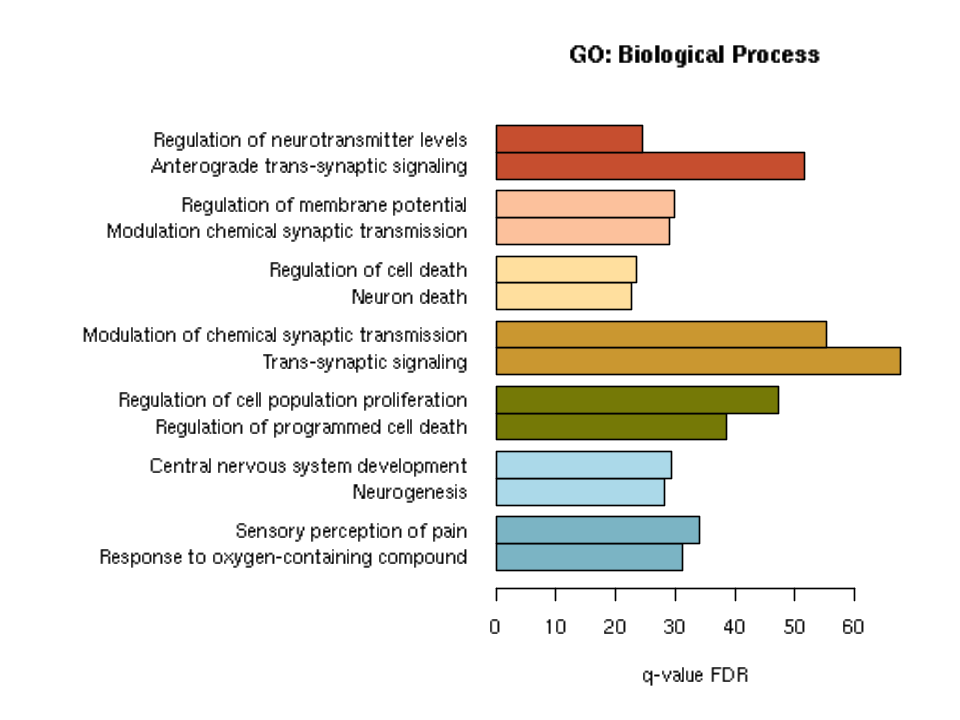

null device 
          1

null device 
          1

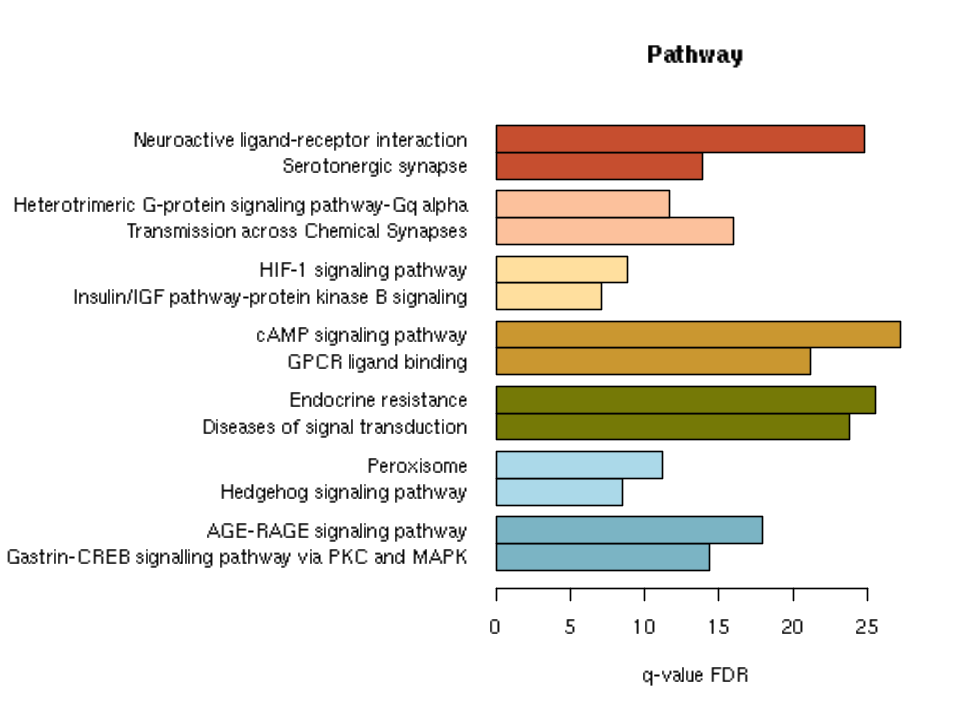

In [12]:
# Genes unique to given GBD category
ugclass=NULL
ugclassize=vector("numeric",7)
cset=1:7
for (i in 1:7)  {
  ots=setdiff(cset,i)
  setlft=gclass[[i]]
  for (j in ots)  {
    setlft=setdiff(setlft,gclass[[j]])
  }
  ugclass[[i]]=setlft
  ugclassize[i]=length(setlft)
}
names(ugclassize)=names(colp) 


# using these unique genes identify unique annotations by GBD class using ToppGene
topin=read.csv(paste(ipath,"ToppGeneUniqueGBDAnnotation.csv",sep=""),header=F)
discats=as.character(unique(topin[,1]))[1:7]
biocats=as.character(unique(topin[,2]))[1:6]

options(repr.plot.width=8, repr.plot.height=6)
discol=c(1,1,3,3,4,4,2,2,5,5,6,6,7,7)
spacevec=c(0.45,0.0)
par(las=1)
par(mar=c(5, 20, 4, 2) + 0.5)
for (i in c(3,6)) {
  ips=which(topin[,2]==biocats[i])
  disvals=rev(as.character(topin[ips,3]))
  qvals=rev(-log10(as.numeric(topin[ips,4])))
  barplot(qvals,names.arg=disvals,col=rev(colp[discol]),cex.names=1,
          space=spacevec,main=biocats[i],horiz=T,xlab="q-value FDR")
}

dev.off()
pdf(paste(opath,"Supplementary_Figure_03.pdf",sep=""),width=15,height=15)
discol=c(1,1,3,3,4,4,2,2,5,5,6,6,7,7)
spacevec=c(0.45,0.0)
par(las=1,mfrow = c(2,1))
par(mar=c(5, 20, 4, 2))
for (i in c(3,6)) {
  ips=which(topin[,2]==biocats[i])
  disvals=rev(as.character(topin[ips,3]))
  qvals=rev(-log10(as.numeric(topin[ips,4])))
  barplot(qvals,names.arg=disvals,col=rev(colp[discol]),cex.names=1,
          space=spacevec,main=biocats[i],horiz=T,xlab="q-value FDR")
}
dev.off()

## Supplementary Figure 2.   Neurological disorders and associated genes

In [13]:
# Intersection by GBD class level and percentage of respective classes
gbdinter=matrix(0,7,7,dimnames=list(names(colp),names(colp)))
gbdintern=matrix(0,7,7,dimnames=list(names(colp),names(colp)))
for (i in 1:7) {
  for (j in 1:7) {
    gbdinter[i,j]=length(intersect(gclass[[i]],gclass[[j]]))/length(union(gclass[[i]],gclass[[j]]))
    if (i==j) {gbdinter[i,j]=0.0}
  }
}

for (i in 1:6) {
  for (j in 2:7) {
    gbdintern[i,j]=length(intersect(gclass[[i]],gclass[[j]]))/gclassize[j]
    gbdintern[j,i]=length(intersect(gclass[[i]],gclass[[j]]))/gclassize[i]
  }
}


In [14]:
# mean percengate of shared genes by GBD class
meanshare=vector("numeric",7)
names(meanshare)=names(colp)
for (j in 1:7) {
  meanshare[j]=mean(gbdinter[,j][-j])
}

### Supplementary Figure 2-A

null device 
          1

null device 
          1

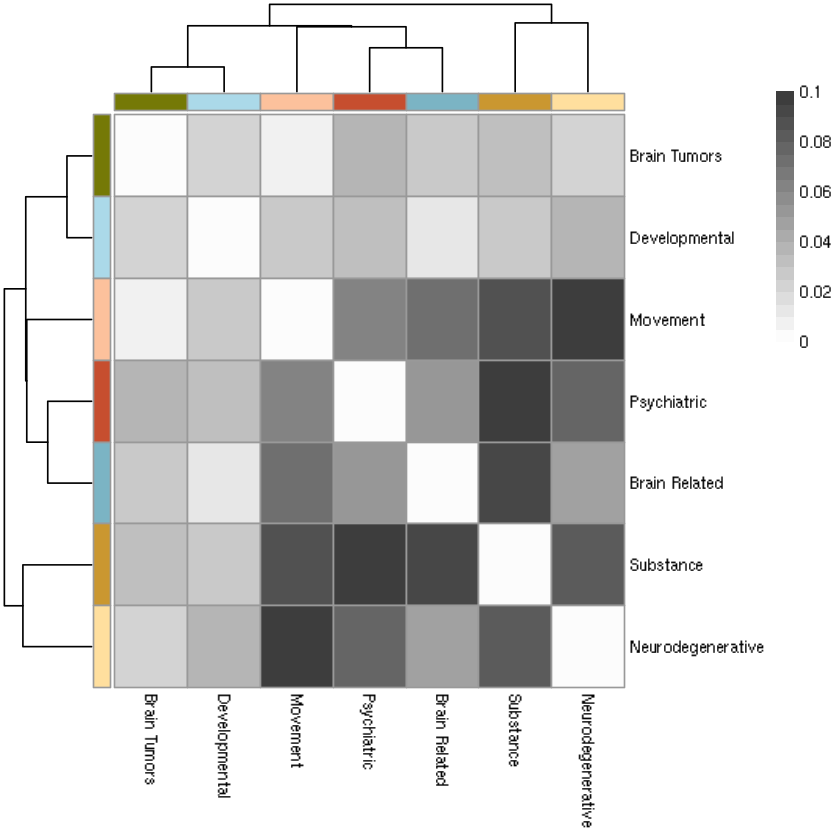

In [15]:
# Suppl. Fig. 3A
# Generate annotations for rows and columns
annotation_col = data.frame(
  Disease = factor(names(colp)) 
)
rownames(annotation_col) = names(colp)

# Specify colors
ann_colors = list(
  Disease = as.character(colp)
)

names(ann_colors$Disease)=names(colp)

options(repr.plot.width=7, repr.plot.height=7)
fpal=colorRampPalette(c("gray99","gray24"))(20)
pheatmap(gbdinter,cluster_rows = TRUE, cluster_cols=TRUE,col=fpal,annotation_colors=ann_colors,breaks = seq(0,0.1,0.1/20),
         annotation_col=annotation_col,annotation_row=annotation_col,annotation_legend=F,annotation_names_col=F,
         annotation_names_row=F)

dev.off()
pdf(paste(opath,"Supplementary_Figure_02_A.pdf",sep=""),width=7,height=7)
fpal=colorRampPalette(c("gray99","gray24"))(20)
pheatmap(gbdinter,cluster_rows = TRUE, cluster_cols=TRUE,col=fpal,annotation_colors=ann_colors,breaks = seq(0,0.1,0.1/20),
         annotation_col=annotation_col,annotation_row=annotation_col,annotation_legend=F,annotation_names_col=F,
         annotation_names_row=F)
dev.off()

In [16]:
# boolean matrix for diseases in same GBD group
intermat=matrix(0,40,40,dimnames=list(names(dclass),names(dclass)))
boolmat=intermat
for (i in 1:dim(boolmat)[1]) {
  for (j in i:dim(boolmat)[2]) {
    d1=dclass[rownames(boolmat)[i]]
    d2=dclass[rownames(boolmat)[j]]
    if (d1==d2) {boolmat[i,j]=1}
  }
}  

# mean relative shared genes and p-value of sets of equivalent size
bootnum=100000
sampvec=vector("numeric",bootnum)
classp=vector("numeric",7)
classb=vector("numeric",7)

for (i in 1:7) {
  ips=which(dclass==i)
  classp[i]=mean(boolmat[ips,ips][row(boolmat[ips,ips])>col(boolmat[ips,ips])])
  print(names(colp)[i])
  for (j in 1:bootnum) {
    # if (j %% 200000==0) {print(j)}
    ts=sample(disnames,length(ips),replace=FALSE)
    tmat=boolmat[ts,ts]
    tmatt=tmat[row(tmat)>col(tmat)]
    sampvec[j]=mean(tmatt)
  }
  classb[i]=sum(sampvec>mean(classp[i]))/bootnum
}

[1] "Psychiatric"
[1] "Substance"
[1] "Movement"
[1] "Neurodegenerative"
[1] "Brain Tumors"
[1] "Developmental"
[1] "Brain Related"


### Supplementary Figure 2-B

In [17]:
# Suppl. Fig. 3B
for (i in 1:40) {
  for (j in 1:40) {
    intermat[i,j]=length(intersect(glists[[i]],glists[[j]]))/length(union(glists[[i]],glists[[j]]))
    if (i==j) {intermat[i,j]=0.0}
  }
}

options(repr.plot.width=10, repr.plot.height=10)
fpal=colorRampPalette(c("gray99","gray1"))(25)
aout=pheatmap(intermat,color=fpal,breaks=seq(0,.25,.01))  # save aout for relative frequency over bar annotation

dev.off()
pdf(paste(opath,"Supplementary_Figure_02_B.pdf",sep=""),width=10,height=10)
fpal=colorRampPalette(c("gray99","gray1"))(25)
aout=pheatmap(intermat,color=fpal,breaks=seq(0,.25,.01))  # save aout for relative frequency over bar annotation 
dev.off()

udislist=NULL
udislen=vector("numeric",40)
dislen=vector("numeric",40)
for (i in 1:length(glists)) {
  utemp=glists[[i]]
  dislen[i]=length(utemp)
  for (j in setdiff(1:40,i)) {
    utemp=setdiff(utemp,glists[[j]])
  }
  udislist[[i]]=utemp
  udislen[i]=length(utemp)  #/length(glists[[i]])
}
names(udislist)=disnames
names(udislen)=disnames


gstat=rbind(udislen,dislen-udislen)
rownames(gstat)=c("Unique","Non-unique")
colnames(gstat)=disnames
cvec=rbind(colp[dclass],rep("white",length(disnames)))
nord=c(rbind(aout$tree_row$order,aout$tree_row$order))

guniq=gstat[1,]/(gstat[1,]+gstat[2,])
names(guniq)=disnames
options(repr.plot.width=10, repr.plot.height=5)
# Suppl. Fig 2 bar annotation 
par(las=2,mar=c(15,4,4,4))
barplot(guniq[aout$tree_row$order],col=colp[dclass][aout$tree_row$order])

dev.off()
pdf(paste(opath,"Supplementary_Figure_02_B_Top.pdf",sep=""),width=10,height=7)
# Supplementary Fig 2 bar annotation 
par(las=2,mar=c(15,4,4,4))
barplot(guniq[aout$tree_row$order],col=colp[dclass][aout$tree_row$order])
dev.off()

null device 
          1

null device 
          1

null device 
          1

null device 
          1

# Figure 1. Transcriptome patterning of major brain diseases

In [18]:
indat=read.csv(paste(ipath,"HBA_Figure_1_Disease_region.csv",sep=""))
inord=read.csv(paste(ipath,"all_orders_3000_10_40.csv",sep=""))
hbain=read.csv(paste(ipath,"HBA_Disease_correlation_overlap_matrix.csv",sep=""),row.names = 1)
hbain_overlap=read.csv(paste(ipath,"HBA_Disease_correlation_overlap_matrix.csv",sep=""),row.names = 1)

inmat=as.matrix(indat[,-1])
disnames=indat[,1]
rownames(inmat)=as.character(disnames)
inmat=inmat[,-47]# remove "Dt" a cerebellar nuclei
colnames(inmat)[69]="3"
colnames(inmat)[74]="4"
colnames(inmat)[90]="8Co"
colnames(inmat)[96]="8Ve"

In [19]:
humont=read.csv(paste0(ipath,"HumanOntology.csv"),header=T)
humont=humont[-47,]

In [20]:
number_of_clusters <- 5
dis_clust_overlap <- hclust(as.dist(1-hbain_overlap),method = "ward.D2")
classes_overlap <- cutree(dis_clust_overlap,number_of_clusters)

In [21]:
BrainAnno <- data.frame(BrainStruct = factor(as.character(humont$acronym)))
rownames(BrainAnno) <- as.character(humont$acronym)

DiseaseAnno <- data.frame(DiseaseStruct = factor(as.character(inord$alphabetical_disease)))
rownames(DiseaseAnno) <- as.character(inord$alphabetical_disease)

ann_colors = list(BrainStruct=paste("#",as.character(humont$Color),sep=""),
                 DiseaseStruct=inord$color)
names(ann_colors$BrainStruct)=as.character(humont$acronym)
names(ann_colors$DiseaseStruct)=as.character(inord$alphabetical_disease)

### Figure 1-A

In [22]:
HBA_region_gaps <- c(8,15,21,33,36,46,48,64,75,79,87,89,101,102)
options(repr.plot.width=20, repr.plot.height=10)
Dis_Reg_matrix_filtered <- t(scale(t(inmat)))
breaksList = seq(-4,4, by = 8/length(hmcols))

pheatmap(inmat,color=hmcols,breaks = breaksList,cluster_cols=F,
         cluster_rows=T,clustering_method = "ward.D2",clustering_distance_rows = as.dist(1-hbain_overlap),cutree_rows =number_of_clusters,
         cellwidth=10,cellheight=10,fontsize=10,gaps_col=HBA_region_gaps,gaps_row=c(6,14,32,36),
         annotation_col=BrainAnno,annotation_legend=F,
         annotation_row=DiseaseAnno,annotation_names_row = F,
         annotation_colors=ann_colors,
         annotation_names_col=F)

dev.off()
pdf(paste(opath,"Figure_01_A.pdf",sep=""),width=20,height=10)
pheatmap(inmat,color=hmcols,breaks = breaksList,cluster_cols=F,
         cluster_rows=T,clustering_method = "ward.D2",clustering_distance_rows = as.dist(1-hbain_overlap),cutree_rows =number_of_clusters,
         cellwidth=10,cellheight=10,fontsize=10,gaps_col=HBA_region_gaps,gaps_row=c(6,14,32,36),
         annotation_col=BrainAnno,annotation_legend=F,
         annotation_row=DiseaseAnno,annotation_names_row = F,
         annotation_colors=ann_colors,
         annotation_names_col=F)
dev.off()



null device 
          1

null device 
          1

In [23]:
write.csv(inmat[inord$HBA_cluster_order_overlap,],paste(opath,"Figure_01_A.csv",sep=""))

### Figure 1-A upper panel

null device 
          1

null device 
          1

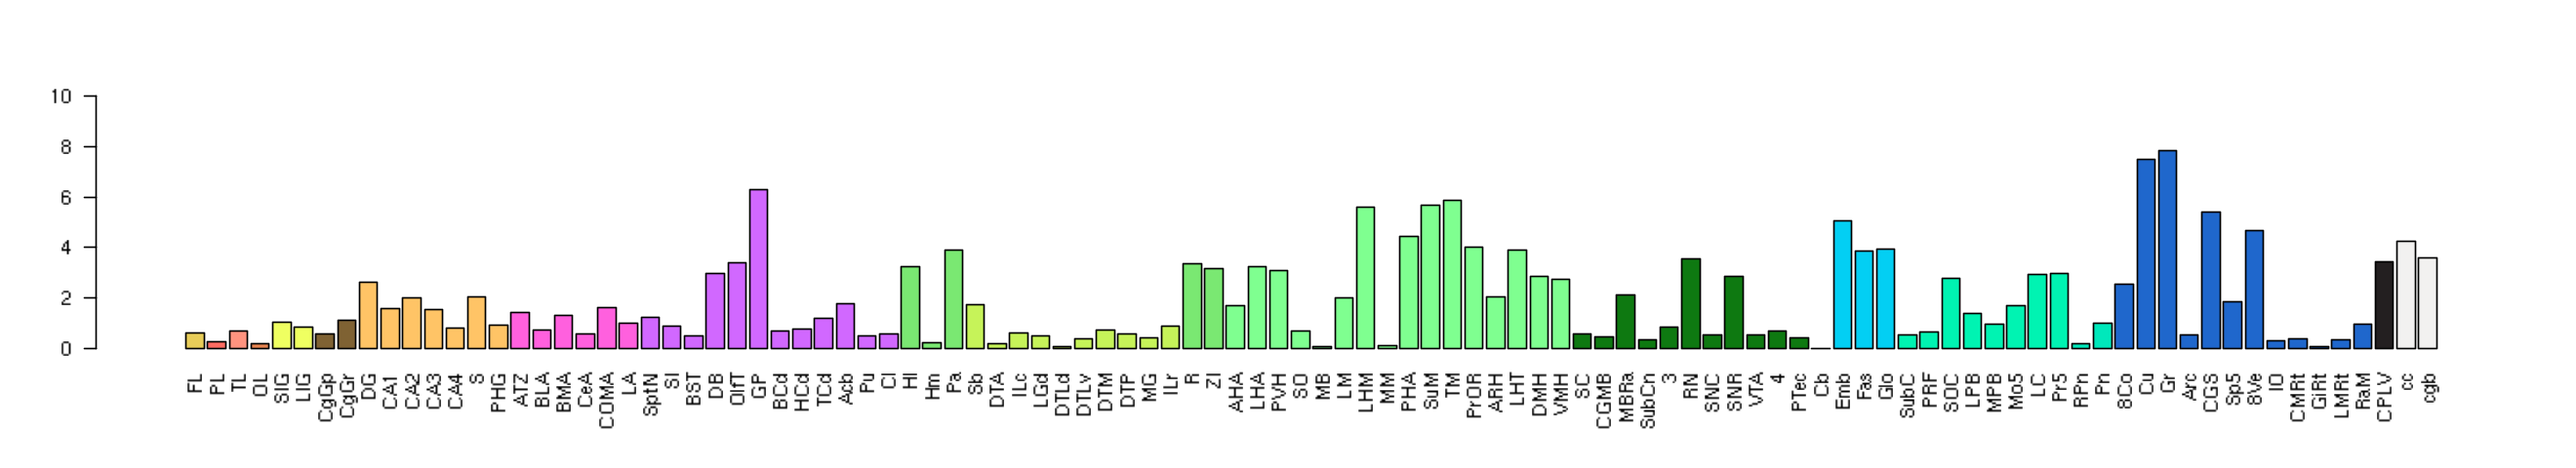

In [24]:
#  ANOVA by structure
mfac=as.numeric(inord$HBA_modules_overlap)
# mfac=as.numeric(inord[,10])
anval=vector("numeric",dim(inmat)[2])
names(anval)=as.character(humont[,1])
for (j in 1:length(anval)) {
  adf=as.data.frame(cbind(inmat[,j],mfac))
  anval[j]=summary(aov(V1~mfac,adf))[[1]][1,5]
}

# Regional colors
ann_colors = list(BrainStruct=paste("#",as.character(humont[,4]),sep=""))
names(ann_colors$BrainStruct)=as.character(humont[,1])

# ANOVA upper annotation Figure 1
colvec=paste("#",as.character(humont[,4]),sep="")
par(las=2)
options(repr.plot.width=22, repr.plot.height=4)
barplot(-log10(anval),cex.names=1,col=colvec,ylim=c(0,10))

dev.off()
pdf(paste(opath,"Figure_1_A_Top.pdf",sep=""),width=18,height=4)
colvec=paste("#",as.character(humont[,4]),sep="")
par(las=2)
barplot(-log10(anval),cex.names=1,col=colvec,ylim=c(0,10))
dev.off()

In [25]:
write.csv(anval,paste(opath,"Figure_01_A_Top.csv",sep=""))

In [26]:
# Figure 2C: t-tests between groups - all anatomic structures
pvmat=matrix(0,10,dim(inmat)[2])
colnames(pvmat)=colnames(inmat)

dimvec=NULL
for (k in 1:dim(inmat)[2]) {
  ip=0
  for (i in 1:(max(mfac)-1)) {
    for (j in (i+1):max(mfac))  {
      ip=ip+1
#       d1=inmat[groups[[i]],k]
#       d2=inmat[groups[[j]],k]
      d1=inmat[which(inord$HBA_modules_overlap==i),k]
      d2=inmat[which(inord$HBA_modules_overlap==j),k]
      pvmat[ip,k]=t.test(d1,d2)$p.value
      dimvec=c(dimvec,paste(i,"-",j,sep=""))
    }
  }
}
rownames(pvmat)=dimvec[1:10]

In [27]:
# adjusted p-values and threshold
pvmatc=pvmat
for (j in 1:dim(pvmat)[2]) {
#   pvmatc[,j]=p.adjust(pvmat[,j])
    pvmatc[,j]=p.adjust(pvmat[,j],'BH')
}

thresh=0.05 #0.01
for (i in 1:dim(pvmat)[1]) {
  for (j in 1:dim(pvmat)[2]) {
    if (pvmatc[i,j]>thresh) {pvmatc[i,j]=1}
  }
}
 

strnm=colnames(pvmatc)
strcol=paste("#",humont[which(humont[,1] %in% strnm),4],sep="")
colnames(pvmatc)=strnm

In [28]:
indir=paste(ipath,"Subject_Disease/",sep="")
infiles=list.files(indir)

patmat=NULL
for (i in 1:length(infiles)) {
    indat=read.csv(paste(indir,infiles[i],sep=""))
#   inmat=as.matrix(indat[,2:dim(indat)[2]])
#   rownames(inmat)=as.character(indat[,1])
    inmat=as.matrix(indat[,-1])
    rownames(inmat)=as.character(indat[,1])
    inmat=inmat[,-which(colnames(inmat)=="Dt")]# remove "Dt" a cerebellar nuclei
    colnames(inmat)[colnames(inmat)=="X3"]="3"
    colnames(inmat)[colnames(inmat)=="X4"]="4"
    colnames(inmat)[colnames(inmat)=="X8Co"]="8Co"
    colnames(inmat)[colnames(inmat)=="X8Ve"]="8Ve"
    patmat[[i]]=inmat
}
disnames=rownames(patmat[[1]])

# also make z-scored versions
patmatz=NULL
for (i in 1:6) {
  patmatz[[i]]=patmat[[i]]
  for (j in 1:dim(patmatz[[i]])[1]) {
    patmatz[[i]][j,]=(patmat[[i]][j,]-mean(patmat[[i]][j,]))/sd(patmat[[i]][j,])
  }
}

In [29]:
correspond_data = matrix(0,nrow = (40*40-40)/2,ncol = 5)
k=1;
for (i in 1:39) {
  for (j in (i+1):40) {
#     print(cbind(k,i,j,mfac[i],mfac[j]))
    correspond_data[k,1]=i
    correspond_data[k,2]=j
    correspond_data[k,3]=length(intersect(glists[[i]],glists[[j]]))
    correspond_data[k,4]=length(intersect(glists[[i]],glists[[j]]))/length(union(glists[[i]],glists[[j]]))
    correspond_data[k,5]=1*(mfac[i]==mfac[j])
    k=k+1;
  }
}
correspond_data_out <- data.frame(dis1=disnames[correspond_data[,1]],dis2=disnames[correspond_data[,2]],
                                 gene_overlap=correspond_data[,3],gene_overlap_normalized=correspond_data[,4],
                                 ADG_overlap=correspond_data[,5])
write.csv(correspond_data_out,paste(opath,"Supplementary_Figure_8_test.csv",sep=""),row.names=FALSE)

In [30]:
# Figure 1D: ADG and GBD uniqueness mapping 

usestrs=FALSE
titl="All Structures"
if (usestrs==TRUE) {
  titl="Neocortex"
  setstrs=c("FL","PL","TL","OL")
  #setstrs=c("FL","PL","TL","OL","CA1","CA2","CA3","CA4","DG")
}

# compare closest assignment averaged over all brain pairs
closdismat=matrix(0,disnum,disnum,dimnames=list(disnames,disnames))

for (i in 1:disnum) {
  for (b1 in 1:6) {
    for (b2 in setdiff(1:6,b1)) {
      intstrs=intersect(colnames(patmat[[b1]]),colnames(patmat[[b2]]))
      if (usestrs==TRUE) {intstrs=setstrs}
      dmin=10000
      for (j in 1:disnum) {   # find closest disease in in b2
        dt=sqrt(sum((patmatz[[b1]][i,intstrs]-patmatz[[b2]][j,intstrs])^2))
        if (dt<dmin) {
          dmin=dt
          dind=j
        }
      }
      closdismat[i,dind]=closdismat[i,dind]+1
    }
  }
}

In [31]:
# non-symettrized for counting
closdismatc=closdismat/5

# symmetrized for plotting
closdismat=(closdismat+t(closdismat))/(2*5)

hbaord=inord$HBA_cluster_order_overlap#hbaord=inord[,7]

# Summary by ADG 
hbaclus=inord$HBA_modules_overlap#hbaclus=inord[,8]
adgcor=vector("numeric",max(mfac))
adgexa=vector("numeric",max(mfac))
names(adgcor)=paste("ADG",1:max(mfac))
names(adgexa)=paste("ADG",1:max(mfac))
for (i in 1:max(mfac)) {
  ips=which(hbaclus==i)
  adgcor[i]=sum(closdismatc[ips,ips])/sum(closdismatc[ips,])
  adgexa[i]=mean(diag(closdismat[ips,ips]))/6
}   

### Figure 1-C and 1-D

In [32]:
# Summary by GBD
gbdcor=vector("numeric",length(colp))
gbdexa=vector("numeric",length(colp))
names(gbdcor)=names(colp)
names(gbdexa)=names(colp)
for (i in 1:length(colp)) {
  ips=which(dclass==i)
  gbdcor[i]=sum(closdismatc[ips,ips])/sum(closdismatc[ips,])
  gbdexa[i]=mean(diag(closdismatc[ips,ips]))/6
}     

options(repr.plot.width=20, repr.plot.height=5)

par(mfrow=c(1,2))
ordv=order(adgcor,decreasing=TRUE)
barplot(rbind(adgcor[ordv],adgexa[ordv]),col=c("gray50","white"),beside=TRUE,horiz=FALSE,ylim=c(0,1.0),density=c(120,0))

ordv=order(gbdcor,decreasing=TRUE)
barplot(rbind(gbdcor[ordv],gbdexa[ordv]),col=c(rbind(colp[ordv],colp[ordv])),beside=TRUE,horiz=FALSE,ylim=c(0,1.0),density=c(120,0))

dev.off()
pdf(paste(opath,"Figure_01_C_D.pdf",sep=""),width=18,height=5)
par(mfrow=c(1,2))
ordv=order(adgcor,decreasing=TRUE)
barplot(rbind(adgcor[ordv],adgexa[ordv]),col=c("gray50","white"),beside=TRUE,horiz=FALSE,ylim=c(0,1.0),density=c(120,0))

ordv=order(gbdcor,decreasing=TRUE)
barplot(rbind(gbdcor[ordv],gbdexa[ordv]),col=c(rbind(colp[ordv],colp[ordv])),beside=TRUE,horiz=FALSE,ylim=c(0,1.0),density=c(120,0))
dev.off()

null device 
          1

null device 
          1

In [33]:
mean_adg <- adgcor
mean_exact <- adgexa
ADG_Holdout <- rbind(mean_adg,mean_exact)
mean_gbd <- gbdcor
mean_exact <- gbdexa
GBD_Holdout <- rbind(mean_gbd,mean_exact)
ADG_Holdout
GBD_Holdout

ADG 1     ADG 2     ADG 3     ADG 4     ADG 5
mean_adg   0.9666667 0.7708333 0.9611111 1.0000000 0.925
mean_exact 0.7166667 0.5375000 0.6444444 0.9583333 0.875

Psychiatric Substance Movement  Neurodegenerative Brain Tumors
mean_gbd   0.5500000   0.8952381 0.9400000 0.7583333         0.7533333   
mean_exact 0.4333333   0.8285714 0.9333333 0.6333333         0.6066667   
           Developmental Brain Related
mean_gbd   0.64          0.8250000    
mean_exact 0.62          0.8166667

### Figure 1-A right panel

null device 
          1

null device 
          1

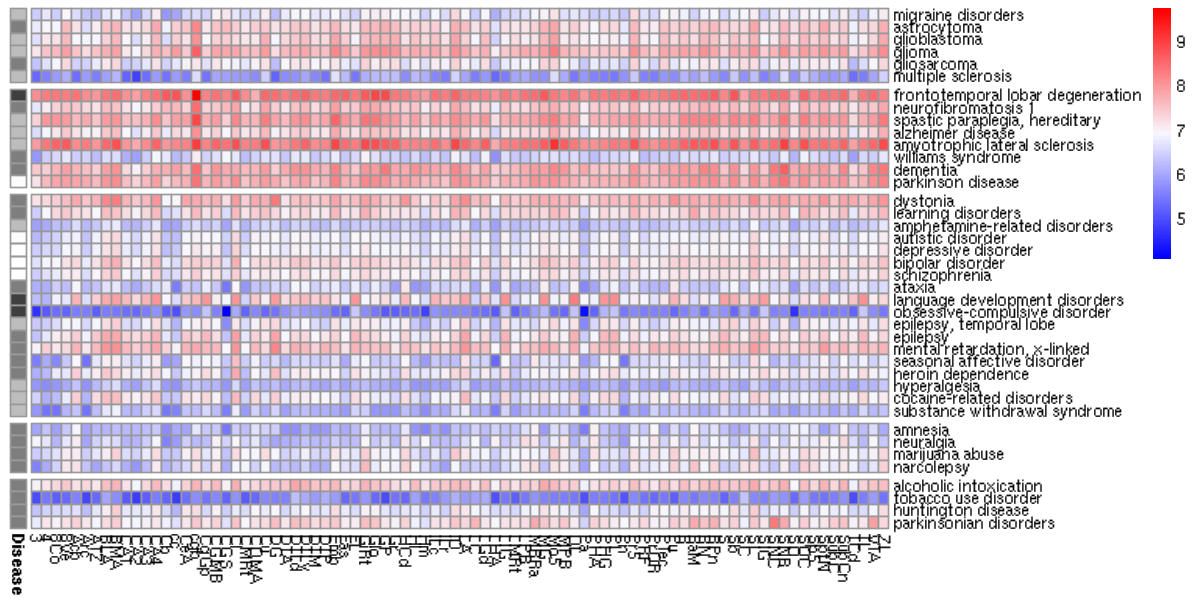

In [34]:
# unique side panel
fpal=colorRampPalette(c("gray0","gray99"))(5)
numvec=vector("numeric",disnum)
colvec=vector("character",disnum)
for (i in 1:disnum) {
  numvec[i]=length(unlist(glists[i]))
  colvec[i]=fpal[round(log(numvec[i]))]
}

# Generate annotations for rows and columns
annotation_row = data.frame(
  Disease = factor(disnames) 
)
rownames(annotation_row) = disnames

# Specify colors
ann_colors = list(
  Disease = colvec
)

names(ann_colors$Disease)=disnames

options(repr.plot.width=10, repr.plot.height=5)

pheatmap(patmat[[1]][disnames[inord$HBA_cluster_order_overlap],],cluster_rows=FALSE,cluster_cols=FALSE,
         annotation_row=annotation_row,
         annotation_colors = ann_colors,annotation_legend = FALSE,col=hmcols,gaps_row=c(6,14,32,36))

dev.off()
pdf(paste(opath,"Figure_01_A_Side.pdf",sep=""),width=10,height=5)
pheatmap(patmat[[1]][disnames[inord$HBA_cluster_order_overlap],],cluster_rows=FALSE,cluster_cols=FALSE,
         annotation_row=annotation_row,
         annotation_colors = ann_colors,annotation_legend = FALSE,col=hmcols,gaps_row=c(6,14,32,36))
dev.off()

In [35]:
write.csv(data.frame(disease_name=disnames,n_genes=numvec,log_n_genes=log(numvec)),
          paste(opath,"Figure_01-A_right_panel.csv",sep=""))

## Supplementary Figure 10. Pairwise comparison of ADG.

null device 
          1

null device 
          1

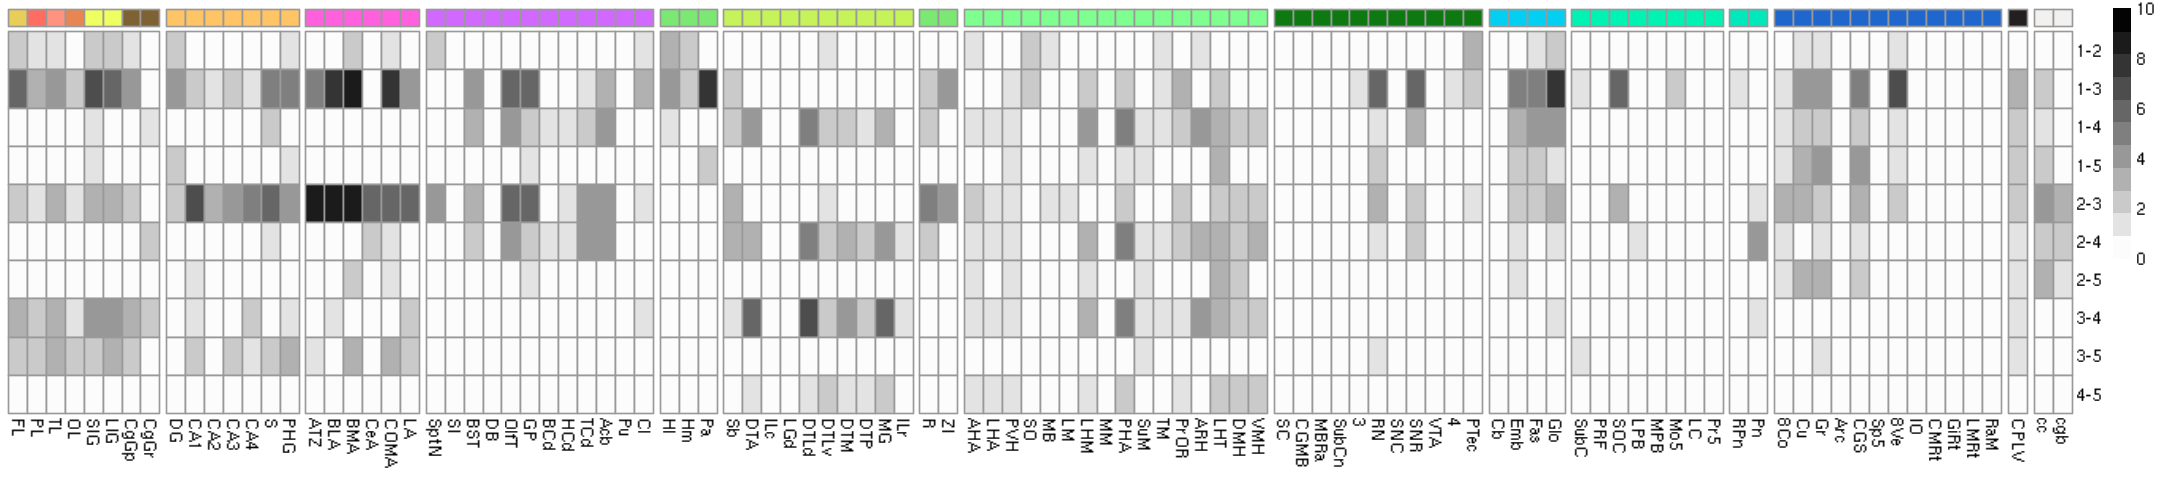

In [36]:
# Generate annotations for rows and columns
annotation_col = data.frame(
  Structures = factor(strnm)
)
rownames(annotation_col) = strnm

# Specify colors
ann_colors = list(
  Structures = as.character(strcol)
)

names(ann_colors$Structures)=strnm

brkvec=vector("numeric",length(majstr)-1)
for (i in 1:length(majstr)-1) {
  brkvec[i]=majstr[[i+1]][1]-1
}

fpal=colorRampPalette(c("gray99","gray1"))(11)
breaksList = seq(0,10, by = 10/length(fpal))

options(repr.plot.width=18, repr.plot.height=4)
pheatmap(-log10(pvmatc),cluster_rows=F,cluster_cols=F,annotation_col=annotation_col,breaks = breaksList,
         annotation_legend = F, annotation_names_col = F, annotation_colors = ann_colors,col=fpal,gaps_col=brkvec)

dev.off()
pdf(paste(opath,"Supplementary_Figure_10.pdf",sep=""),width=18,height=4)
pheatmap(-log10(pvmatc),cluster_rows=F,cluster_cols=F,annotation_col=annotation_col,breaks = breaksList,
         annotation_legend = F, annotation_names_col = F, annotation_colors = ann_colors,col=fpal,gaps_col=brkvec)
dev.off()

In [37]:
write.csv(pvmat,paste(opath,"HBA_ADG_ttest.csv",sep=""))
write.csv(pvmatc,paste(opath,"HBA_ADG_ttest_BH_corrected.csv",sep=""))

## Supplementary Figure 4.  Mean anatomic transcriptomic profile for ADG groups

In [38]:
humont=read.csv(paste0(ipath,"HumanOntology.csv"),header=T)
# Colors for major structures
colvec=vector("character",15)
names(colvec)=names(majstr)
colvec[1]=paste("#",humont[1,4],sep="")
colvec[2]=paste("#",humont[10,4],sep="")
colvec[3]=paste("#",humont[18,4],sep="")
colvec[4]=paste("#",humont[29,4],sep="")
colvec[5]=paste("#",humont[35,4],sep="")
colvec[6]=paste("#",humont[43,4],sep="")
colvec[7]=paste("#",humont[49,4],sep="")
colvec[8]=paste("#",humont[58,4],sep="")
colvec[9]=paste("#",humont[72,4],sep="")
colvec[10]=paste("#",humont[77,4],sep="")
colvec[11]=paste("#",humont[86,4],sep="")
colvec[12]=paste("#",humont[90,4],sep="")
colvec[13]=paste("#",humont[99,4],sep="")
colvec[14]=paste("#",humont[103,4],sep="")
colvec[15]=paste("#",humont[105,4],sep="")


In [39]:
indat=read.csv(paste(ipath,"HBA_Figure_1_Disease_region.csv",sep=""))
inord=read.csv(paste(ipath,"all_orders_3000_10_40.csv",sep=""))
inmat=as.matrix(indat[,-1])
rownames(inmat)=disnames

humont=read.csv(paste(ipath,"HumanOntology.csv",sep=""))

# remove "Dt" a cerebellar nuclei
inmatm=inmat[,-47]
 
lupper=2.0; llower= -2.0
profmat=matrix(0,max(mfac),15,dimnames=list(paste("ADG",c(1:max(mfac))),names(majstr)))
sdmat=matrix(0,max(mfac),15,dimnames=list(paste("ADG",c(1:max(mfac))),names(majstr)))

clusgr=inord$HBA_modules_overlap
for (i in 1:max(mfac)) {
  for (j in 1:15) {
    ips=which(clusgr==i)
    profmat[i,j]=mean(as.vector(inmatm[ips,majstr[[j]]]))
    sdmat[i,j]=sd(as.vector(inmatm[ips,majstr[[j]]]))/sqrt(length(as.vector(inmatm[ips,majstr[[j]]])))
    if (profmat[i,j]>lupper) {profmat[i,j]=lupper}
    if (profmat[i,j]< llower) {profmat[i,j]=llower}
  }
}

## Supplementary Figure 6.    Reproducibility of ADG clustering

In [40]:
adgrps=NULL
adgrps[[1]]=1:6
adgrps[[2]]=7:14
adgrps[[3]]=15:32
adgrps[[4]]=33:36
adgrps[[5]]=37:40

adggrp=inord$HBA_modules_overlap
patmeans=NULL
 
corbr=vector("numeric",6)
br=c(1:6)
for (i in 1:6) {
  # first get intersection of remaining brain structures
  brr=setdiff(br,i)
  strinter=colnames(patmatz[[brr[1]]])
  for (j in 2:5) {
    strinter=intersect(strinter,colnames(patmatz[[brr[j]]]))
  }
  # form profile in these 5 brains
  patmean=(patmatz[[brr[1]]][,strinter]+patmatz[[brr[2]]][,strinter]+patmatz[[brr[3]]][,strinter]+
             patmatz[[brr[4]]][,strinter]+patmatz[[brr[5]]][,strinter])/6
  
  
  neword=intersect(strnm,colnames(patmean))
  
  
  tmat=patmean[hbaord,neword]
  summat=matrix(0,max(mfac),length(colnames(tmat)),dimnames=list(paste("ADG",1:max(mfac)),colnames(tmat)))
  for (k in 1:max(mfac)) {
    for (l in 1:length(colnames(tmat)))  {
      summat[k,l]=mean(tmat[adgrps[[k]],l])
    }
  }
  patmeans[[i]]=summat[,neword]
   
  corbr[i]=cor(as.vector(as.matrix(dist(patmean))),as.vector(as.matrix(dist(patmatz[[i]]))))
  
} 

intstrs=colnames(patmat[[1]])
for (i in 2:6) {
  intstrs=intersect(intstrs,colnames(patmat[[i]]))
}

intstrs=intersect(as.character(humont[,1]),intstrs)

In [41]:
# set up for individual brain analysis
patmeano=NULL
tmat=matrix(0,max(mfac),length(intstrs),dimnames=list(c("ADG 1","ADG 2","ADG 3","ADG 4","ADG 5"),intstrs))
for (i in 1:6) {
  ipo=which(colnames(patmatz[[i]])=="X8Ve")
  colnames(patmatz[[i]])[ipo]="8Ve"
  for (j in 1:max(mfac)) {
    ips=which(inord$HBA_modules_overlap==j)
    tmat[j,]=apply(patmatz[[i]][ips,intstrs],2,mean)
  }
  patmeano[[i]]=tmat
}
 

ordchecki=vector("numeric",length(intstrs)) 
codevec=vector("numeric",6) 
names(ordchecki)=intstrs
pcode=c(2,3,5,7,11) 
 
for (i in 1:length(intstrs)) {
  for (j in 1:6) {
    osig=order(patmeans[[j]][,i])
    codevec[j]=prod(pcode^osig)
  }
  ordchecki[i]=max(table(codevec))
}

null device 
          1

null device 
          1

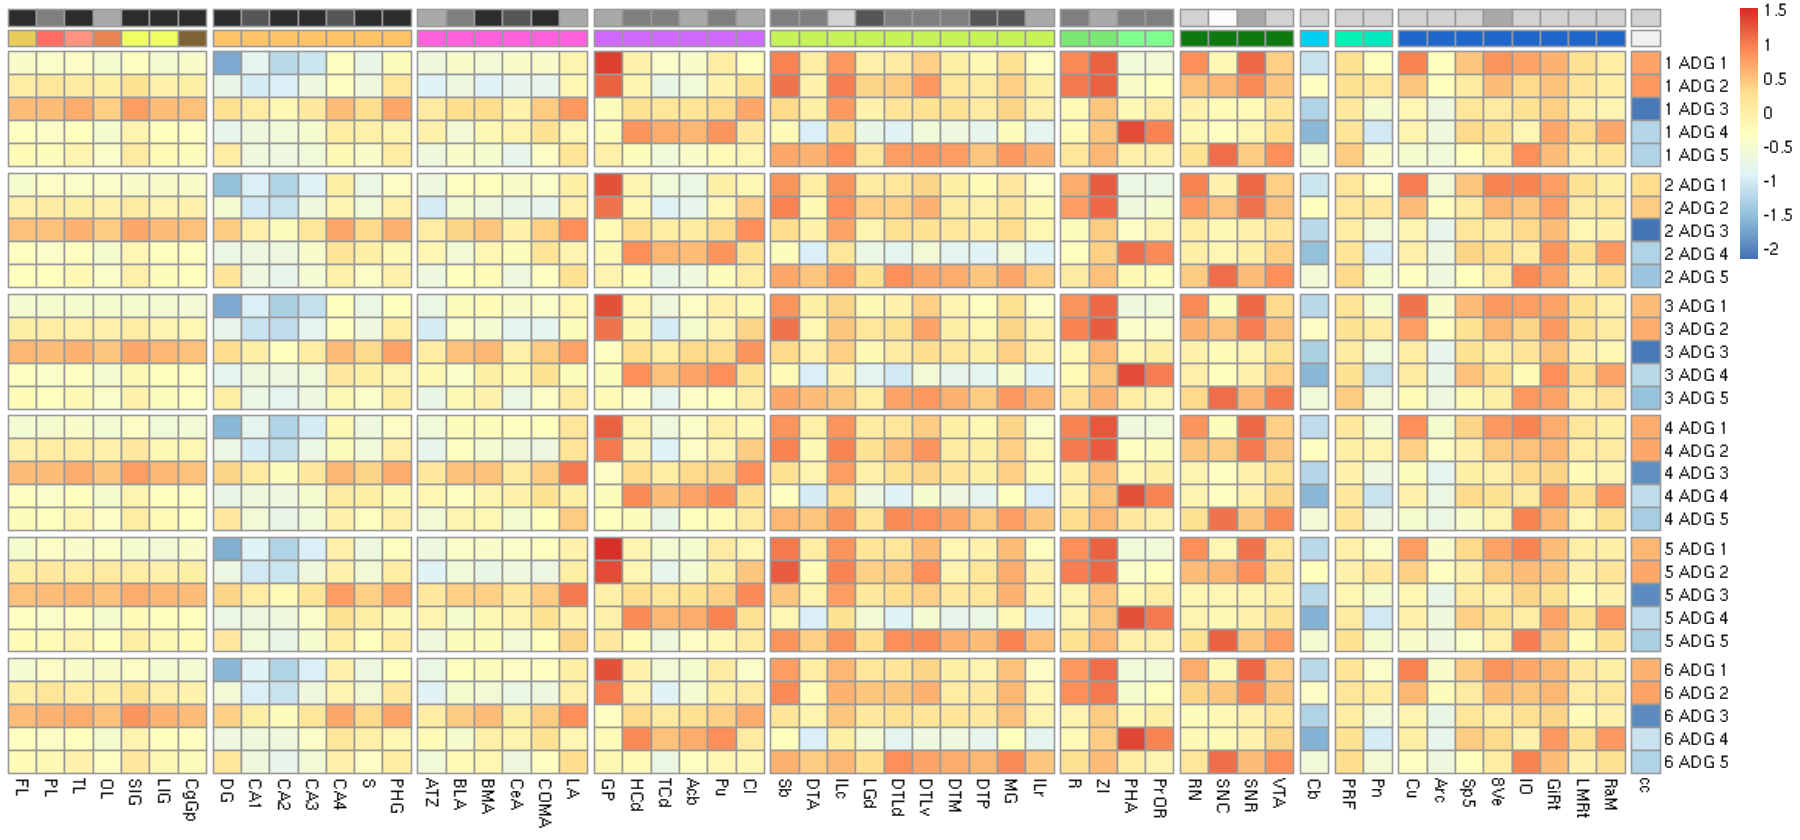

In [42]:
stmat=matrix(0,6*max(mfac),length(intstrs))
stmato=matrix(0,6*max(mfac),length(intstrs))
colnames(stmat)=intstrs
colnames(stmato)=intstrs
for (i in 1:6) { 
  stmat[(i-1)*max(mfac)+1,]=patmeans[[i]][1,intstrs]
  stmat[(i-1)*max(mfac)+2,]=patmeans[[i]][2,intstrs]
  stmat[(i-1)*max(mfac)+3,]=patmeans[[i]][3,intstrs]
  stmat[(i-1)*max(mfac)+4,]=patmeans[[i]][4,intstrs]
  stmat[(i-1)*max(mfac)+5,]=patmeans[[i]][5,intstrs]
}

rownames(stmat)=paste(c(rep(1,max(mfac)),rep(2,max(mfac)),rep(3,max(mfac)),rep(4,max(mfac)),rep(5,max(mfac)),rep(6,max(mfac))),
                      rep(paste("ADG",1:max(mfac)),6))
rownames(stmato)=paste(c(rep(1,max(mfac)),rep(2,max(mfac)),rep(3,max(mfac)),rep(4,max(mfac)),rep(5,max(mfac)),rep(6,max(mfac))),
                       rep(paste("ADG",1:max(mfac)),6))


fpal=colorRampPalette(c("gray99","gray1"))(7)
# Generate annotations for rows and columns
annotation_col = data.frame(
  Structures = factor(intstrs),
  Scores = factor(intstrs)
)
rownames(annotation_col) = intstrs


ips=which(humont[,1] %in% intstrs)
scol=paste("#",humont[ips,4],sep="")

# Specify colors
ann_colors = list(
  Structures = scol,
  Scores = fpal[ordchecki]
)

names(ann_colors$Scores)=intstrs 
names(ann_colors$Structures)=intstrs
options(repr.plot.width=15, repr.plot.height=7)

pheatmap(stmat,cluster_rows=FALSE,cluster_cols=FALSE,gaps_row=(1:5)*max(mfac),gaps_col=c(7,14,20,26,36,40,44,45,47,55),
         annotation_colors=ann_colors,annotation_col=annotation_col,annotation_legend=F,annotation_names_col=F,
         annotation_names_row=F)

dev.off()
pdf(paste(opath,"Supplementary_Figure_06.pdf",sep=""),width=15,height=7)
pheatmap(stmat,cluster_rows=FALSE,cluster_cols=FALSE,gaps_row=(1:5)*max(mfac),gaps_col=c(7,14,20,26,36,40,44,45,47,55),
         annotation_colors=ann_colors,annotation_col=annotation_col,annotation_legend=F,annotation_names_col=F,
         annotation_names_row=F)
dev.off()

In [43]:
write.csv(stmat,paste(opath,"Supplementary_Figure_6.csv",sep=""))

## Supplementary Figure 7.    Holdout analysis and ADG

In [44]:
indir=paste(ipath,"Subject_Disease_gz/",sep="")
infiles=list.files(indir)

patmat=NULL
for (i in 1:length(infiles)) {
    indat=read.csv(paste(indir,infiles[i],sep=""))
    inmat_ind=as.matrix(indat[,-1])
    rownames(inmat_ind)=as.character(indat[,1])
    colnames(inmat_ind)[colnames(inmat_ind)=="X3"]="3"
    colnames(inmat_ind)[colnames(inmat_ind)=="X4"]="4"
    colnames(inmat_ind)[colnames(inmat_ind)=="X8Co"]="8Co"
    colnames(inmat_ind)[colnames(inmat_ind)=="X8Ve"]="8Ve"
    patmat[[i]]=inmat_ind
}
disnames=rownames(patmat[[1]])

In [45]:
DiseaseAnno <- data.frame(DiseaseStruct = factor(as.character(inord$alphabetical_disease)))
rownames(DiseaseAnno) <- as.character(inord$alphabetical_disease)
ann_colors_d = list(DiseaseStruct=inord$color)
names(ann_colors_d$DiseaseStruct)=as.character(inord$alphabetical_disease)

### Supplementary Figure 7 - upper triangular 

null device 
          1

null device 
          1

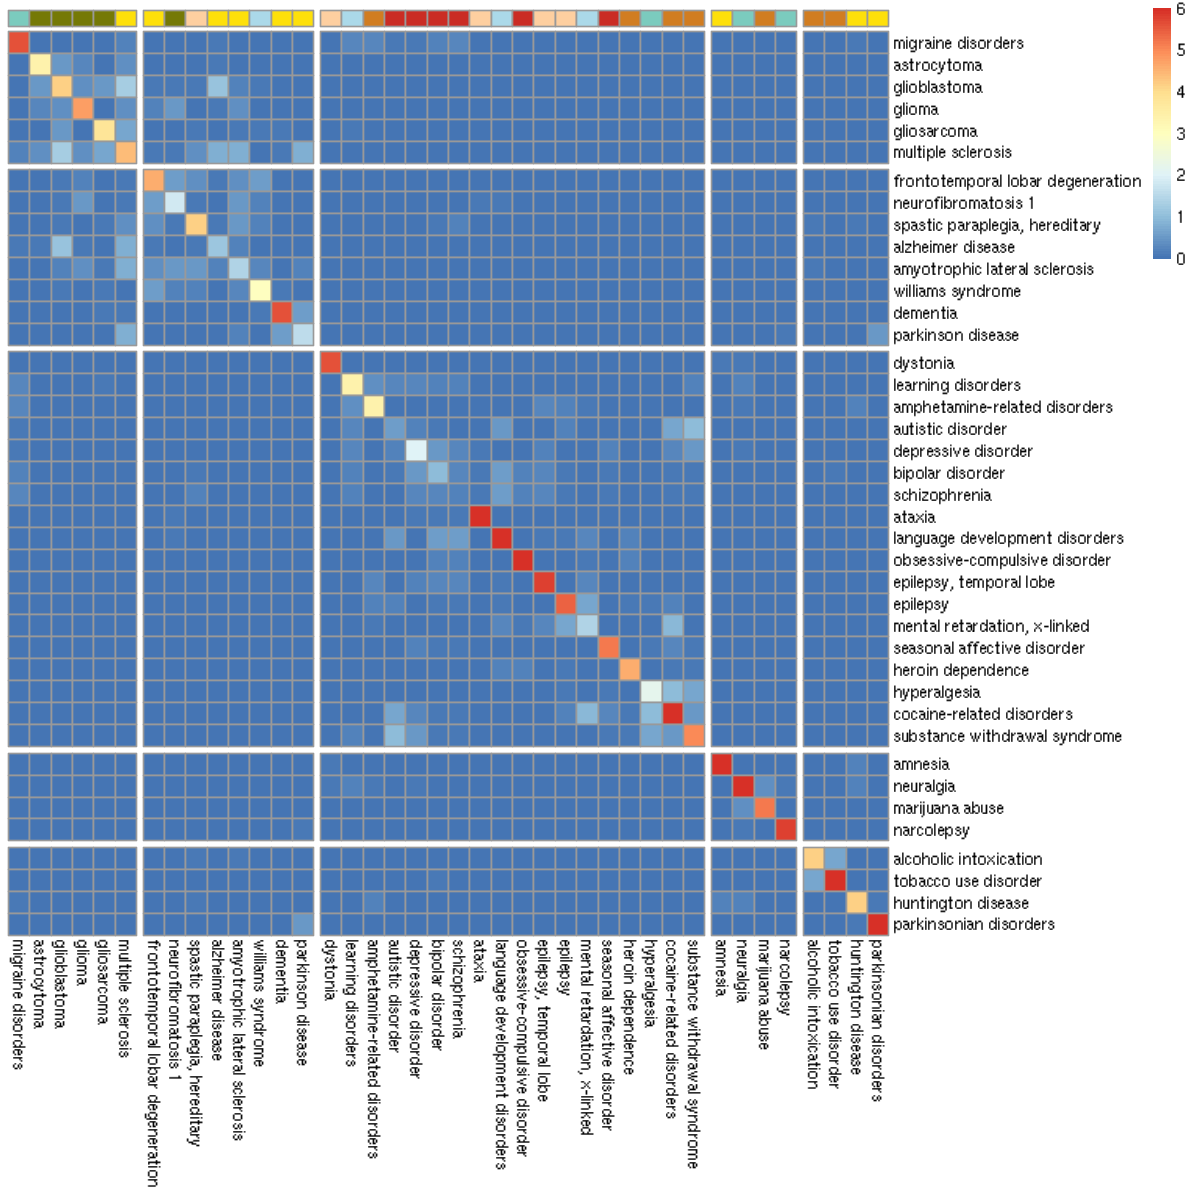

In [46]:
# Find the closest disease over all other subjects to a given one
closdismat=matrix(0,disnum,disnum,dimnames=list(disnames,disnames))

for (i in 1:disnum) {
    for (b1 in 1:6) {
      for (b2 in setdiff(1:6,b1)) {
        intstrs=intersect(colnames(patmat[[b1]]),colnames(patmat[[b2]]))
        dmin=Inf
        for (j in 1:disnum) {   # find closest disease in in b2
         dt=sqrt(mean((scale(patmat[[b1]][i,intstrs])-scale(patmat[[b2]][j,intstrs]))^2))
         if (dt<dmin) {
           dmin=dt
           dind=j
         }
        }
        closdismat[i,dind]=closdismat[i,dind]+1
      }
    }
}

closdismat=(closdismat+t(closdismat))/(2*5)
hbaord=inord$HBA_cluster_order_overlap

options(repr.plot.width=10, repr.plot.height=10)
pheatmap(closdismat[hbaord,hbaord],cluster_rows=FALSE,cluster_cols=FALSE,gaps_row = c(6,14,32,36),gaps_col = c(6,14,32,36),
         annotation_legend=F,
         annotation_col=DiseaseAnno,annotation_names_col = F,
         annotation_colors=ann_colors_d,
         annotation_names_row=F)

dev.off()
pdf(paste(opath,"Supplementary_Figure_07_Top.pdf",sep=""),width=10,height=10)
pheatmap(closdismat[hbaord,hbaord],cluster_rows=FALSE,cluster_cols=FALSE,gaps_row = c(6,14,32,36),gaps_col = c(6,14,32,36),
         annotation_legend=F,
         annotation_col=DiseaseAnno,annotation_names_col = F,
         annotation_colors=ann_colors_d,
         annotation_names_row=F)
dev.off()

### Supplementary Figure 7 - lower triangular 

null device 
          1

null device 
          1

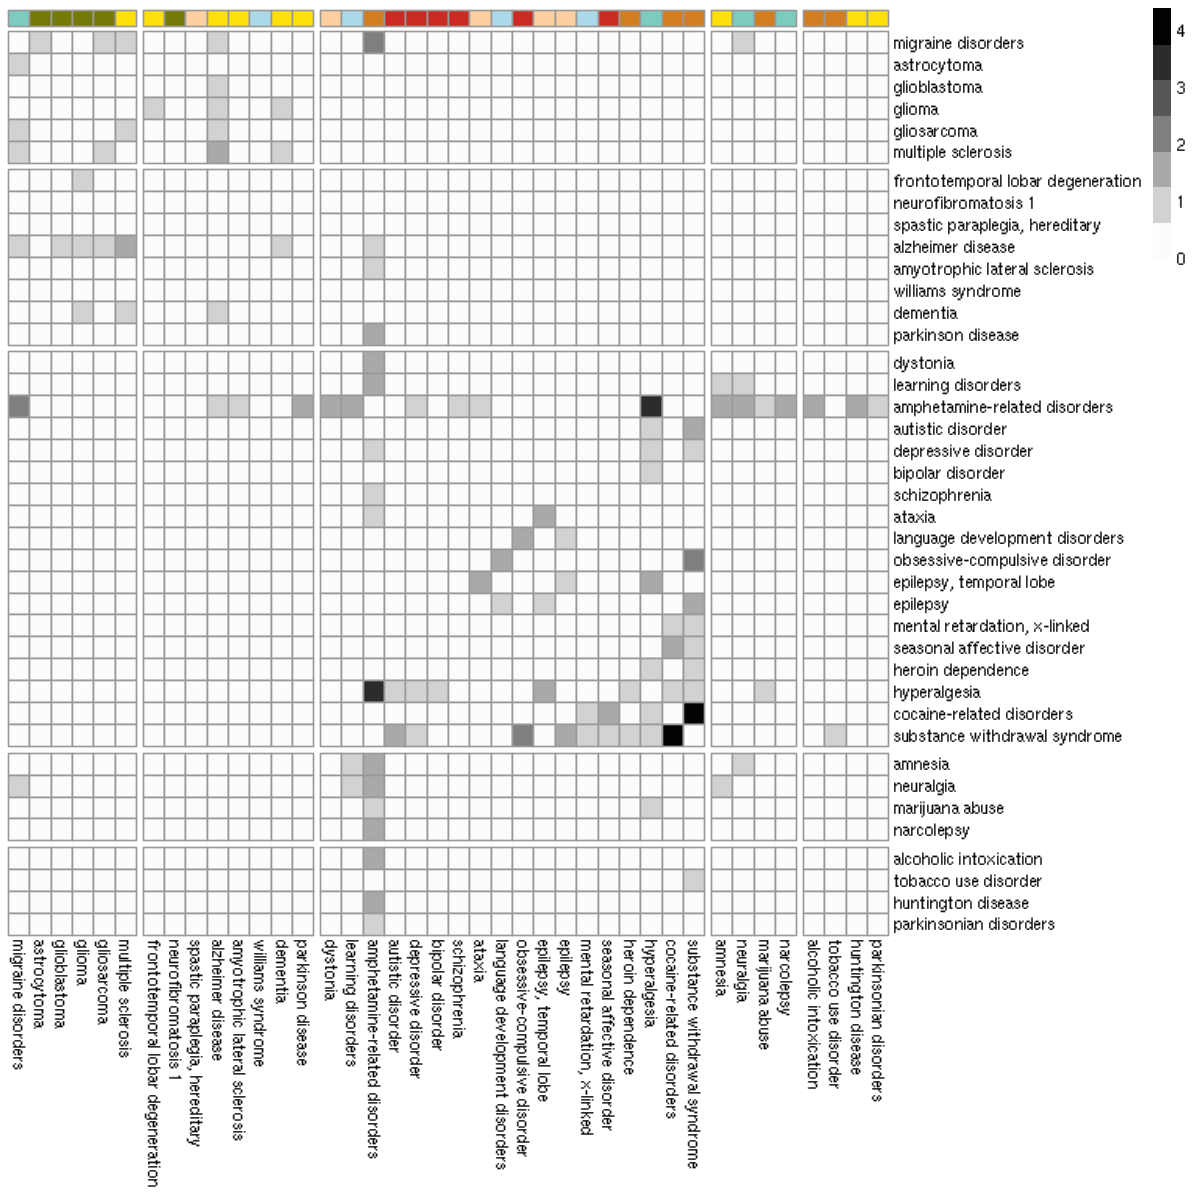

In [47]:
stability_matrix_test <- read.csv(paste(ipath,"HBA_cluster_stability_overlap.csv",sep=""),row.names = 1)
colnames(stability_matrix_test) <- rownames(stability_matrix_test)

stability_matrix_test <- (stability_matrix_test + t(stability_matrix_test))/(2*5)
fpal=colorRampPalette(c("gray99","gray1"))(7)
options(repr.plot.width=10, repr.plot.height=10)
# pheatmap(stability_matrix_test[hbaord,hbaord],color = fpal,cluster_rows=FALSE,cluster_cols=FALSE,
#          gaps_row = c(6,14,32,36),gaps_col = c(6,14,32,36),
#          annotation_legend=F,
#          annotation_col=DiseaseAnno,annotation_names_col = F,
#          annotation_colors=ann_colors_d,
#          annotation_names_row=F)

# dev.off()
# pdf(paste(opath,"Supplementary_Figure_06_Bottom_same_accepted.pdf",sep=""),width=10,height=10)
# pheatmap(stability_matrix_test[hbaord,hbaord],color = fpal,cluster_rows=FALSE,cluster_cols=FALSE,
#          gaps_row = c(6,14,32,36),gaps_col = c(6,14,32,36),
#          annotation_legend=F,
#          annotation_col=DiseaseAnno,annotation_names_col = F,
#          annotation_colors=ann_colors_d,
#          annotation_names_row=F)
# dev.off()

stability_matrix_test <- read.csv(paste(ipath,"HBA_cluster_stability_overlap_other.csv",sep=""),row.names = 1)
colnames(stability_matrix_test) <- rownames(stability_matrix_test)

stability_matrix_test <- (stability_matrix_test + t(stability_matrix_test))/(2*5)

fpal=colorRampPalette(c("gray99","gray1"))(7)
options(repr.plot.width=10, repr.plot.height=10)
pheatmap(stability_matrix_test[hbaord,hbaord],color = fpal,cluster_rows=FALSE,cluster_cols=FALSE,
         gaps_row = c(6,14,32,36),gaps_col = c(6,14,32,36),
         annotation_legend=F,
         annotation_col=DiseaseAnno,annotation_names_col = F,
         annotation_colors=ann_colors_d,
         annotation_names_row=F)

dev.off()
pdf(paste(opath,"Supplementary_Figure_07_Bottom.pdf",sep=""),width=10,height=10)
pheatmap(stability_matrix_test[hbaord,hbaord],color = fpal,cluster_rows=FALSE,cluster_cols=FALSE,
         gaps_row = c(6,14,32,36),gaps_col = c(6,14,32,36),
         annotation_legend=F,
         annotation_col=DiseaseAnno,annotation_names_col = F,
         annotation_colors=ann_colors_d,
         annotation_names_row=F)
dev.off()

In [48]:
sum(stability_matrix_test[hbaord,hbaord][1:6,1:6])/(6*6)
sum(stability_matrix_test[hbaord,hbaord][7:14,7:14])/(6*8)
sum(stability_matrix_test[hbaord,hbaord][15:32,15:32])/(6*18)
sum(stability_matrix_test[hbaord,hbaord][33:36,33:36])/(6*4)
sum(stability_matrix_test[hbaord,hbaord][37:40,37:40])/(6*4)

[1] 0.3611111

[1] 0.1875

[1] 0.9703704

[1] 0.175

[1] 0.008333333

### Supplementary Figure 4. Transcriptome patterning removing pairwise overlapping genes

In [49]:
indat=read.csv(paste(ipath,"HBA_Figure_1_Disease_region.csv",sep=""))
inord=read.csv(paste(ipath,"all_orders_3000_10_40.csv",sep=""))
hbain_noverlap=read.csv(paste(ipath,"HBA_Disease_correlation_non_overlap_matrix.csv",sep=""),row.names = 1)
inmat=as.matrix(indat[,-1])
disnames=indat[,1]
rownames(inmat)=as.character(disnames)
inmat=inmat[,-47]# remove "Dt" a cerebellar nuclei
colnames(inmat)[69]="3"
colnames(inmat)[74]="4"
colnames(inmat)[90]="8Co"
colnames(inmat)[96]="8Ve"


humont=read.csv(paste0(ipath,"HumanOntology.csv"),header=T)
humont=humont[-47,]

In [50]:
BrainAnno <- data.frame(BrainStruct = factor(as.character(humont$acronym)))
rownames(BrainAnno) <- as.character(humont$acronym)

DiseaseAnno <- data.frame(DiseaseStruct = factor(as.character(inord$alphabetical_disease)))
rownames(DiseaseAnno) <- as.character(inord$alphabetical_disease)

ann_colors = list(BrainStruct=paste("#",as.character(humont$Color),sep=""),
                 DiseaseStruct=inord$color)
names(ann_colors$BrainStruct)=as.character(humont$acronym)
names(ann_colors$DiseaseStruct)=as.character(inord$alphabetical_disease)

In [51]:
HBA_region_gaps <- c(8,15,21,33,36,46,48,64,75,79,87,89,101,102)
options(repr.plot.width=20, repr.plot.height=10)
Dis_Reg_matrix_filtered <- t(scale(t(inmat)))
breaksList = seq(-4,4, by = 8/length(hmcols))

pheatmap(inmat,color=hmcols,breaks = breaksList,cluster_cols=F,
         cluster_rows=T,clustering_method = "ward.D2",clustering_distance_rows = as.dist(1-hbain_noverlap),cutree_rows =number_of_clusters,
         cellwidth=10,cellheight=10,fontsize=10,gaps_col=HBA_region_gaps,
         annotation_col=BrainAnno,annotation_legend=F,
         annotation_row=DiseaseAnno,annotation_names_row = F,
         annotation_colors=ann_colors,
         annotation_names_col=F)

dev.off()
pdf(paste(opath,"Supplementary_Figure_04.pdf",sep=""),width=20,height=10)
pheatmap(inmat,color=hmcols,breaks = breaksList,cluster_cols=F,
         cluster_rows=T,clustering_method = "ward.D2",clustering_distance_rows = as.dist(1-hbain_noverlap),
         cutree_rows =number_of_clusters,
         cellwidth=10,cellheight=10,fontsize=10,gaps_col=HBA_region_gaps,
         annotation_col=BrainAnno,annotation_legend=F,
         annotation_row=DiseaseAnno,annotation_names_row = F,
         annotation_colors=ann_colors,
         annotation_names_col=F)
dev.off()

null device 
          1

null device 
          1

### Supplementary Figure 9.   Temporal evolution of average gene expression across 40 brain disorders.

In [52]:
Dis_Dev_matrix = read.csv(paste0(ipath,"PLOS_Brain_Span.csv"),header=T)
rownames(Dis_Dev_matrix) <- Dis_Dev_matrix$X
Dis_Dev_matrix <- Dis_Dev_matrix[,-1]

null device 
          1

null device 
          1

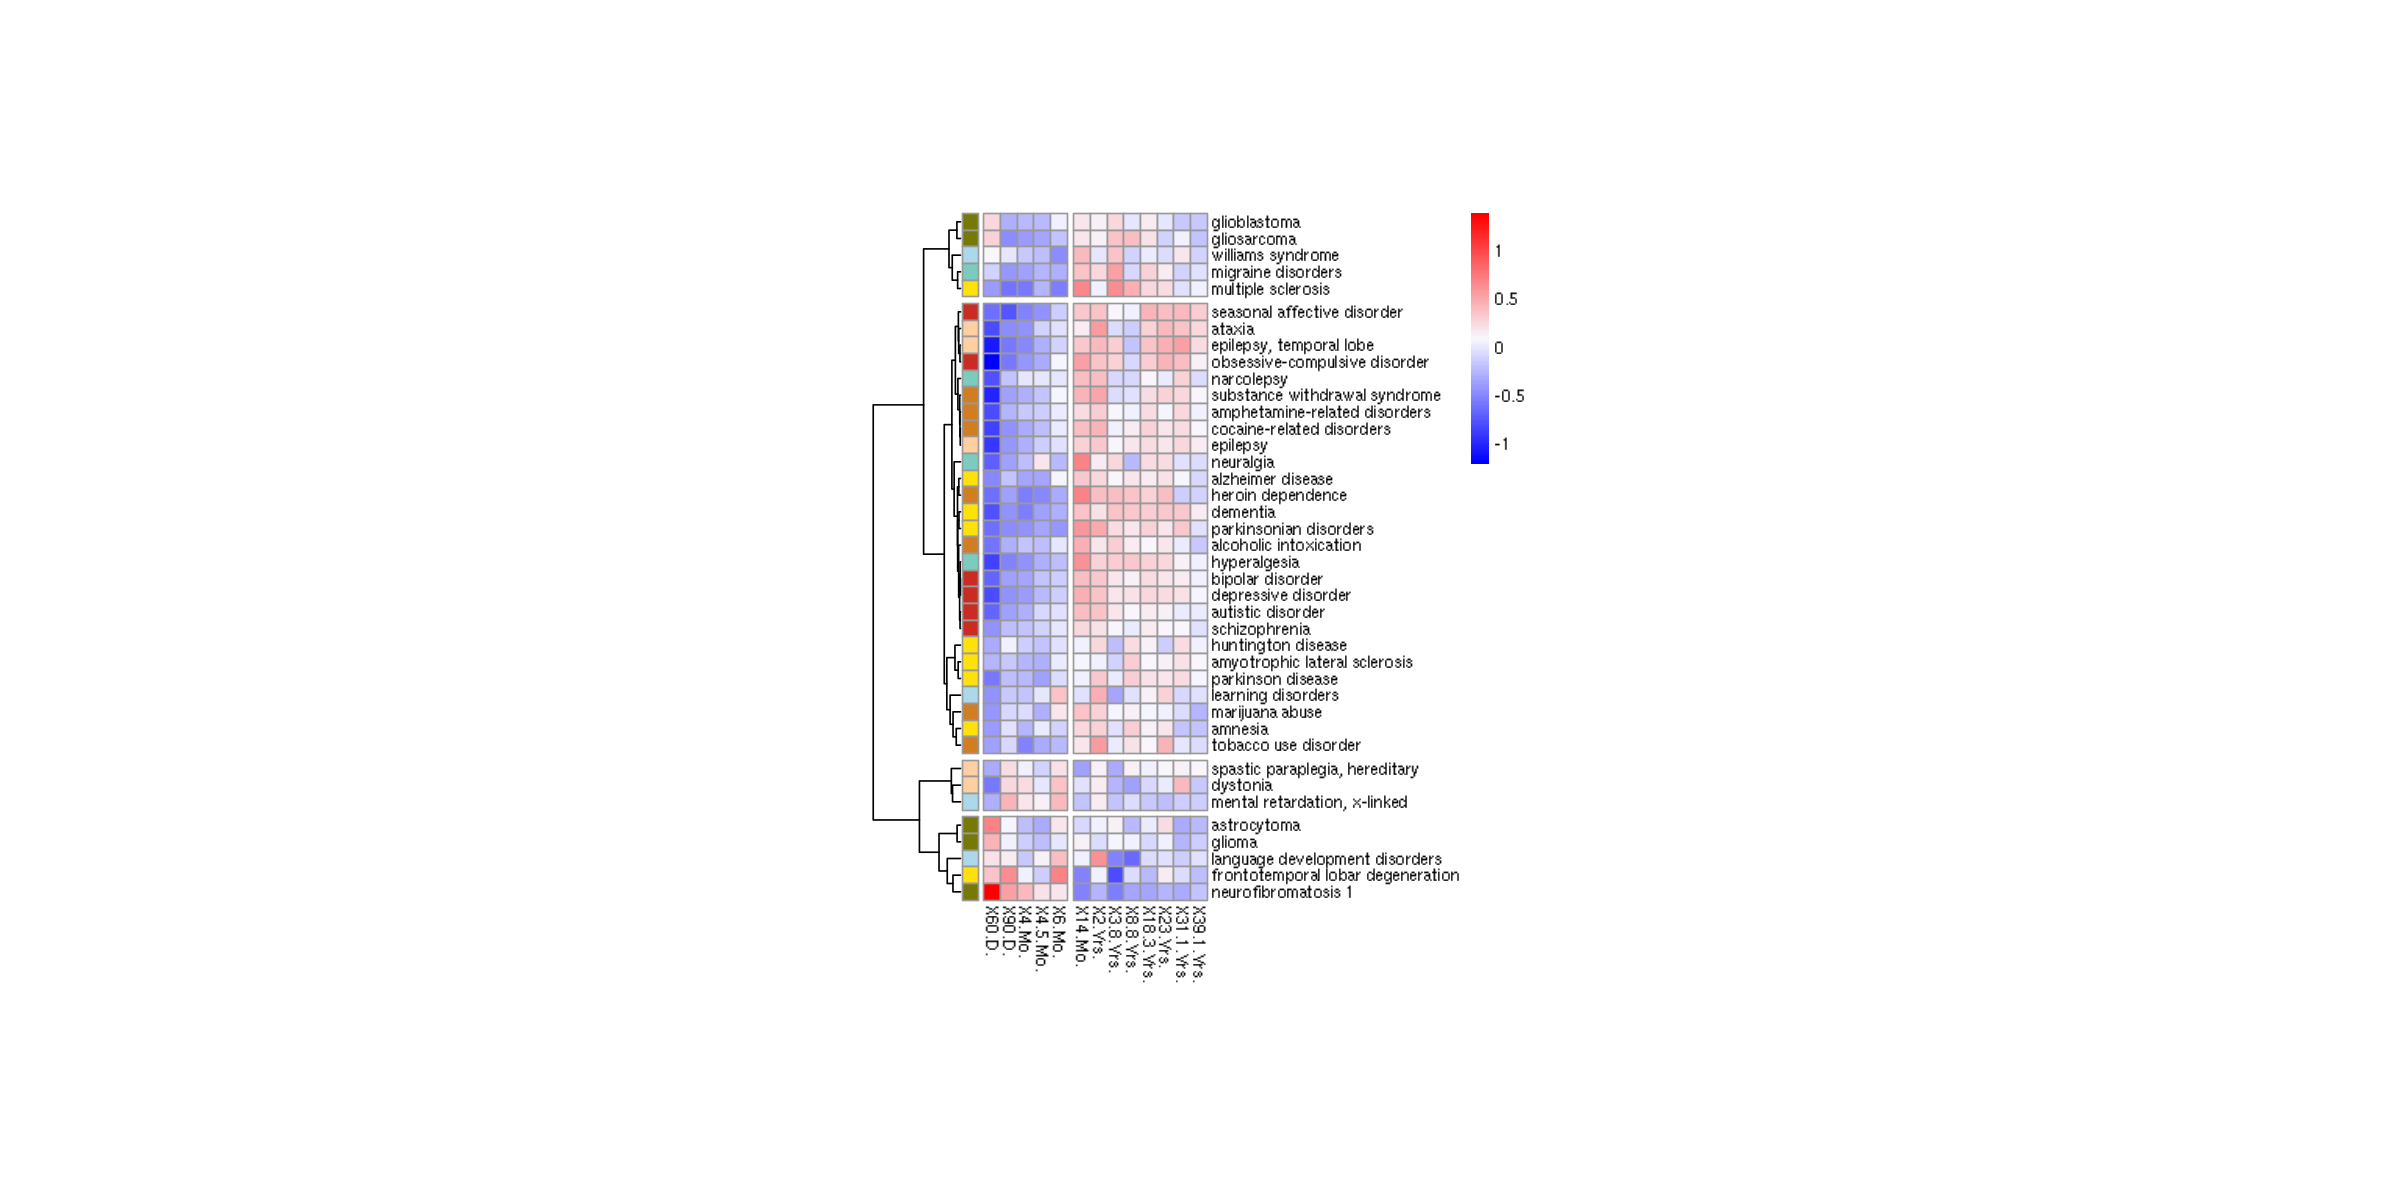

In [53]:
breaksList = seq(-1.5, 1.5, by = 3/length(hmcols))

pheatmap(Dis_Dev_matrix,color=hmcols,cluster_cols=F,
         cluster_rows=T,clustering_method = "ward.D2",clustering_distance_rows = "correlation",
         cutree_rows = 4,
         annotation_row=DiseaseAnno,annotation_names_row = F,
         annotation_colors=ann_colors,annotation_legend=F,
         cellwidth=10,cellheight=10,fontsize=10,gaps_col=c(5))

dev.off()
pdf(file = paste0(opath,'Supp_Fig_09.pdf'), width = 22, height = 15)
pheatmap(Dis_Dev_matrix,color=hmcols,cluster_cols=F,
         cluster_rows=T,clustering_method = "ward.D2",clustering_distance_rows = "correlation",
         cutree_rows = 4,
         annotation_row=DiseaseAnno,annotation_names_row = F,
         annotation_colors=ann_colors,annotation_legend=F,
         cellwidth=10,cellheight=10,fontsize=10,gaps_col=c(5))
dev.off()

## Supplementary Figure 11.   Expression levels of brain and non-brain diseases

### Supplementary Figure 11-A

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


null device 
          1

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


null device 
          1

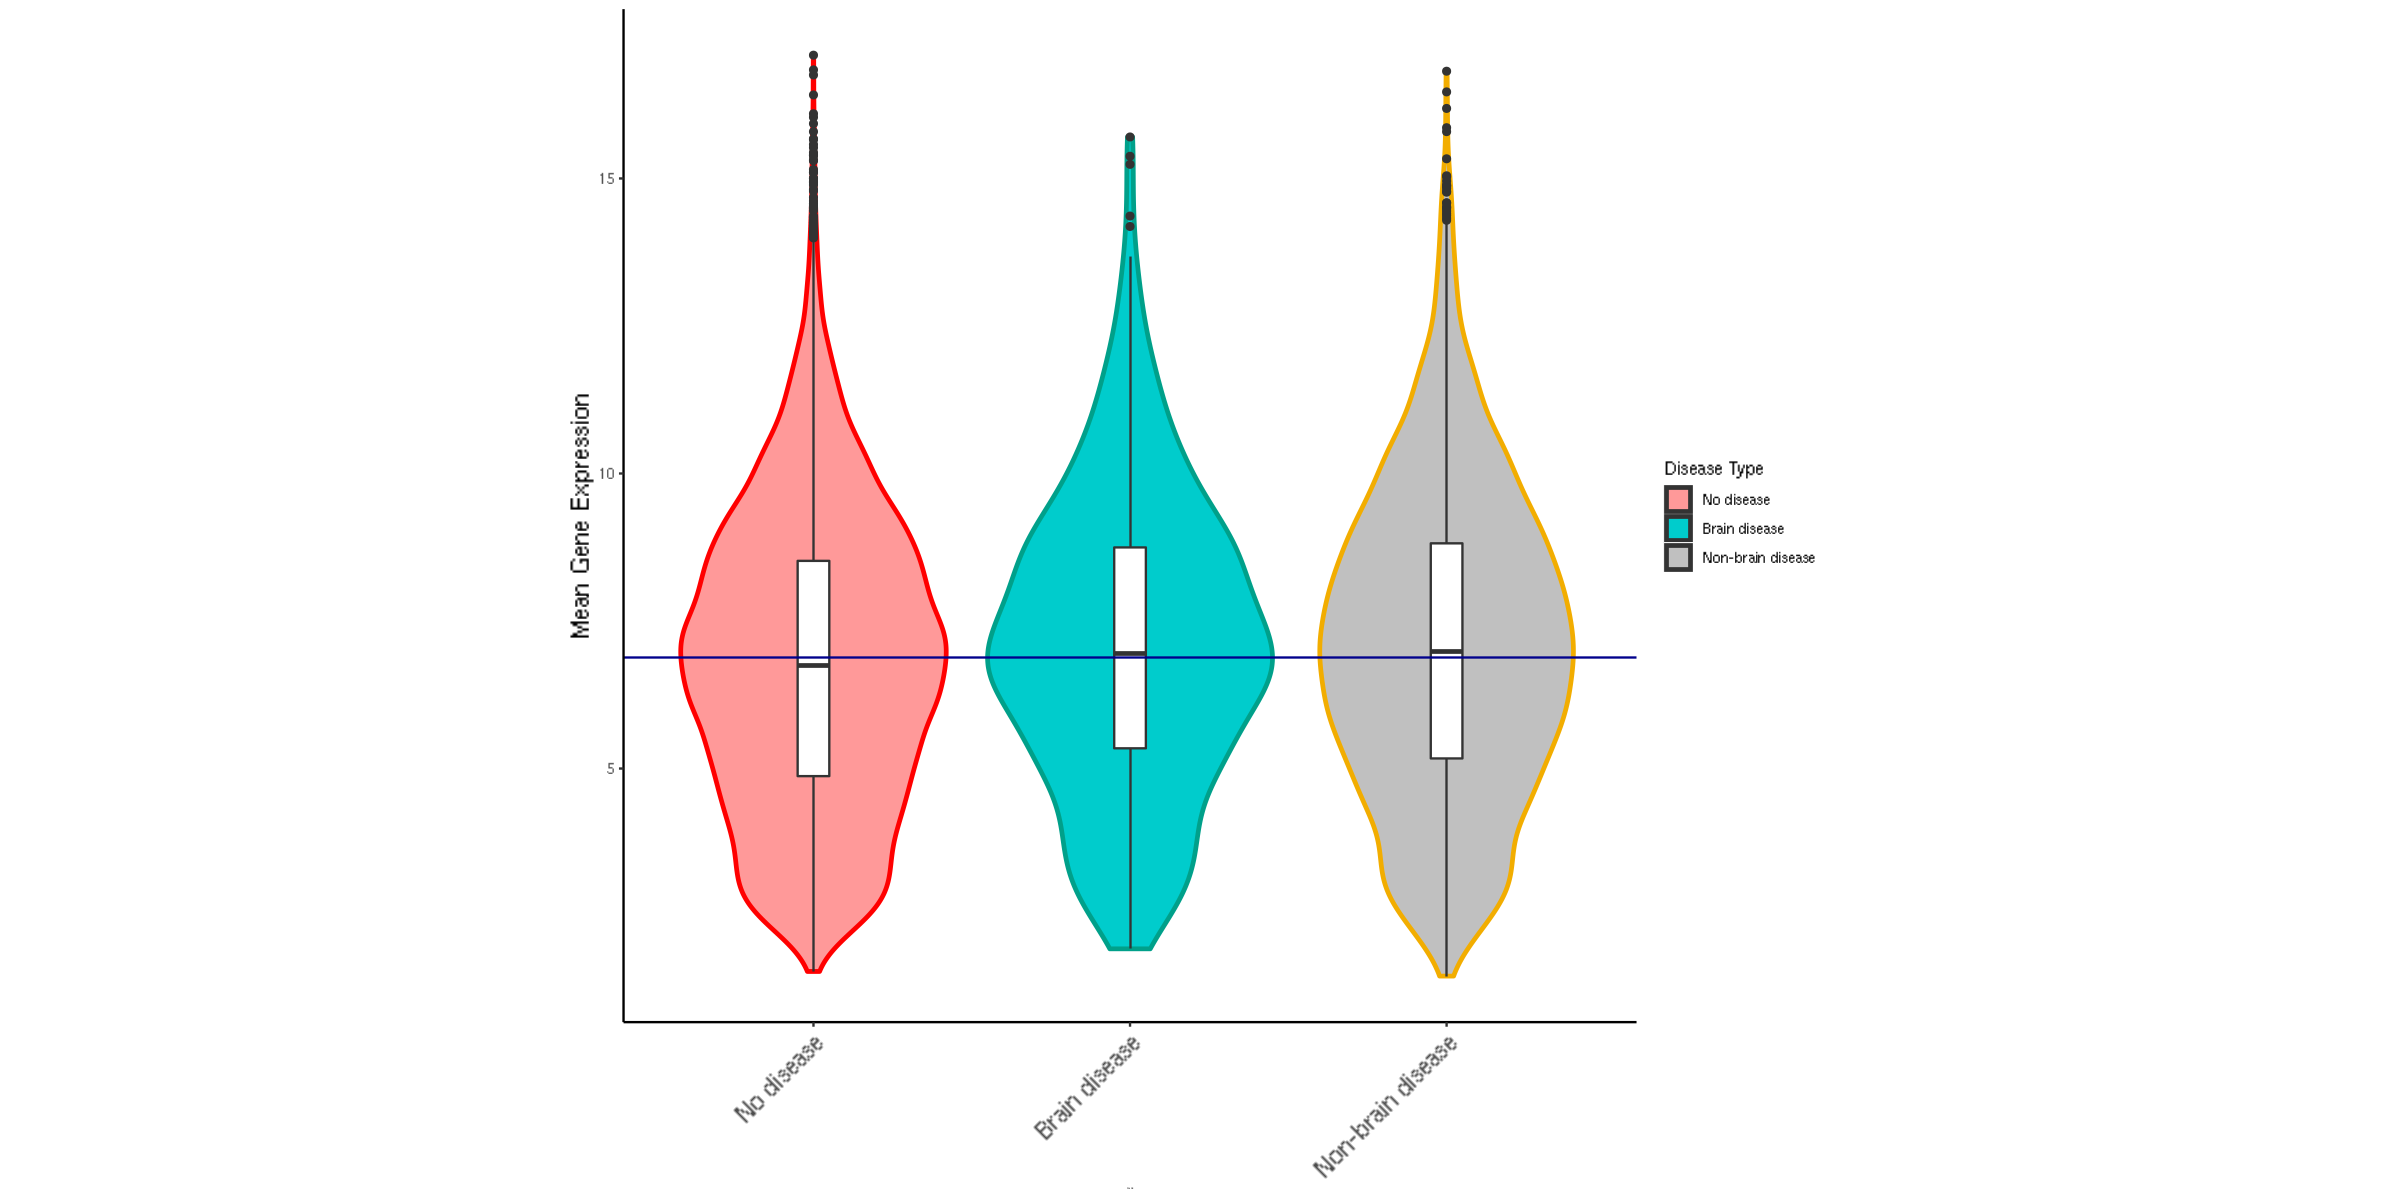

In [54]:
stabin=read.csv(paste(ipath,"DiffStab_dis.csv",sep=""))
stabin$dis_type <- factor(stabin$dis_type , levels=c("none", "brain", "non_brain", "Both"))

ggplot(data = stabin[!is.element(stabin$dis_type,c('Both')),],mapping = aes(x = dis_type,y = mean_Exp)) + 
    geom_violin(mapping = aes(x = dis_type,y = mean_Exp ,fill = dis_type,colour = dis_type),size = 1) +  
    theme(aspect.ratio = 1, axis.title.x = element_text(size=1),axis.title.y = element_text(size=15,angle=90),
          axis.text.x = element_text(size=15, angle = 45, hjust = 1)) +
    scale_color_manual(values = wes_palette(n=3, name="Darjeeling1")) +    
    scale_fill_manual(values = c('#FF9999','#00CCCC','#C0C0C0'), labels=c("No disease", "Brain disease", "Non-brain disease")) +
    scale_x_discrete(labels=c("No disease", "Brain disease", "Non-brain disease")) +
    geom_boxplot(mapping = aes(x = dis_type,y = mean_Exp),width=.1) + 
    geom_hline(yintercept = mean(stabin$mean_Exp),color = 'darkblue',size=.5) + 
    guides(fill=guide_legend(title="Disease Type"),colour = FALSE) + 
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
    panel.background = element_blank(), axis.line = element_line(colour = "black")) +
    labs(x = FALSE, y = 'Mean Gene Expression')

dev.off()
pdf(paste(opath,"Supplementary_Figure_11_A.pdf",sep=""),width=7,height=7)
ggplot(data = stabin[!is.element(stabin$dis_type,c('Both')),],mapping = aes(x = dis_type,y = mean_Exp)) + 
    geom_violin(mapping = aes(x = dis_type,y = mean_Exp ,fill = dis_type,colour = dis_type),size = 1) +  
    theme(aspect.ratio = 1, axis.title.x = element_text(size=1),axis.title.y = element_text(size=15,angle=90),
          axis.text.x = element_text(size=15, angle = 45, hjust = 1)) +
    scale_color_manual(values = wes_palette(n=3, name="Darjeeling1")) +    
    scale_fill_manual(values = c('#FF9999','#00CCCC','#C0C0C0'), labels=c("No disease", "Brain disease", "Non-brain disease")) +
    scale_x_discrete(labels=c("No disease", "Brain disease", "Non-brain disease")) +
    geom_boxplot(mapping = aes(x = dis_type,y = mean_Exp),width=.1) + 
    geom_hline(yintercept = mean(stabin$mean_Exp),color = 'darkblue',size=.5) + 
    guides(fill=guide_legend(title="Disease Type"),colour = FALSE) + 
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
    panel.background = element_blank(), axis.line = element_line(colour = "black")) +
    labs(x = FALSE, y = 'Mean Gene Expression')
dev.off()

In [55]:
stabin_cell=read.csv(paste(ipath,"DiffStab_dis_cell.csv",sep=""))
stabin_cell$dis_type <- factor(stabin_cell$dis_type , levels=c("none", "brain", "non_brain", "Both"))
inord=read.csv(paste(ipath,"all_orders_3000_10_40.csv",sep=""))
levels(inord$disease_type) <- c("Developmental","Movement","Neurodegenerative",
                                "Brain Related","Psychiatric","Substance","Brain Tumors")
inord$color <- colp[match(inord$disease_type,names(colp))]

In [56]:
df <- stack(setNames(glists, names(glists)))
colnames(df) <- c('genes','disease')
df <- df[,c(2,1)]
df$value <- stabin_cell$stability[match(df$genes,stabin_cell$gene_symbol)]
df <- df[-which(is.na(df$value)),]
df$type <- inord$disease_type[match(df$disease,inord$alphabetical_disease)]
df$color <- colp[match(df$type,names(colp))]
out <- aggregate(value~disease,df,median)

### Supplementary Figure 11-B

null device 
          1

null device 
          1

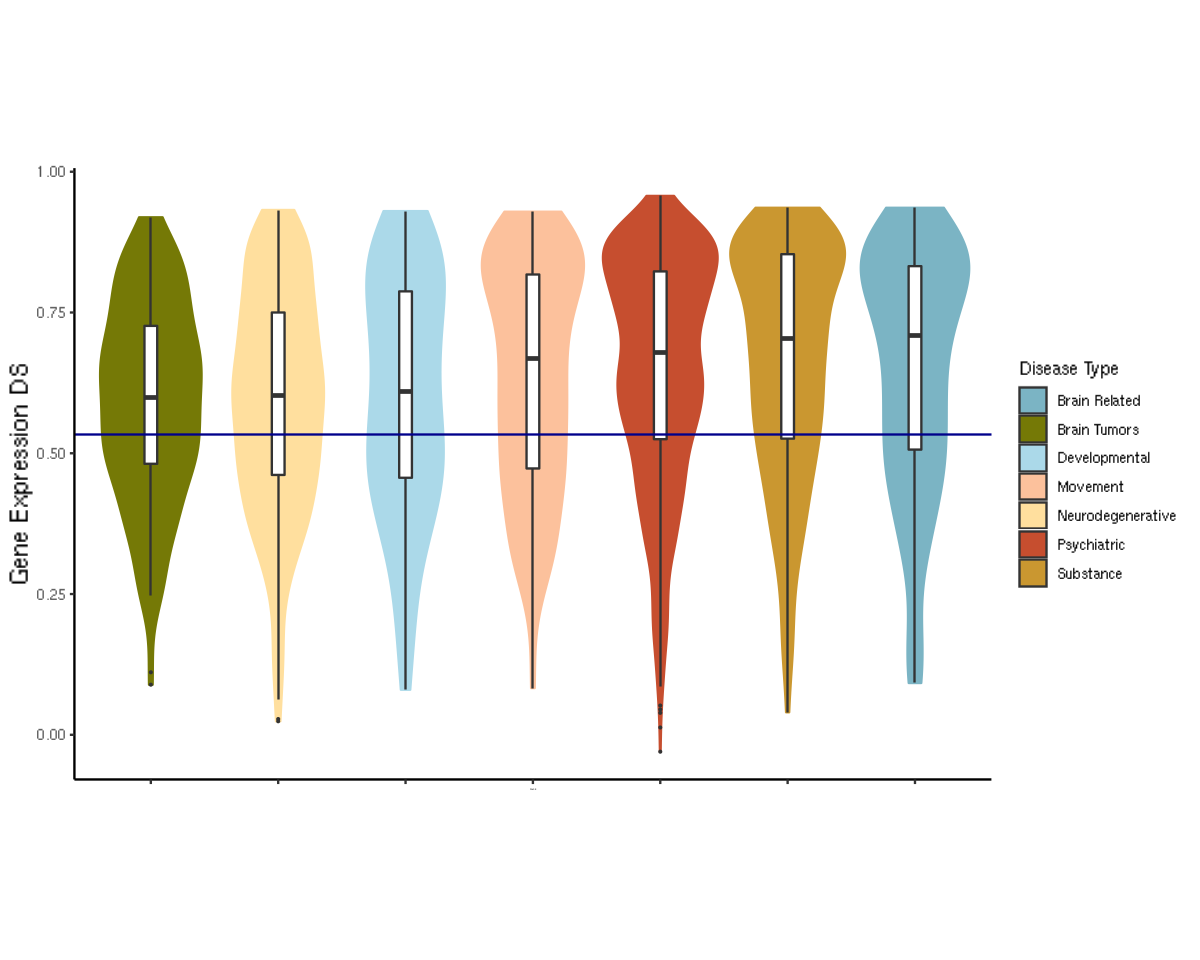

In [57]:
options(repr.plot.width=10, repr.plot.height=8)
ggplot(data = df) + 
        geom_violin(mapping = aes(x = reorder(type, value, FUN=median),y = value,fill = type, colour = type))+
        theme(aspect.ratio = 1/1.5, axis.title.x = element_text(size=1),
        axis.title.y = element_text(size=15,angle=90),axis.text.x = element_blank()) +
        scale_fill_manual(values = colp[order(names(colp))])+ 
        scale_color_manual(values = colp[order(names(colp))])+
        geom_boxplot(mapping = aes(x = type,y = value),width=.1, outlier.size = .1)+
        geom_hline(yintercept = mean(stabin_cell$stability),color = 'darkblue',size=.5) +
        guides(fill=guide_legend(title="Disease Type"),colour = "none") + 
        theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        panel.background = element_blank(), axis.line = element_line(colour = "black")) +
        labs(x = FALSE, y = 'Gene Expression DS')

dev.off()
pdf(paste(opath,"Supplementary_Figure_11_B.pdf",sep=""),width=8,height=8)
ggplot(data = df) + 
        geom_violin(mapping = aes(x = reorder(type, value, FUN=median),y = value,fill = type, colour = type))+
        theme(aspect.ratio = 1/1.5, axis.title.x = element_text(size=1),
        axis.title.y = element_text(size=15,angle=90),axis.text.x = element_blank()) +
        scale_fill_manual(values = colp[order(names(colp))])+ 
        scale_color_manual(values = colp[order(names(colp))])+
        geom_boxplot(mapping = aes(x = type,y = value),width=.1, outlier.size = .1)+
        geom_hline(yintercept = mean(stabin_cell$stability),color = 'darkblue',size=.5) +
        guides(fill=guide_legend(title="Disease Type"),colour = "none") + 
        theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        panel.background = element_blank(), axis.line = element_line(colour = "black")) +
        labs(x = FALSE, y = 'Gene Expression DS')
dev.off()

### Supplementary Figure 11-C

In [58]:
options(repr.plot.width=12, repr.plot.height=12)

ggplot(data = df) + 
        geom_boxplot(mapping = aes(x = reorder(disease, value, FUN=median),y = value),fill = inord$color[order(out$value)],size=.3) + 
        geom_hline(yintercept = mean(stabin_cell$stability),color = 'red',size = .3) + 
        coord_flip() +
        theme(aspect.ratio = 3,axis.text.x = element_text(angle = 90, hjust = 1, size = 10),axis.text.y = element_text(size = 12),
        axis.title.x = element_text(size=15),panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),panel.background = element_blank(), axis.line = element_line(colour = "black")) +
            labs(y = 'Gene Expression Stability', x = '')

dev.off()
pdf(paste(opath,"Supplementary_Figure_11_C.pdf",sep=""),width=12,height=12)
ggplot(data = df) + 
        geom_boxplot(mapping = aes(x = reorder(disease, value, FUN=median),y = value),fill = inord$color[order(out$value)],size=.3) + 
        geom_hline(yintercept = mean(stabin_cell$stability),color = 'red',size = .3) + 
        coord_flip() +
        theme(aspect.ratio = 3,axis.text.x = element_text(angle = 90, hjust = 1, size = 10),axis.text.y = element_text(size = 12),
        axis.title.x = element_text(size=15),panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),panel.background = element_blank(), axis.line = element_line(colour = "black")) +
            labs(y = 'Gene Expression Stability', x = '')
dev.off()

null device 
          1

null device 
          1

In [59]:
HS_disease_order <- names(sort(tapply(df$value, df$disease, median),decreasing = TRUE))

## Supplementary Figure 12.   Anatomic markers for DS genes

In [60]:
expression_mat_HS=read.csv(paste(ipath,"HBA_Disease_high_stability_genes.csv",sep=""))
rownames(expression_mat_HS) <- expression_mat_HS[,1];expression_mat_HS <- expression_mat_HS[,-1]
expression_mat_LS=read.csv(paste(ipath,"HBA_Disease_low_stability_genes.csv",sep=""))
rownames(expression_mat_LS) <- expression_mat_LS[,1];expression_mat_LS <- expression_mat_LS[,-1]

In [61]:
gene_list_HS <- tolower(c("BCL11A","HTR2A","HTR2C","HTR2A","GABBR2","GABRA4","HTR2C","GRIA2","SLC17A7","CAMK2A",
                 "PDYN","HPSE2","STX1A","AK5","CAMK2A","MEF2C","GABRA6","NRGN","PRL",
                 "CNR1","PENK","NRGN","DAO","NDRG1","PENK","GABRA2","ANO3","SPP1","KITLG",
                 "GABRA2","TES","ANO3","TF","CNR1","SLC6A3","PLP1","FGFR1","DLG3","TBK1","LIMK1"))
gene_list_LS <- tolower(c("PTEN","SLC1A1","CYP17A1","LYSMD3","GRM2","CACNA1A","OPN4","OPRD1","NF1","NGF",
                 "NGF","ARMS2","C3ORF58","PDE6C","CNR2","FLNA","AANAT","C14ORF28","NGF",
                 "OGG1","TNFSF4","APOA4","C21ORF2","NF1","CNR2","MTHFR","THAP1","HIST1H3J","PMS2",
                 "RETN","NOTCH3","C19ORF12","SLC30A6","SELE","SLC9A8","C12ORF65","CYP2B6","CXORF36","C9ORF72","FKBP6"))

In [62]:
BrainAnno <- data.frame(BrainStruct = factor(as.character(humont$acronym)))
rownames(BrainAnno) <- as.character(humont$acronym)

DiseaseAnno <- data.frame(DiseaseStruct = factor(as.character(inord$alphabetical_disease)))
rownames(DiseaseAnno) <- as.character(inord$alphabetical_disease)

ann_colors = list(BrainStruct=paste("#",as.character(humont$Color),sep=""),
                 DiseaseStruct=inord$color)
names(ann_colors$BrainStruct)=as.character(humont$acronym)
names(ann_colors$DiseaseStruct)=as.character(inord$alphabetical_disease)

In [63]:
ann_colors_HS <- ann_colors
names(ann_colors_HS$DiseaseStruct) <- gene_list_HS[match(names(ann_colors$DiseaseStruct),HS_disease_order)]
ann_colors_LS <- ann_colors
names(ann_colors_LS$DiseaseStruct) <- gene_list_LS[match(names(ann_colors$DiseaseStruct),HS_disease_order)]

HS_Anno <- data.frame(DiseaseStruct = gene_list_HS[-which(duplicated(gene_list_HS))])
rownames(HS_Anno) <- gene_list_HS[-which(duplicated(gene_list_HS))]
LS_Anno <- data.frame(DiseaseStruct = gene_list_LS[-which(duplicated(gene_list_LS))])
rownames(LS_Anno) <- gene_list_LS[-which(duplicated(gene_list_LS))]

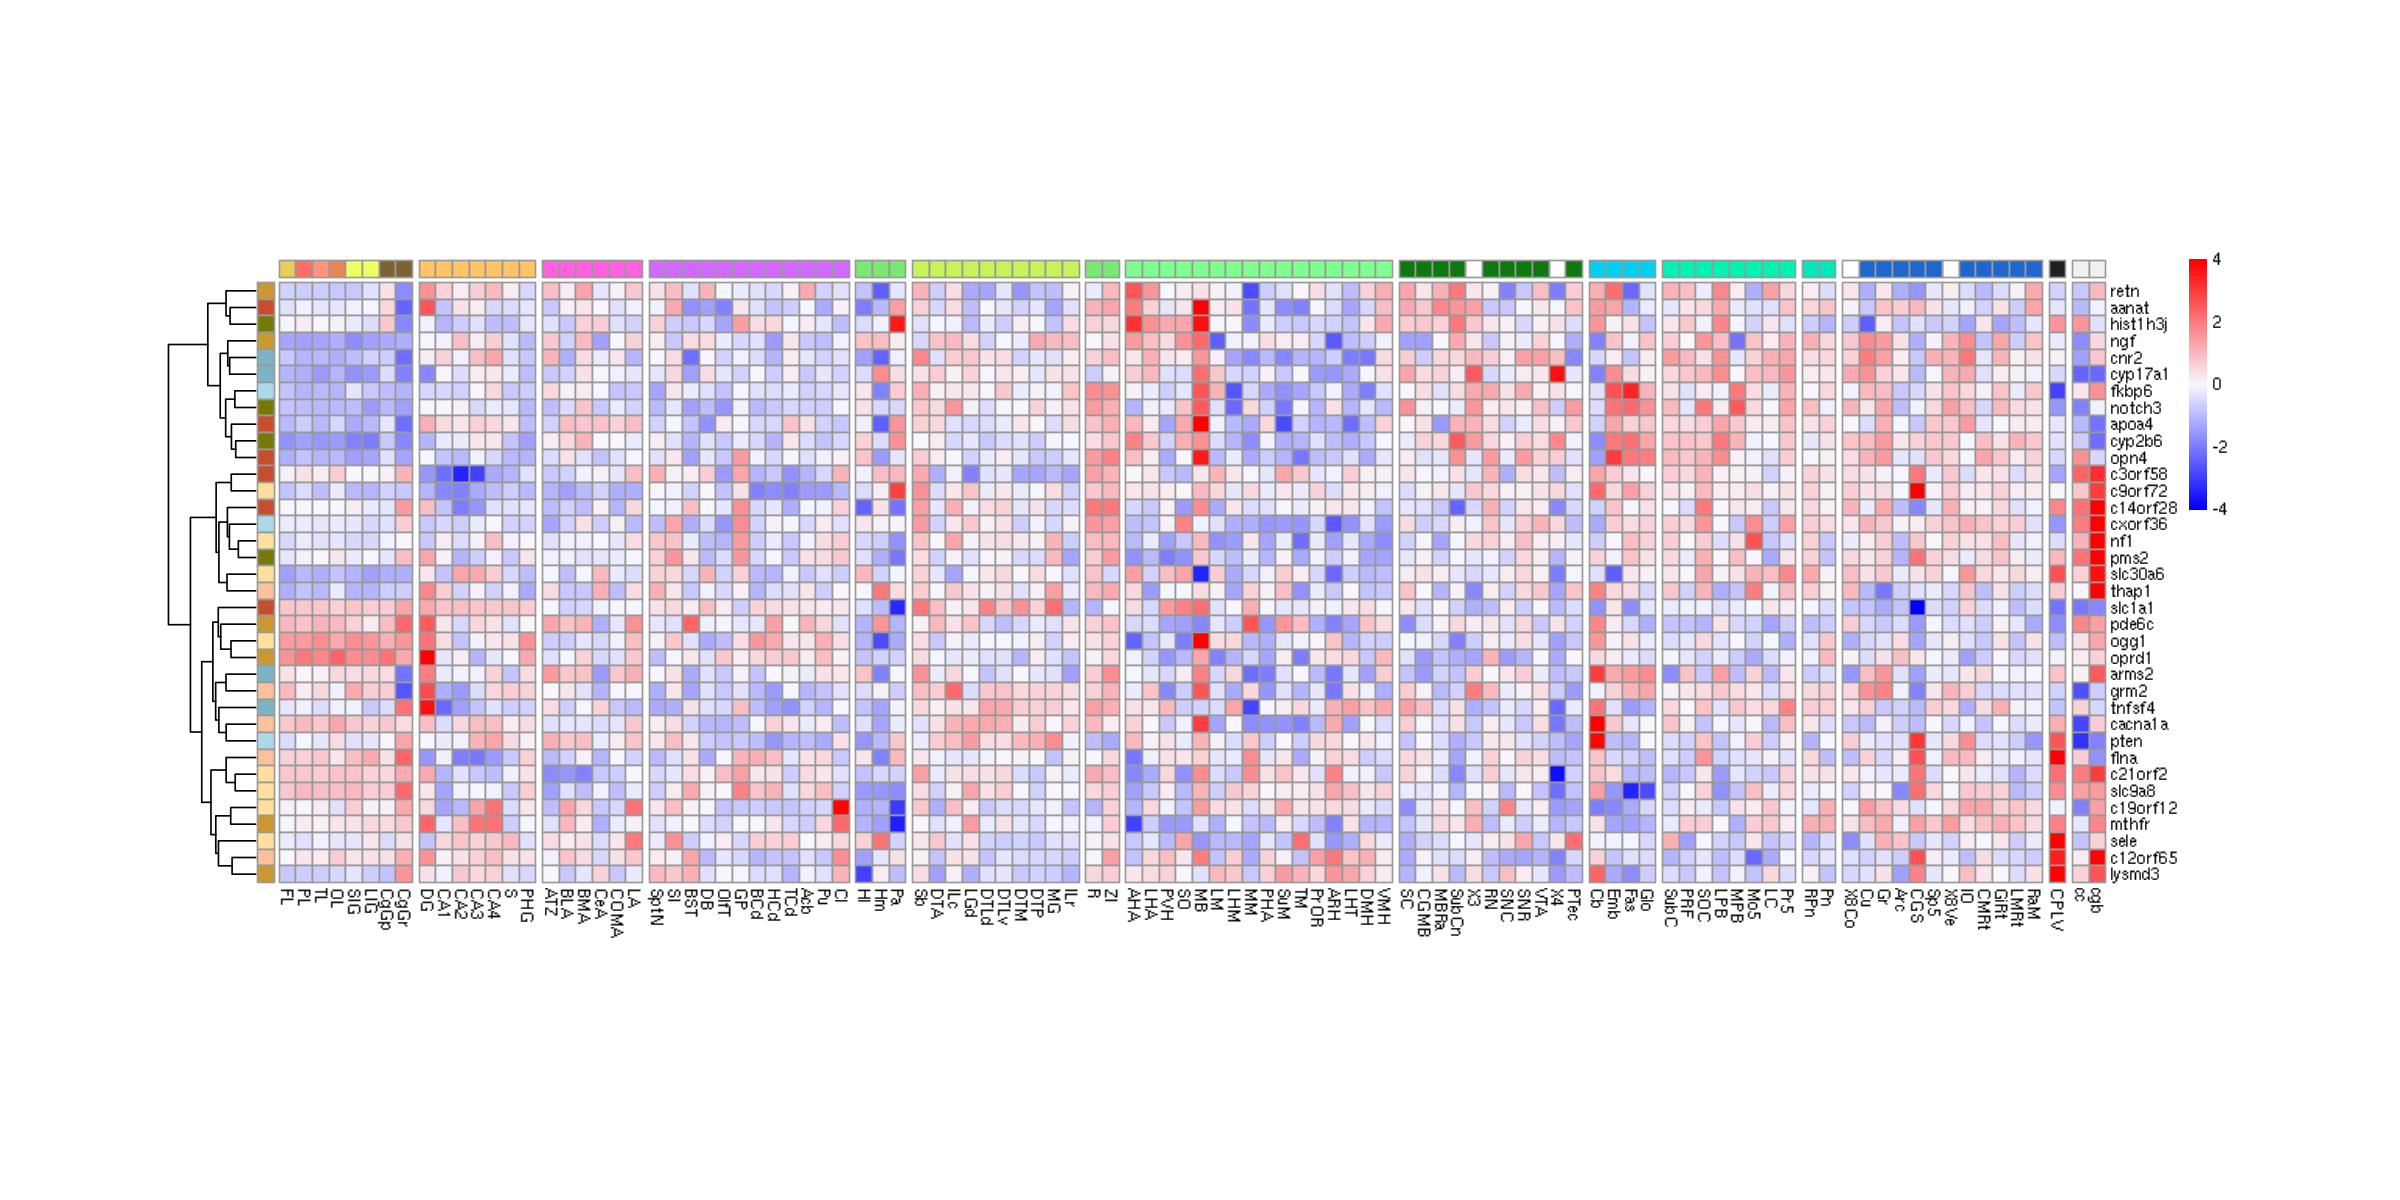

null device 
          1

null device 
          1

null device 
          1

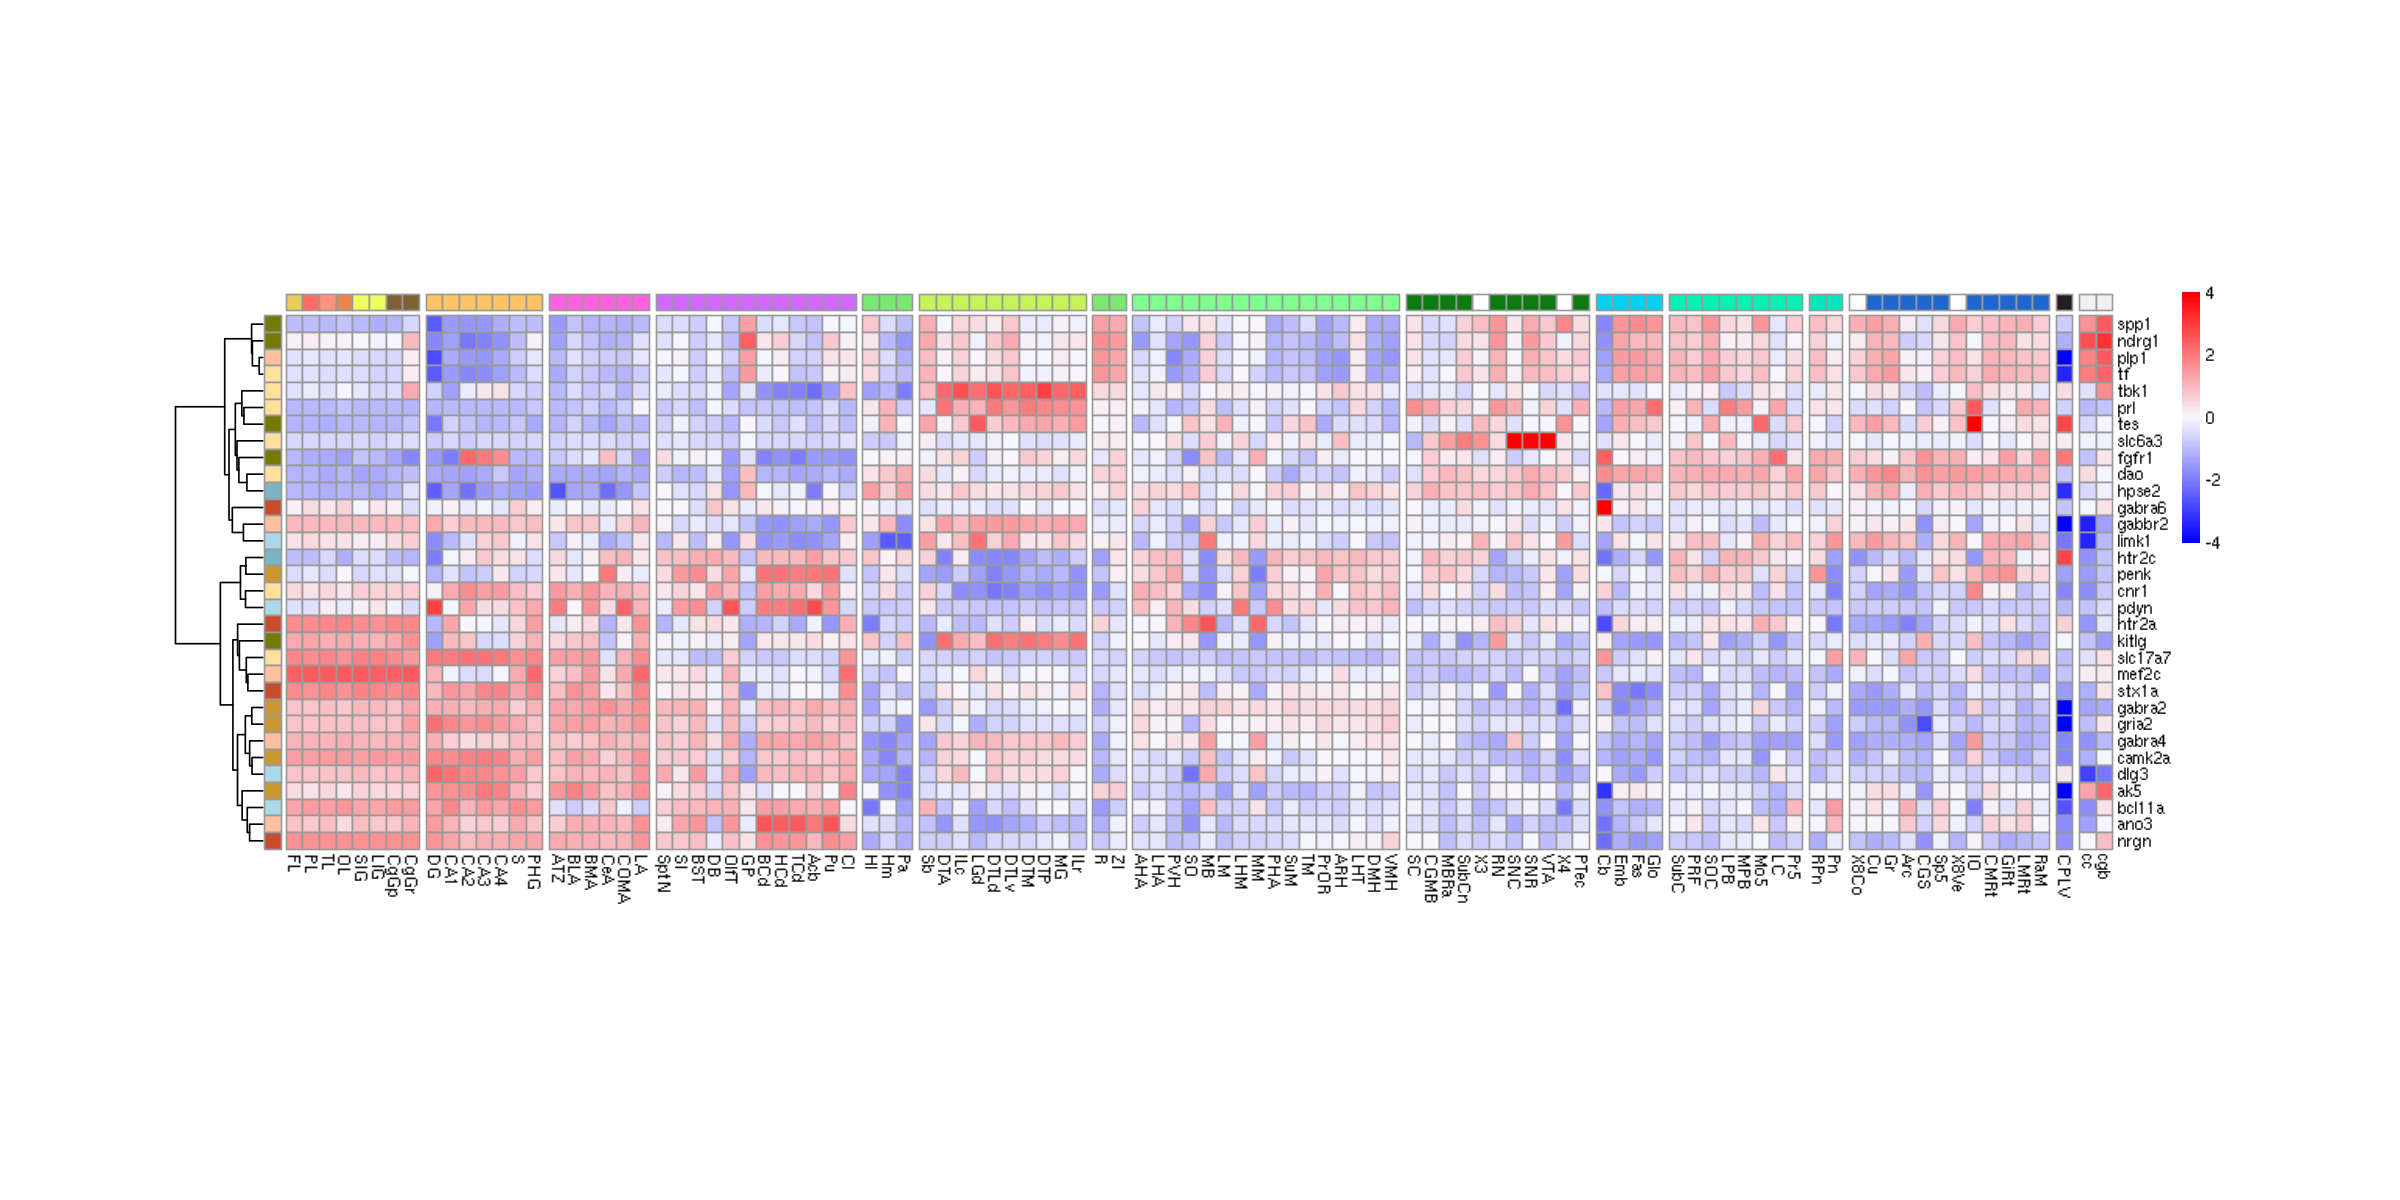

In [64]:
options(repr.plot.width=20, repr.plot.height=10)

breaksList = seq(-4,4, by = 8/length(hmcols))


pheatmap(expression_mat_LS,color=hmcols,breaks = breaksList,cluster_cols=F,
         cluster_rows=T,clustering_method = "ward.D2",
         annotation_col=BrainAnno,annotation_legend=F,cellwidth=10,cellheight=10,fontsize=10,
         annotation_row=LS_Anno,annotation_names_row = F,
         annotation_colors=ann_colors_LS,
         annotation_names_col=F,gaps_col=HBA_region_gaps)

pheatmap(expression_mat_HS,color=hmcols,breaks = breaksList,cluster_cols=F,
         cluster_rows=T,clustering_method = "ward.D2",
         annotation_col=BrainAnno,annotation_legend=F,cellwidth=10,cellheight=10,fontsize=10,
         annotation_row=HS_Anno,annotation_names_row = F,
         annotation_colors=ann_colors_HS,
         annotation_names_col=F,gaps_col=HBA_region_gaps)

dev.off()
pdf(file = paste0(opath,'Supp_Fig_12_LS.pdf'), width = 22, height = 15)
pheatmap(expression_mat_LS,color=hmcols,breaks = breaksList,cluster_cols=F,
         cluster_rows=T,clustering_method = "ward.D2",
         annotation_col=BrainAnno,annotation_legend=F,cellwidth=10,cellheight=10,fontsize=10,
         annotation_row=LS_Anno,annotation_names_row = F,
         annotation_colors=ann_colors_LS,
         annotation_names_col=F,gaps_col=HBA_region_gaps)
dev.off()
pdf(file = paste0(opath,'Supp_Fig_12_HS.pdf'), width = 22, height = 15)
pheatmap(expression_mat_HS,color=hmcols,breaks = breaksList,cluster_cols=F,
         cluster_rows=T,clustering_method = "ward.D2",
         annotation_col=BrainAnno,annotation_legend=F,cellwidth=10,cellheight=10,fontsize=10,
         annotation_row=HS_Anno,annotation_names_row = F,
         annotation_colors=ann_colors_HS,
         annotation_names_col=F,gaps_col=HBA_region_gaps)
dev.off()

# Figure 2. Reproducible transcription patterns in human brain diseases

In [65]:
indir=paste(ipath,"individual_gda/",sep="")
infiles=list.files(indir)

disordin=read.csv(paste(ipath,"all_orders_3000_10_40.csv",sep=""))
disord=as.character(disordin[,6])
discat=as.character(disordin[,4])
disind=as.numeric(disordin[,8])

tlist=unlist(strsplit(infiles,"\\."))[seq(1,130,2)][1:40]

# stability data from Canonical Transcription Networks
stabin=read.csv(paste(ipath,"DiffStab_dis.csv",sep=""))
stabin$dis_type <- factor(stabin$dis_type , levels=c("none", "brain", "non_brain", "Both"))

gslist=as.character(stabin$gene_symbol)
gstab=as.numeric(stabin$stability)


stablist=NULL
for (i in 1:length(glists)) {
  stablist[[i]]=vector("numeric",length(glists[[i]]))
  for (j in 1:length(glists[[i]])) {
    ips=which(gslist==glists[[i]][j])
    if (length(ips)>0) {stablist[[i]][j]=gstab[ips]}
  }
}

# how many exceed median and t-test
disfracnt=vector("numeric",disnum)
names(disfracnt)=disnames
for (i in 1:disnum) {
  disfracnt[i]=sum(stablist[[i]]>median(gstab))/length(stablist[[i]]) 
}
# sort(disfracnt,decreasing=T)



# min and max DS by disease
for (i in 1:length(stablist)) {
  imin=which(stablist[[i]]==min(stablist[[i]]))
  imax=which(stablist[[i]]==max(stablist[[i]]))
#   print (c(tlist[i],glists[[i]][imin],stablist[[i]][imin],glists[[i]][imax],stablist[[i]][imax]))
}

lenvec=vector("numeric",length(stablist))
medvec=vector("numeric",length(stablist))

# test for correlation of stability and gene set size 
for (i in 1:length(stablist)) {
  lenvec[i]=length(stablist[[i]])
  medvec[i]=median(stablist[[i]])
}
cor(lenvec,medvec)
mmod=summary(lm(medvec~lenvec))
 
# ADG grops and DE lists
cord=NULL
for (i in 1:4) {
  cord[[i]]=which(inord$HBA_modules_overlap==i) 
}

stabclus=NULL
adglen=vector("numeric",4)
for (i in 1:4) {
  stabtemp=NULL
  for (j in 1:length(cord[[i]])) {
    stabtemp=c(stabtemp,stablist[[cord[[i]][j]]])
  }
  stabclus[[i]]=stabtemp
  adglen[i]=length(stabtemp)
#   print(paste("ADG",i,mean(stabclus[[i]]),median(stabclus[[i]])))
}

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


[1] 0.02307119

In [66]:
# GBD order and DE lists
word=NULL
for (i in 1:7) {
  word[[i]]=as.numeric(which(dclass==i))
}

stabgbd=NULL
meangbd=vector("numeric",7)
medgbd=vector("numeric",7)
names(meangbd)=names(colp)
names(medgbd)=names(colp)
gbdlen=vector("numeric",7)
names(gbdlen)=names(colp)
for (i in 1:7) {
  stabtemp=NULL
  for (j in 1:length(word[[i]])) {
    stabtemp=c(stabtemp,stablist[[word[[i]][j]]])
  }
  stabgbd[[i]]=stabtemp
  gbdlen[i]=length(stabtemp)
  meangbd[i]=mean(stabtemp)
  medgbd[i]=median(stabtemp)
}

# Test stability against background - ADG
pvclus=vector("numeric",4)
bootnum=10000
for (i in 1:length(cord))  {
#   print(paste("Boostrap ADG",i))
  for (j in 1:bootnum) {
    # use fixed size 200 for ADG 3
    tsamp=sample(gstab,length(stabclus[[i]]))
    if (i==3) {tsamp=sample(gstab,200)}
    pvclus[i]=pvclus[i]+t.test(tsamp,stabclus[[i]])$p.value
  }
  pvclus[i]=pvclus[i]/bootnum
}

# Test stability against background - ADG
pvgbd=vector("numeric",7)
bootnum=10000
names(pvgbd)=names(colp)
for (i in 1:length(word))  {
  print(paste("Boostrap",names(colp[i]),i))
  for (j in 1:bootnum) {
    tsamp=sample(gstab,length(stabgbd[[i]]))
    if (i==1) {tsamp=sample(gstab,200)}
    pvgbd[i]=t.test(tsamp,stabgbd[[i]])$p.value
  }
  pvgbd[i]=pvgbd[i]/bootnum
}

# order stability list by disease,  and compare to marker identifiability
mdisstab=vector("numeric",length(stablist))
names(mdisstab)=disnames
for (i in 1:length(stablist)) {
  mdisstab[i]=mean(stablist[[i]])
}

numean=vector("numeric",6)
for (i in 1:6) {
  ips=which(numvec==i)
  numean[i]=mean(mdisstab[ips])
}

options(repr.plot.width=7, repr.plot.height=5)
ordss=order(mdisstab,decreasing=TRUE) 
ordmark=numvec[ordss]
cor(ordmark,mdisstab[ordss])

[1] "Boostrap Psychiatric 1"
[1] "Boostrap Substance 2"
[1] "Boostrap Movement 3"
[1] "Boostrap Neurodegenerative 4"
[1] "Boostrap Brain Tumors 5"
[1] "Boostrap Developmental 6"
[1] "Boostrap Brain Related 7"


[1] 0.04776671

In [67]:
# Write out DE and modules for disease genes

modin=read.csv(paste(ipath,"GeneModuleCorrelations.csv",sep=""))

gmlist=as.character(modin[,2])
gmodlist=as.character(modin[,4])
gcorlist=as.numeric(modin[,6])

outl=NULL
for (i in 1:length(glists)) {
  for (j in 1:length(glists[[i]])) {
    ip=which(gmlist==glists[[i]][j])
    if (length(ip)>0) {
      outl=rbind(outl,c(as.character(disnames[i]),glists[[i]][j],stablist[[i]][j],gmodlist[ip],gcorlist[ip]))
    }
    if (length(ip)==0) {
      outl=rbind(outl,c(as.character(disnames[i]),glists[[i]][j],stablist[[i]][j],"NA","NA"))
    }
  }
}
outdf=as.data.frame(outl)
write.csv(outdf,paste(opath,"Supplementary_Table_5_DE_Disease_Genes.csv",sep=""))

# min and max DE genes by disease
mmmat=as.data.frame(matrix(0,40,2,dimnames=list(disnames,c("Min DS","Max DS"))))
for (i in 1:length(disnames)) {
  ipmin=which(stablist[[i]]==min(stablist[[i]]))[1]
  mmmat[i,1]=glists[[i]][ipmin]
  ipmax=which(stablist[[i]]==max(stablist[[i]]))[1]
  mmmat[i,2]=glists[[i]][ipmax]
}

write.csv(mmmat,paste(opath,"Supplementary_Table_MinMaxDS.csv",sep=""))
# module assignment by ADG 

avgmodcor=vector("numeric",disnum)
for (i in 1:disnum) {
  ip=which(outdf[,1]==disnames[i])
  itab=as.numeric(outdf[ip,5])
  avgmodcor[i]=mean(itab[!is.na(itab)])
} 

adgmodcor=vector("numeric",4)
for (i in 1:4) {
  adgmodcor[i]=mean(avgmodcor[hbaclus==i])
}

gbdmodcor=vector("numeric",length(colp))
for (i in 1:length(colp)) {
  gbdmodcor[i]=mean(avgmodcor[dclass==i])
}


getDiseases<-function(genename)  {
  # disease a given gene is associated with
  disl=NULL
  for (i in 1:length(glists)) {
    if (genename %in% glists[[i]]) {
      ip=which(gmlist==genename)
      disl=rbind(disl,disnames[i],tlist[i],gmodlist[ip],gcorlist[ip])}
  }
  return (disl)
}

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(e

### Figure 2-C

null device 
          1

null device 
          1

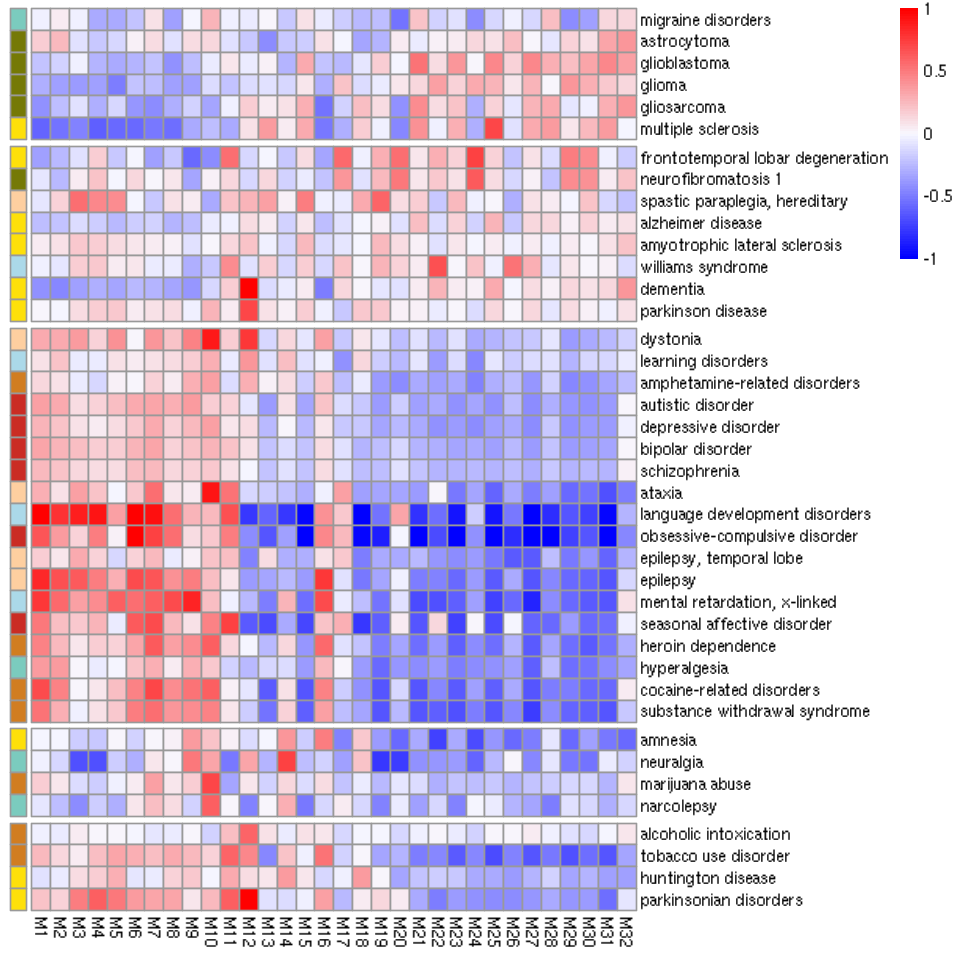

In [68]:
# testing ADG group module significance
inmod=read.csv(paste(ipath,"Disease_modules_normalized_overlap.csv",sep=""))
modmat=as.matrix(inmod[,2:dim(inmod)[2]])
rownames(modmat)=as.character(inmod[,1])
uthresh=5
for (i in 1:disnum) {
  for (j in 1:32) {
    if (modmat[i,j]>uthresh) {modmat[i,j]=uthresh}
  }
}

options(repr.plot.width=8, repr.plot.height=8)
breaksList = seq(-1, 1, by = 2/length(hmcols))
pheatmap(modmat,cluster_rows=F,cluster_cols=F,col=hmcols,breaks = breaksList,gaps_row=c(6,14,32,36),
         annotation_legend=F,
         annotation_row=DiseaseAnno,annotation_names_row = F,
         annotation_colors=ann_colors_d,
         annotation_names_col=F)

dev.off()
pdf(paste(opath,"Figure_02_C.pdf",sep=""),width=8,height=8)
pheatmap(modmat,cluster_rows=F,cluster_cols=F,col=hmcols,breaks = breaksList,gaps_row=c(6,14,32,36),
         annotation_legend=F,
         annotation_row=DiseaseAnno,annotation_names_row = F,
         annotation_colors=ann_colors_d,
         annotation_names_col=F)
dev.off()

In [69]:
maxvals=apply(modmat,2,max)
minds=vector("integer",32)
for (j in 1:32) {
 minds[j]=which(modmat[,j]==maxvals[j])
}
for (j in 1:32) {
#   print(paste(colnames(modmat)[j],rownames(modmat)[minds[j]]))
}

#  testing ADG 1 for glial enrichment M21-M21
splmark=21 
tgroup1=as.vector(modmat[1:6,1:(splmark-1)])
tgroup2=as.vector(modmat[1:6,splmark:32])
t.test(tgroup1,tgroup2)


#  ADG 3 for neuronal enrichment M1-M10
splmark=11
tgroup1=as.vector(modmat[15:28,1:(splmark-1)])
tgroup2=as.vector(modmat[15:28,splmark:32])
t.test(tgroup1,tgroup2)


#  ADG 1 vs ADG 2
splmark=9
tgroup1=as.vector(modmat[1:6,1:splmark])
tgroup2=as.vector(modmat[7:14,1:splmark])
t.test(tgroup1,tgroup2)


#  ADG 3 vs ADG 4
splmark=9
tgroup1=as.vector(modmat[15:28,1:splmark])
tgroup2=as.vector(modmat[29:40,1:splmark])
t.test(tgroup1,tgroup2,alternative="greater")



	Welch Two Sample t-test

data:  tgroup1 and tgroup2
t = -8.8995, df = 149.6, p-value = 1.723e-15
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.3675066 -0.2339626
sample estimates:
 mean of x  mean of y 
-0.1506306  0.1501039 



	Welch Two Sample t-test

data:  tgroup1 and tgroup2
t = 20.276, df = 336.78, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.5394582 0.6553715
sample estimates:
 mean of x  mean of y 
 0.3136813 -0.2837335 



	Welch Two Sample t-test

data:  tgroup1 and tgroup2
t = -4.8858, df = 117.15, p-value = 3.298e-06
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.2625979 -0.1111155
sample estimates:
  mean of x   mean of y 
-0.24320684 -0.05635016 



	Welch Two Sample t-test

data:  tgroup1 and tgroup2
t = 5.0394, df = 228.84, p-value = 4.741e-07
alternative hypothesis: true difference in means is greater than 0
95 percent confidence interval:
 0.1162738       Inf
sample estimates:
mean of x mean of y 
0.3086110 0.1356551 


## Supplementary Figure 13.    Disease associated canonical expression modules

In [70]:
# Reproduced from Canonical genetic signatures of the adult human brain, Hawrylycz et al, 2015

## Supplementary Figure 14.    ADG group comparison within canonical modules

null device 
          1

null device 
          1

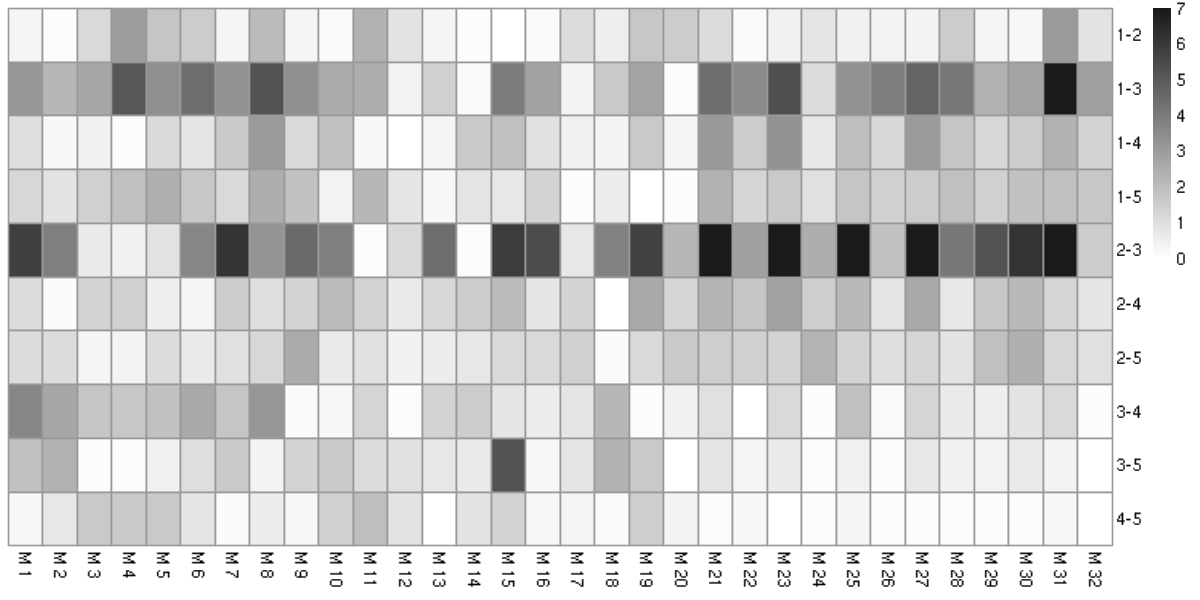

In [71]:
rnames=c("1-2","1-3","1-4","1-5","2-3","2-4","2-5","3-4","3-5","4-5")
tmodules=matrix(0,10,32,dimnames=list(rnames,paste("M",1:32)))

# oord=order(rownames(modbrain[[1]]))
oord=order(rownames(modmat))

icnt=0
for (i in 1:(max(mfac)-1)) {
  for (j in (i+1):max(mfac)) {
    
    icnt=icnt+1
    ts1=which(hbaclus==i)
    ts2=which(hbaclus==j)
    
    for (k in 1:32) {
      
#       ds1=modbrain[[1]][oord[ts1],k]
#       ds2=modbrain[[1]][oord[ts2],k]
      ds1=modmat[oord[ts1],k]
      ds2=modmat[oord[ts2],k]
      tmodules[icnt,k]=t.test(ds1,ds2)$p.value  
    }
  }
}

options(repr.plot.width=10, repr.plot.height=5)
mpal=colorRampPalette(c("gray100","gray10"))(100)
breaksList = seq(0,7, by = 7/length(mpal))
pheatmap(-log10(tmodules),col=mpal,breaks = breaksList,cluster_rows=F,cluster_cols=F)

dev.off()
pdf(paste(opath,"Supplementary_Figure_14.pdf",sep=""),width=10,height=5,colormodel = 'rgb')
mpal=colorRampPalette(c("gray100","gray10"))(100)
breaksList = seq(0,7, by = 7/length(mpal))
pheatmap(-log10(tmodules),col=mpal,breaks = breaksList,cluster_rows=F,cluster_cols=F)
dev.off()

## Supplementary Figure 15.    Holdout analysis on canonical modules and ADG

#### Supplementary Figure 15-A same as Supplementary Figure 7 - upper triangular 

### Supplementary Figure 15-B

null device 
          1

null device 
          1

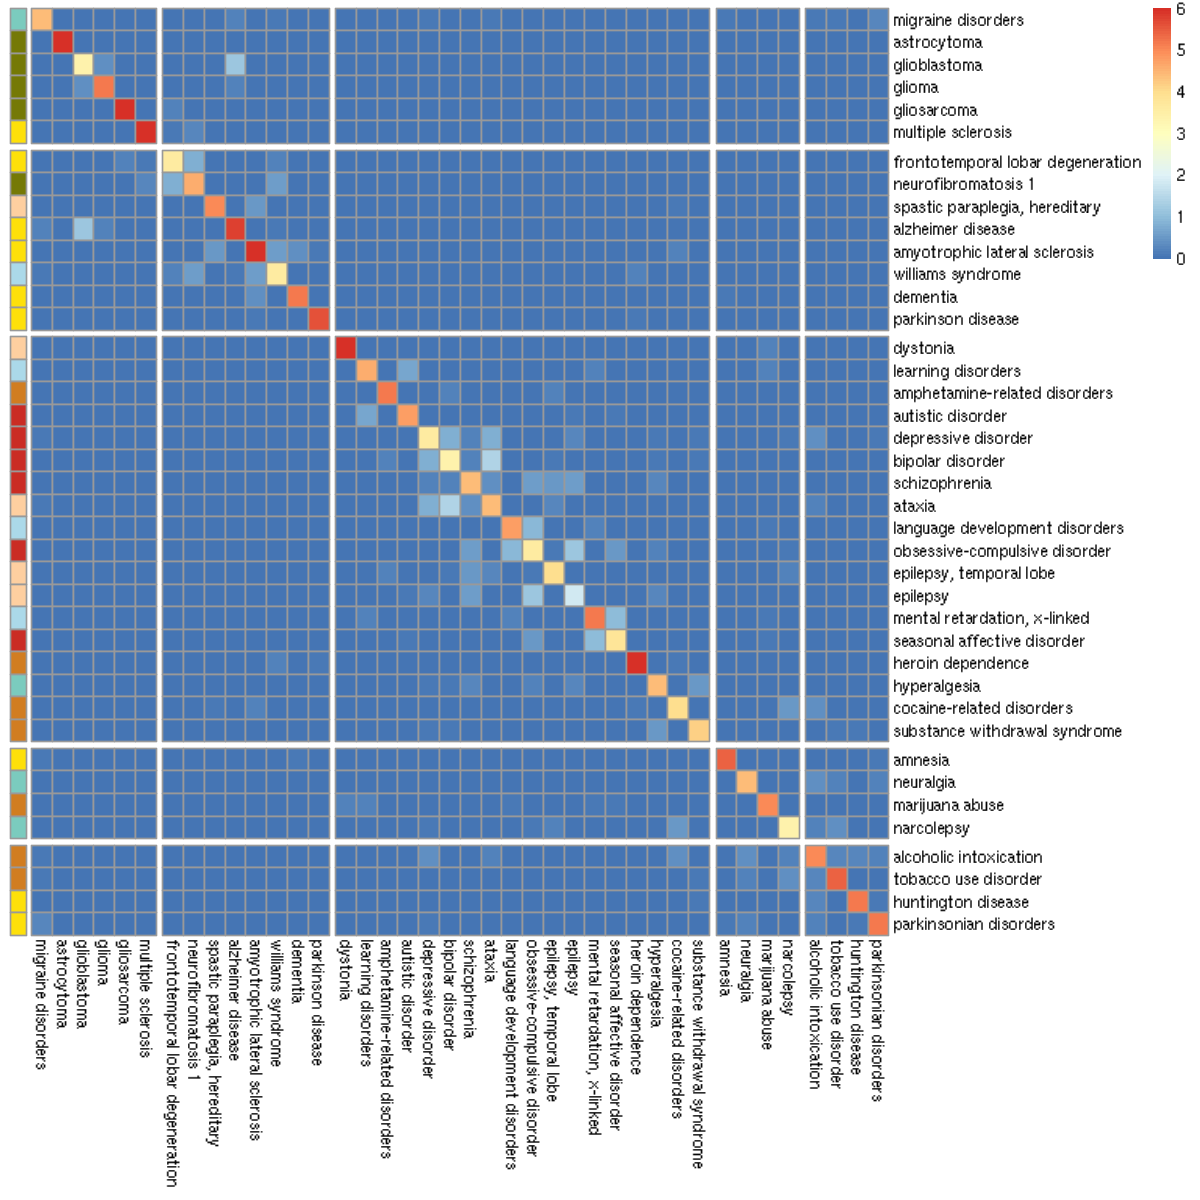

In [72]:
indir=paste(ipath,"module_reproduce/",sep="")
infiles=list.files(indir,include.dirs=F)

modbrain=NULL
for (i in 1:6) {
  modbrain[[i]]=as.matrix(read.csv(paste(indir,infiles[i],sep=""))[,2:33])
  rownames(modbrain[[i]])=disnames[hbaord]
}

consmat=matrix(0,40,6,dimnames=list(disnames[hbaord],paste("B",1:6,sep="")))

for (i in 1:6) {
#   print (paste("Profiling brain",i))
  for (j in 1:disnum) {
    # check other brains and diseases
    obrains=setdiff(c(1:6),i)
    for (l in obrains) {
      distmin= 10000
      for (k in 1:disnum) {
        distv=sqrt(sum((modbrain[[i]][j,]-modbrain[[l]][k,])*(modbrain[[i]][j,]-modbrain[[l]][k,])))
        if (distv<distmin) {
          distmin=distv
          distind=k
        }
      }
      consmat[j,i]=distind
    }
  }
}

# rank diseases by reproducibility
rdis=vector("numeric",disnum)
for (i in 1:disnum) {
  rdis[i]=sum(consmat[i,]==i)
}


# rescale for plotting
modbrainb=NULL
thresh=1
for ( i in 1:6) {
  modbrainb[[i]]=modbrain[[i]]
  for (j in 1:disnum) {
    for (k in 1:32) {
      if (modbrainb[[i]][j,k]>thresh) {modbrainb[[i]][j,k]=thresh}
      if (modbrainb[[i]][j,k]< -thresh) {modbrainb[[i]][j,k]= -thresh}
    }
  }
}
  

# compare closest assignment averaged over all brain pairs
closdismat=matrix(0,disnum,disnum,dimnames=list(disnames[hbaord],disnames[hbaord]))
for (i in 1:disnum) {
  for (b1 in 1:6) {
    for (b2 in setdiff(1:6,b1)) {
      dmin=10000
      for (j in 1:disnum) {   # find closest disease in in b2
        dt=sqrt(sum((modbrainb[[b1]][i,]-modbrain[[b2]][j,])^2))
        if (dt<dmin) {
          dmin=dt
          dind=j
        }
      }
      closdismat[i,dind]=closdismat[i,dind]+1
    }
  }
}

# non-symettrized for counting
closdismatc=closdismat/5

# symmetrized for plotting
closdismat=(closdismat+t(closdismat))/(2*5)


options(repr.plot.width=10, repr.plot.height=10)
fpal=colorRampPalette(c("gray99","gray24"))(20)
pheatmap(closdismat,cluster_rows=F,cluster_cols=F,gaps_row=c(6,14,32,36),gaps_col=c(6,14,32,36),
         annotation_legend=F,
         annotation_row=DiseaseAnno,annotation_names_row = F,
         annotation_colors=ann_colors_d,
         annotation_names_col=F)

dev.off()
pdf(paste(opath,"Supplementary_Figure_15_B.pdf",sep=""),width=10,height=10)
fpal=colorRampPalette(c("gray99","gray24"))(20)
pheatmap(closdismat,cluster_rows=F,cluster_cols=F,gaps_row=c(6,14,32,36),gaps_col=c(6,14,32,36),
         annotation_legend=F,
         annotation_row=DiseaseAnno,annotation_names_row = F,
         annotation_colors=ann_colors_d,
         annotation_names_col=F)
dev.off()

### Supplementary Figure 15-C and 15-D

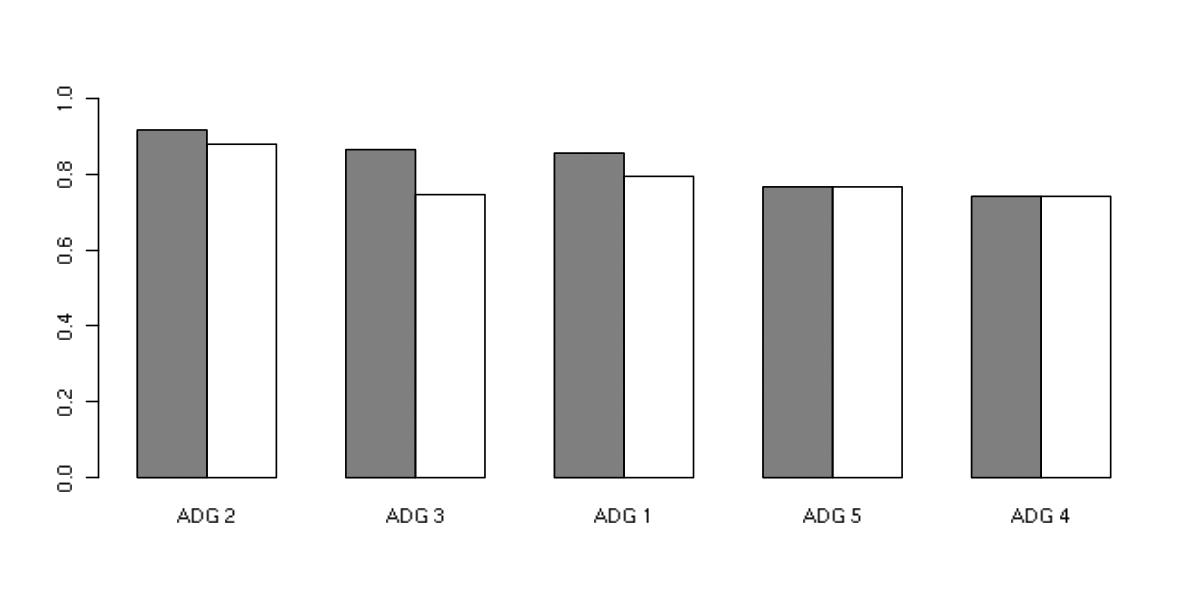

null device 
          1

null device 
          1

null device 
          1

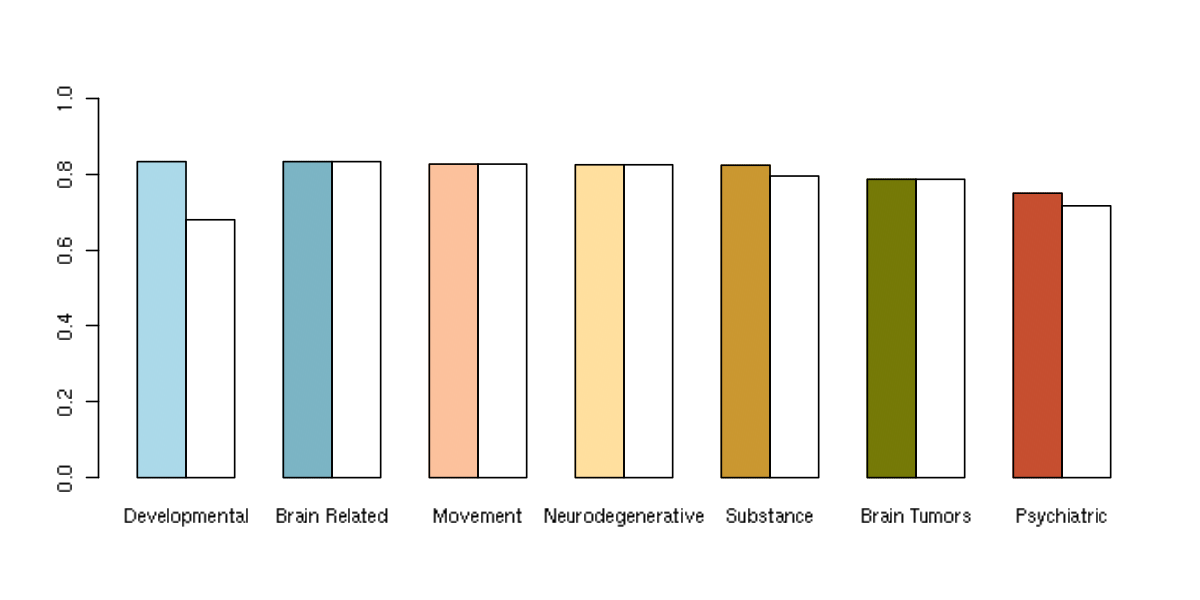

In [73]:
# Summary by ADG 
hbaclus=inord$HBA_modules_overlap
adgcor=vector("numeric",max(mfac))
adgexa=vector("numeric",max(mfac))
names(adgcor)=paste("ADG",1:max(mfac))
names(adgexa)=paste("ADG",1:max(mfac))
for (i in 1:max(mfac)) {
  ips=which(hbaclus==i)
  adgcor[i]=sum(closdismatc[ips,ips])/sum(closdismatc[ips,])
  adgexa[i]=mean(diag(closdismat[ips,ips]))/6
}     


# Summary by GBD
gbdcor=vector("numeric",length(colp))
gbdexa=vector("numeric",length(colp))
names(gbdcor)=names(colp)
names(gbdexa)=names(colp)
for (i in 1:length(colp)) {
  ips=which(dclass==i)
  gbdcor[i]=sum(closdismatc[ips,ips])/sum(closdismatc[ips,])
  gbdexa[i]=mean(diag(closdismatc[ips,ips]))/6
}     

options(repr.plot.width=10, repr.plot.height=5)
ordv=order(adgcor,decreasing=TRUE)
barplot(rbind(adgcor[ordv],adgexa[ordv]),col=c("gray50","white"),beside=TRUE,horiz=FALSE,ylim=c(0,1.0),density=c(120,0))


ordv=order(gbdcor,decreasing=TRUE)
barplot(rbind(gbdcor[ordv],gbdexa[ordv]),col=c(rbind(colp[ordv],colp[ordv])),beside=TRUE,horiz=FALSE,ylim=c(0,1.0),density=c(120,0))

dev.off()
pdf(paste(opath,"Supplementary_Figure_15_C.pdf",sep=""),width=10,height=5)
ordv=order(adgcor,decreasing=TRUE)
barplot(rbind(adgcor[ordv],adgexa[ordv]),col=c("gray50","white"),beside=TRUE,horiz=FALSE,ylim=c(0,1.0),density=c(120,0))
dev.off()
pdf(paste(opath,"Supplementary_Figure_15_D.pdf",sep=""),width=10,height=5)
ordv=order(gbdcor,decreasing=TRUE)
barplot(rbind(gbdcor[ordv],gbdexa[ordv]),col=c(rbind(colp[ordv],colp[ordv])),beside=TRUE,horiz=FALSE,ylim=c(0,1.0),density=c(120,0))
dev.off()

#### Supplementary Figure 15-E

In [74]:
module_adg <- adgcor
module_exact <- adgexa
ADG_Holdout <- rbind(ADG_Holdout,module_adg,module_exact)
module_gbd <- gbdcor
module_exact <- gbdexa
GBD_Holdout <- rbind(GBD_Holdout,module_gbd,module_exact)
mean_ADG_Holdout <- rowMeans(ADG_Holdout)
ADG_Holdout <- cbind(ADG_Holdout,mean_ADG_Holdout)
mean_GBD_Holdout <- rowMeans(GBD_Holdout)
GBD_Holdout <- cbind(GBD_Holdout,mean_GBD_Holdout)
ADG_Holdout
GBD_Holdout
write.csv(ADG_Holdout,paste(opath,"ADG_Holdout.csv",sep=""))
write.csv(GBD_Holdout,paste(opath,"GBD_Holdout.csv",sep=""))

ADG 1     ADG 2     ADG 3     ADG 4     ADG 5     mean_ADG_Holdout
mean_adg     0.9666667 0.7708333 0.9611111 1.0000000 0.9250000 0.9247222       
mean_exact   0.7166667 0.5375000 0.6444444 0.9583333 0.8750000 0.7463889       
module_adg   0.8555556 0.9166667 0.8648148 0.7416667 0.7666667 0.8290741       
module_exact 0.7944444 0.8791667 0.7462963 0.7416667 0.7666667 0.7856481

Psychiatric Substance Movement  Neurodegenerative Brain Tumors
mean_gbd     0.5500000   0.8952381 0.9400000 0.7583333         0.7533333   
mean_exact   0.4333333   0.8285714 0.9333333 0.6333333         0.6066667   
module_gbd   0.7500000   0.8238095 0.8266667 0.8250000         0.7866667   
module_exact 0.7166667   0.7952381 0.8266667 0.8250000         0.7866667   
             Developmental Brain Related mean_GBD_Holdout
mean_gbd     0.6400000     0.8250000     0.7659864       
mean_exact   0.6200000     0.8166667     0.6959864       
module_gbd   0.8333333     0.8333333     0.8112585       
module_exact 0.6800000     0.8333333     0.7805102

### Supplementary Figure 16. Human MTG cellular data, expression level, specificity and diseases

In [75]:
stabin_cell=read.csv(paste(ipath,"DiffStab_dis_cell.csv",sep=""))
stabin_cell$dis_type <- factor(stabin_cell$dis_type , levels=c("none", "brain", "non_brain", "Both"))
CTX_genes=read.csv(paste(ipath,"CTX_genes.csv",sep=""))[,2]
nonCTX_genes <- which((is.element(stabin_cell$dis_type,c('brain'))*(!is.element(stabin_cell$gene_symbol,toupper(CTX_genes))))==1)
length(nonCTX_genes)
stabin_cell_all <- stabin_cell
stabin_cell$dis_type[nonCTX_genes] <- "Both"

[1] 93

In [76]:
head(stabin_cell_all)
write.csv(stabin_cell_all[is.element(stabin_cell_all$gene_symbol,toupper(CTX_genes)),c(2,6)],
          paste(opath,"CTX_genes_cell_specificity.csv",sep=""))

X     gene_symbol stability mean_Exp  dis_type  human_score human_fpkm
1  4691 A1BG        0.672      8.269731 Both      0.18472549  2.349846  
2  3405 A2M         0.726     11.218231 Both      0.24597810  3.283981  
3 16989 A2ML1       0.076      8.668352 non_brain 0.09406475  2.063355  
4 16137 A3GALT2     0.181      4.517451 none      0.03539427  1.247015  
5 14618 A4GALT      0.297      4.443686 non_brain 0.30708294  2.016884  
6 10732 AAAS        0.458      6.836626 non_brain 0.22535767  2.819762

In [77]:
table(stabin_cell_all$dis_type)
table(stabin_cell$dis_type)


     none     brain non_brain      Both 
     9598       597      3591      1046 


     none     brain non_brain      Both 
     9598       504      3591      1139 

In [78]:
t.test(stabin_cell_all$human_fpkm[is.element(stabin_cell_all$dis_type,c('brain'))],
       stabin_cell_all$human_fpkm[is.element(stabin_cell_all$dis_type,c('non_brain'))])

t.test(stabin_cell_all$human_fpkm[is.element(stabin_cell_all$dis_type,c('brain'))],
       stabin_cell_all$human_fpkm[is.element(stabin_cell_all$dis_type,c('none'))])

t.test(stabin_cell_all$human_fpkm[is.element(stabin_cell_all$dis_type,c('none'))],
       stabin_cell_all$human_fpkm[is.element(stabin_cell_all$dis_type,c('non_brain'))])
print('----------------------')
t.test(stabin_cell_all$human_score[is.element(stabin_cell_all$dis_type,c('brain'))],
       stabin_cell_all$human_score[is.element(stabin_cell_all$dis_type,c('non_brain'))])

t.test(stabin_cell_all$human_score[is.element(stabin_cell_all$dis_type,c('brain'))],
       stabin_cell_all$human_score[is.element(stabin_cell_all$dis_type,c('none'))])

t.test(stabin_cell_all$human_score[is.element(stabin_cell_all$dis_type,c('none'))],
       stabin_cell_all$human_score[is.element(stabin_cell_all$dis_type,c('non_brain'))])


	Welch Two Sample t-test

data:  stabin_cell_all$human_fpkm[is.element(stabin_cell_all$dis_type, c("brain"))] and stabin_cell_all$human_fpkm[is.element(stabin_cell_all$dis_type, c("non_brain"))]
t = 2.2437, df = 901.17, p-value = 0.02509
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.006745639 0.100940644
sample estimates:
mean of x mean of y 
 2.442069  2.388226 



	Welch Two Sample t-test

data:  stabin_cell_all$human_fpkm[is.element(stabin_cell_all$dis_type, c("brain"))] and stabin_cell_all$human_fpkm[is.element(stabin_cell_all$dis_type, c("none"))]
t = 7.5321, df = 718.83, p-value = 1.502e-13
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.1260244 0.2148836
sample estimates:
mean of x mean of y 
 2.442069  2.271615 



	Welch Two Sample t-test

data:  stabin_cell_all$human_fpkm[is.element(stabin_cell_all$dis_type, c("none"))] and stabin_cell_all$human_fpkm[is.element(stabin_cell_all$dis_type, c("non_brain"))]
t = -9.3474, df = 6782.1, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.14106630 -0.09215545
sample estimates:
mean of x mean of y 
 2.271615  2.388226 


[1] "----------------------"



	Welch Two Sample t-test

data:  stabin_cell_all$human_score[is.element(stabin_cell_all$dis_type, c("brain"))] and stabin_cell_all$human_score[is.element(stabin_cell_all$dis_type, c("non_brain"))]
t = 8.6044, df = 747.13, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.04303012 0.06846936
sample estimates:
mean of x mean of y 
0.2497412 0.1939915 



	Welch Two Sample t-test

data:  stabin_cell_all$human_score[is.element(stabin_cell_all$dis_type, c("brain"))] and stabin_cell_all$human_score[is.element(stabin_cell_all$dis_type, c("none"))]
t = 11.751, df = 646.78, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.06113268 0.08566293
sample estimates:
mean of x mean of y 
0.2497412 0.1763434 



	Welch Two Sample t-test

data:  stabin_cell_all$human_score[is.element(stabin_cell_all$dis_type, c("none"))] and stabin_cell_all$human_score[is.element(stabin_cell_all$dis_type, c("non_brain"))]
t = -7.148, df = 6220.3, p-value = 9.811e-13
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.02248804 -0.01280809
sample estimates:
mean of x mean of y 
0.1763434 0.1939915 


In [79]:
t.test(stabin_cell$human_fpkm[is.element(stabin_cell$dis_type,c('brain'))],
       stabin_cell$human_fpkm[is.element(stabin_cell$dis_type,c('non_brain'))])

t.test(stabin_cell$human_fpkm[is.element(stabin_cell$dis_type,c('brain'))],
       stabin_cell$human_fpkm[is.element(stabin_cell$dis_type,c('none'))])

t.test(stabin_cell$human_fpkm[is.element(stabin_cell$dis_type,c('none'))],
       stabin_cell$human_fpkm[is.element(stabin_cell$dis_type,c('non_brain'))])
print('----------------------')
t.test(stabin_cell$human_score[is.element(stabin_cell$dis_type,c('brain'))],
       stabin_cell$human_score[is.element(stabin_cell$dis_type,c('non_brain'))])

t.test(stabin_cell$human_score[is.element(stabin_cell$dis_type,c('brain'))],
       stabin_cell$human_score[is.element(stabin_cell$dis_type,c('none'))])

t.test(stabin_cell$human_score[is.element(stabin_cell$dis_type,c('none'))],
       stabin_cell$human_score[is.element(stabin_cell$dis_type,c('non_brain'))])


	Welch Two Sample t-test

data:  stabin_cell$human_fpkm[is.element(stabin_cell$dis_type, c("brain"))] and stabin_cell$human_fpkm[is.element(stabin_cell$dis_type, c("non_brain"))]
t = 2.7996, df = 751.02, p-value = 0.005249
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.02039275 0.11611715
sample estimates:
mean of x mean of y 
 2.456481  2.388226 



	Welch Two Sample t-test

data:  stabin_cell$human_fpkm[is.element(stabin_cell$dis_type, c("brain"))] and stabin_cell$human_fpkm[is.element(stabin_cell$dis_type, c("none"))]
t = 8.025, df = 602.59, p-value = 5.326e-15
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.1396248 0.2301069
sample estimates:
mean of x mean of y 
 2.456481  2.271615 



	Welch Two Sample t-test

data:  stabin_cell$human_fpkm[is.element(stabin_cell$dis_type, c("none"))] and stabin_cell$human_fpkm[is.element(stabin_cell$dis_type, c("non_brain"))]
t = -9.3474, df = 6782.1, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.14106630 -0.09215545
sample estimates:
mean of x mean of y 
 2.271615  2.388226 


[1] "----------------------"



	Welch Two Sample t-test

data:  stabin_cell$human_score[is.element(stabin_cell$dis_type, c("brain"))] and stabin_cell$human_score[is.element(stabin_cell$dis_type, c("non_brain"))]
t = 8.8553, df = 607.98, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.04861053 0.07631588
sample estimates:
mean of x mean of y 
0.2564547 0.1939915 



	Welch Two Sample t-test

data:  stabin_cell$human_score[is.element(stabin_cell$dis_type, c("brain"))] and stabin_cell$human_score[is.element(stabin_cell$dis_type, c("none"))]
t = 11.712, df = 538.38, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.06667438 0.09354816
sample estimates:
mean of x mean of y 
0.2564547 0.1763434 



	Welch Two Sample t-test

data:  stabin_cell$human_score[is.element(stabin_cell$dis_type, c("none"))] and stabin_cell$human_score[is.element(stabin_cell$dis_type, c("non_brain"))]
t = -7.148, df = 6220.3, p-value = 9.811e-13
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.02248804 -0.01280809
sample estimates:
mean of x mean of y 
0.1763434 0.1939915 


### Supplementary Figure 16-A

null device 
          1

null device 
          1

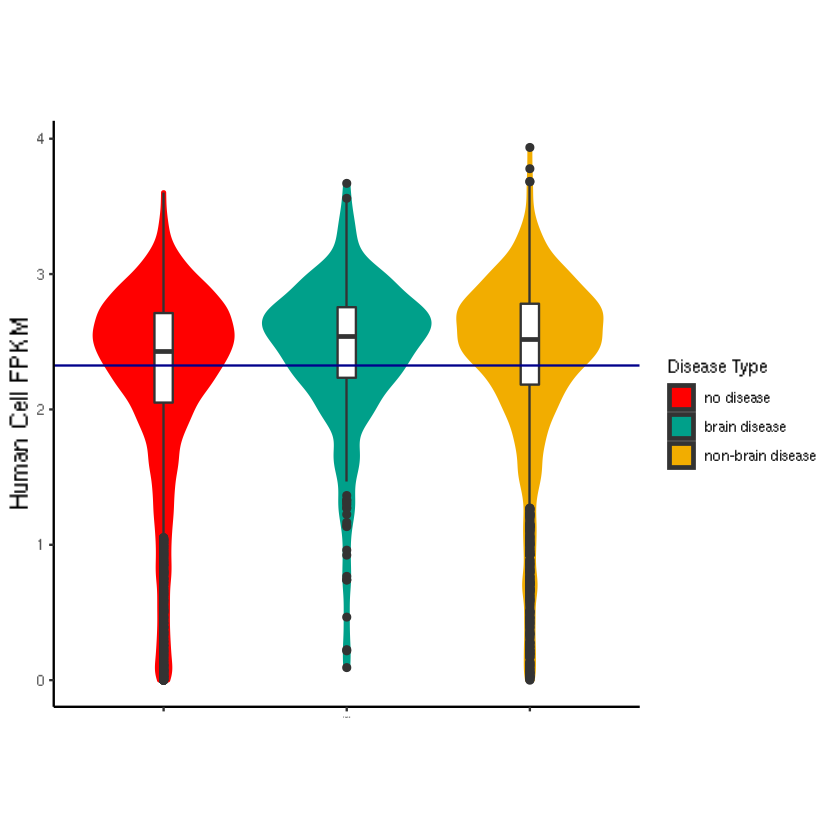

In [80]:
options(repr.plot.width=7, repr.plot.height=7)

ggplot(data = stabin_cell[!is.element(stabin_cell$dis_type,c('Both')),],mapping = aes(x = dis_type,y = human_fpkm)) + 
    geom_violin(mapping = aes(x = dis_type,y = human_fpkm ,fill = dis_type,colour = dis_type),size = 1,adjust=1) + 
    theme(aspect.ratio = 1, axis.title.x = element_text(size=1),axis.title.y = element_text(size=15,angle=90),axis.text.x = element_text(size=15, angle = 90, hjust = 1)) +
    scale_color_manual(values = wes_palette(n=3, name="Darjeeling1")) +    
    scale_fill_manual(values = wes_palette(n=3, name="Darjeeling1"), labels=c("no disease", "brain disease", "non-brain disease")) +
    scale_x_discrete(labels=c("no disease", "brain disease", "non-brain disease")) +
    geom_boxplot(mapping = aes(x = dis_type,y = human_fpkm),width=.1) + 
    geom_hline(yintercept = mean(stabin_cell$human_fpkm),color = 'darkblue',size=.5) + 
    guides(fill=guide_legend(title="Disease Type"),colour = "none") + 
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),axis.text.x = element_blank(),
    panel.background = element_blank(), axis.line = element_line(colour = "black")) +
    labs(x = FALSE, y = 'Human Cell FPKM')

dev.off()
pdf(paste(opath,"Supplementary_Figure_16_A.pdf",sep=""),width=7,height=7)
ggplot(data = stabin_cell[!is.element(stabin_cell$dis_type,c('Both')),],mapping = aes(x = dis_type,y = human_fpkm)) + 
    geom_violin(mapping = aes(x = dis_type,y = human_fpkm ,fill = dis_type,colour = dis_type),size = 1,adjust=1) + 
    theme(aspect.ratio = 1, axis.title.x = element_text(size=1),axis.title.y = element_text(size=15,angle=90),axis.text.x = element_text(size=15, angle = 90, hjust = 1)) +
    scale_color_manual(values = wes_palette(n=3, name="Darjeeling1")) +    
    scale_fill_manual(values = wes_palette(n=3, name="Darjeeling1"), labels=c("no disease", "brain disease", "non-brain disease")) +
    scale_x_discrete(labels=c("no disease", "brain disease", "non-brain disease")) +
    geom_boxplot(mapping = aes(x = dis_type,y = human_fpkm),width=.1) + 
    geom_hline(yintercept = mean(stabin_cell$human_fpkm),color = 'darkblue',size=.5) + 
    guides(fill=guide_legend(title="Disease Type"),colour = "none") + 
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),axis.text.x = element_blank(),
    panel.background = element_blank(), axis.line = element_line(colour = "black")) +
    labs(x = FALSE, y = 'Human Cell FPKM')
dev.off()

In [81]:
df <- stack(setNames(glists, names(glists)))
colnames(df) <- c('genes','disease')
df <- df[,c(2,1)]
df$value <- stabin_cell$human_score[match(df$genes,stabin_cell$gene_symbol)]
df <- df[-which(is.na(df$value)),]
df$type <- inord$disease_type[match(df$disease,inord$alphabetical_disease)]
df$color <- colp[match(df$type,names(colp))]
df <- df[which(is.element(df$disease,CTX_dis$disease)),]
out <- aggregate(value~disease,df,median)

### Supplementary Figure 16-B

null device 
          1

null device 
          1

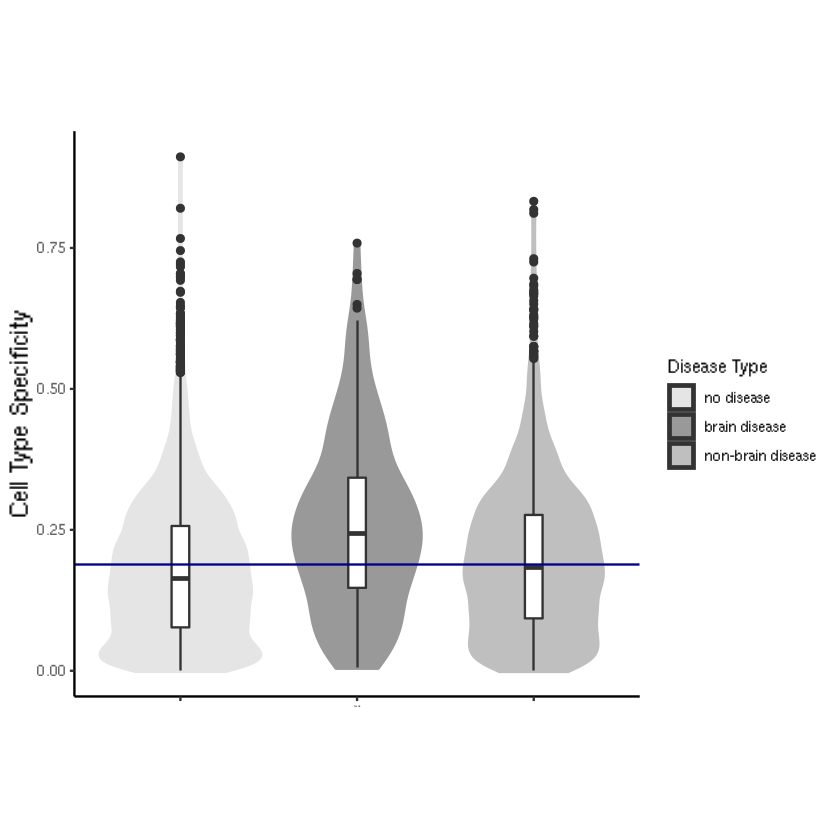

In [82]:
# Figure 16B
options(repr.plot.width=7, repr.plot.height=7)
ggplot(data = stabin_cell[!is.element(stabin_cell$dis_type,c('Both')),],mapping = aes(x = dis_type,y = human_score)) + 
    geom_violin(mapping = aes(x = dis_type,y = human_score ,fill = dis_type,colour = dis_type),size = 1,adjust=1) + 
    theme(aspect.ratio = 1, axis.title.x = element_text(size=1),axis.title.y = element_text(size=15,angle=90),axis.text.x = element_text(size=15, angle = 90, hjust = 1)) +
    scale_color_manual(values = rev(c("gray75","gray60","gray90"))) +    
    scale_fill_manual(values = rev(c("gray75","gray60","gray90")), labels=c("no disease", "brain disease", "non-brain disease")) +
    scale_x_discrete(labels=c("no disease", "brain disease", "non-brain disease")) +
    geom_boxplot(mapping = aes(x = dis_type,y = human_score),width=.1) + 
    geom_hline(yintercept = mean(stabin_cell$human_score),color = 'darkblue',size=.5) + 
    guides(fill=guide_legend(title="Disease Type"),colour = "none") + 
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),axis.text.x = element_blank(),
    panel.background = element_blank(), axis.line = element_line(colour = "black")) +
    labs(x = FALSE, y = 'Cell Type Specificity')

dev.off()
pdf(paste(opath,"Supplementary_Figure_16_B.pdf",sep=""),width=7,height=7)
ggplot(data = stabin_cell[!is.element(stabin_cell$dis_type,c('Both')),],mapping = aes(x = dis_type,y = human_score)) + 
    geom_violin(mapping = aes(x = dis_type,y = human_score ,fill = dis_type,colour = dis_type),size = 1,adjust=1) + 
    theme(aspect.ratio = 1, axis.title.x = element_text(size=1),axis.title.y = element_text(size=15,angle=90),axis.text.x = element_text(size=15, angle = 90, hjust = 1)) +
    scale_color_manual(values = rev(c("gray65","gray50","gray80"))) +    
    scale_fill_manual(values = rev(c("gray65","gray50","gray80")), labels=c("no disease", "brain disease", "non-brain disease")) +
    scale_x_discrete(labels=c("no disease", "brain disease", "non-brain disease")) +
    geom_boxplot(mapping = aes(x = dis_type,y = human_score),width=.1) + 
    geom_hline(yintercept = mean(stabin_cell$human_score),color = 'darkblue',size=.5) + 
    guides(fill=guide_legend(title="Disease Type"),colour = "none") + 
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),axis.text.x = element_blank(),
    panel.background = element_blank(), axis.line = element_line(colour = "black")) +
    labs(x = FALSE, y = 'Cell Type Specificity')
dev.off()

### Supplementary Figure 16-C

null device 
          1

null device 
          1

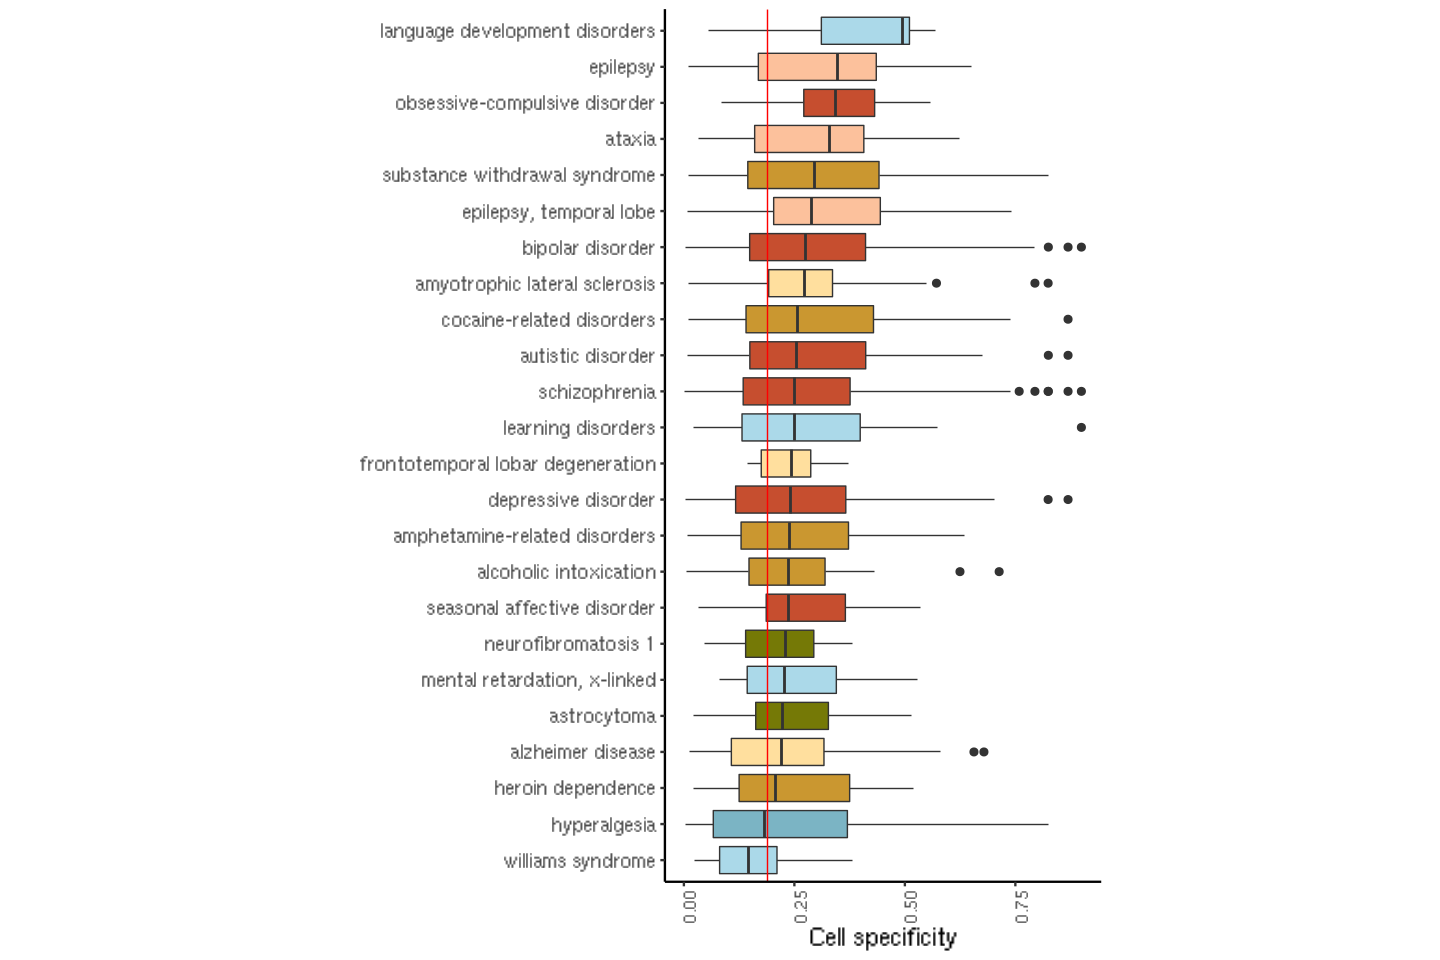

In [83]:
options(repr.plot.width=12, repr.plot.height=8)

ggplot(data = df[which(is.element(df$disease,CTX_dis$disease)),]) + 
        geom_boxplot(mapping = aes(x = reorder(disease, value, FUN=median),y = value),fill = inord$color[ind_CTX][order(out$value)],size=.3) + 
        geom_hline(yintercept = mean(stabin_cell$human_score),color = 'red',size = .3) + 
        coord_flip() +
        theme(aspect.ratio = 2,axis.text.x = element_text(angle = 90, hjust = 1, size = 10),axis.text.y = element_text(size = 12),
        axis.title.x = element_text(size=15),panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),panel.background = element_blank(), axis.line = element_line(colour = "black")) +
            labs(y = 'Cell specificity', x = '')

dev.off()
pdf(paste(opath,"Supplementary_Figure_16_C.pdf",sep=""),width=12,height=8)
ggplot(data = df) + 
        geom_boxplot(mapping = aes(x = reorder(disease, value, FUN=median),y = value),fill = inord$color[ind_CTX][order(out$value)],size=.3) + 
        geom_hline(yintercept = mean(stabin_cell$human_score),color = 'red',size = .3) + 
        coord_flip() +
        theme(aspect.ratio = 2,axis.text.x = element_text(angle = 90, hjust = 1, size = 10),axis.text.y = element_text(size = 12),
        axis.title.x = element_text(size=15),panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),panel.background = element_blank(), axis.line = element_line(colour = "black")) +
            labs(y = 'Cell specificity', x = '')
dev.off()

In [84]:
# comparing meso and cell type ranking 
din=read.csv(paste(ipath,"Disease_HBA_stability_Cell_tau.csv",sep=""))
cor(din[,2],din[,4],method="spearman")

[1] 0.3280165

# Figure 3. Disease genes and cell types of middle temporal gyrus.

In [85]:
df <- stack(setNames(glists, names(glists)))
colnames(df) <- c('genes','disease')
df <- df[,c(2,1)]
df$value <- stabin_cell$human_score[match(df$genes,stabin_cell$gene_symbol)]
df <- df[-which(is.na(df$value)),]
df$type <- inord$disease_type[match(df$disease,inord$alphabetical_disease)]
df$color <- colp[match(df$type,names(colp))]
df <- df[which(is.element(df$disease,CTX_dis$disease)),]
out <- aggregate(value~disease,df,median)

### Figure 3-B

null device 
          1

null device 
          1

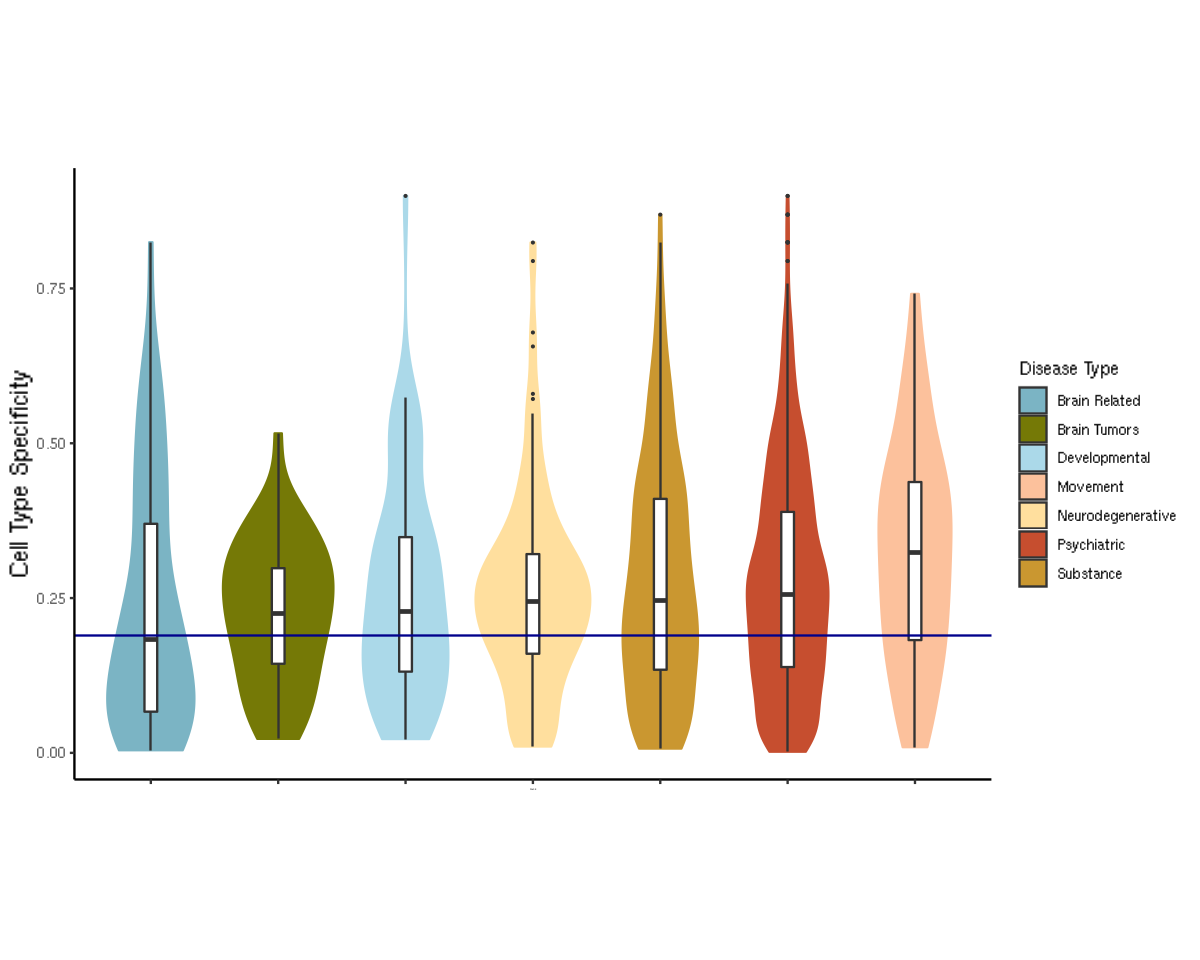

In [86]:
# Figure 3C
options(repr.plot.width=10, repr.plot.height=8)
ggplot(data = df) + 
        geom_violin(mapping = aes(x = reorder(type, value, FUN=median),y = value,fill = type, colour = type))+
        theme(aspect.ratio = 1/1.5, axis.title.x = element_text(size=1),
        axis.title.y = element_text(size=15,angle=90),axis.text.x = element_blank()) +
        scale_fill_manual(values = colp[order(names(colp))])+ 
        scale_color_manual(values = colp[order(names(colp))])+
        geom_boxplot(mapping = aes(x = type,y = value),width=.1, outlier.size = .1)+
        geom_hline(yintercept = mean(stabin_cell$human_score),color = 'darkblue',size=.5) +
        guides(fill=guide_legend(title="Disease Type"),colour = "none") + 
        theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        panel.background = element_blank(), axis.line = element_line(colour = "black")) +
        labs(x = FALSE, y = 'Cell Type Specificity')

dev.off()
pdf(paste(opath,"Figure_03_B.pdf",sep=""),width=10,height=8)
ggplot(data = df) + 
        geom_violin(mapping = aes(x = reorder(type, value, FUN=median),y = value,fill = type, colour = type))+
        theme(aspect.ratio = 1/1.5, axis.title.x = element_text(size=1),
        axis.title.y = element_text(size=15,angle=90),axis.text.x = element_blank()) +
        scale_fill_manual(values = colp[order(names(colp))])+ 
        scale_color_manual(values = colp[order(names(colp))])+
        geom_boxplot(mapping = aes(x = type,y = value),width=.1, outlier.size = .1)+
        geom_hline(yintercept = mean(stabin_cell$human_score),color = 'darkblue',size=.5) +
        guides(fill=guide_legend(title="Disease Type"),colour = "none") + 
        theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        panel.background = element_blank(), axis.line = element_line(colour = "black")) +
        labs(x = FALSE, y = 'Cell Type Specificity')
dev.off()

In [87]:
unique(df$type)
GBD_pvalues <- sapply(unique(df$type),function(x) t.test(df$value[is.element(df$type,x)],mu = mean(stabin_cell$human_score)))
p.adjust(GBD_pvalues[3,],method = 'bonferroni')

[1] "Substance"         "Neurodegenerative" "Brain Tumors"     
[4] "Movement"          "Psychiatric"       "Brain Related"    
[7] "Developmental"

Substance Neurodegenerative      Brain Tumors          Movement 
     3.580622e-11      1.595465e-05      1.844710e-01      1.715818e-11 
      Psychiatric     Brain Related     Developmental 
     2.523329e-74      6.146555e-01      8.359733e-03

In [88]:
# Figure 3D main cell type clustering
cin=read.csv(paste(ipath,"Dis_cluster_gz_mean_annotated.csv",sep=""))
ccoltype=colnames(cin)[-1]
csubclass=as.character(unlist(cin[1,]))[-1]
dmat=matrix(as.numeric(as.matrix(cin[2:dim(cin)[1],2:dim(cin)[2]])),40,75)
rownames(dmat)=cin[,1][-1]
colnames(dmat)=ccoltype

thresh = 1
for (i in 1:dim(dmat)[1]) {
  for (j in 1:dim(dmat)[2]) {
    if (dmat[i,j] > thresh) {dmat[i,j]=thresh}
    if (dmat[i,j] <  -thresh) {dmat[i,j]= -thresh}
    
  }
}

# color codes and annotation for MTG cell types
ctnin=read.csv(paste(ipath,"cts.csv",sep=""),header=F)
ctf=as.data.frame(ctnin[,2:3])
rownames(ctf)=ctnin[,1]

In [89]:
# # Figure 3D main cell type clustering
# cin=read.csv(paste(ipath,"Dis_cluster_mean.csv",sep=""))
# ccoltype=colnames(cin)[-1]
# dmat=matrix(as.numeric(as.matrix(cin[1:dim(cin)[1],2:dim(cin)[2]])),40,75)
# rownames(dmat)=cin[,1]
# colnames(dmat)=ccoltype

# # color codes and annotation for MTG cell types
# ctnin=read.csv(paste(ipath,"cts.csv",sep=""),header=F)
# ctf=as.data.frame(ctnin[,2:3])
# rownames(ctf)=ctnin[,1]

In [90]:
cin_overlap=read.csv(paste(ipath,"Disease_Cell_type_correlation_overlap_matrix.csv",sep=""),row.names = 1)
cin_noverlap=read.csv(paste(ipath,"Disease_Cell_type_correlation_non_overlap_matrix.csv",sep=""),row.names = 1)

number_of_clusters <- 4
cin_clust <- hclust(d = as.dist(1-cin_overlap[ind_CTX,ind_CTX]),method = "ward.D2")
cin_grp <- cutree(cin_clust,number_of_clusters)
cin_grp <- cin_grp[cin_clust$order]

In [91]:
cgrps=NULL
cgrps[[4]]=match(names(cin_grp)[cin_grp==2],rownames(cin_noverlap))#c(19,27,6,18,17,11,28)
cgrps[[2]]=match(names(cin_grp)[cin_grp==4],rownames(cin_noverlap))#c(29,39,24,23,32,20,7,15,30,36)
cgrps[[1]]=match(names(cin_grp)[cin_grp==1],rownames(cin_noverlap))#c(16,2,40,3,1,12,22,5,37)
cgrps[[3]]=match(names(cin_grp)[cin_grp==3],rownames(cin_noverlap))#c(21,25,34,13,38,4,10,14,31,33,26,35,8,9)

ocdis=c(cgrps[[1]],cgrps[[2]],cgrps[[3]],cgrps[[4]])
ocdis_gaps = cumsum(c(length(cgrps[[1]]),length(cgrps[[2]]),length(cgrps[[3]]),length(cgrps[[4]])))

In [92]:
inord=read.csv(paste(ipath,"all_orders_3000_10_40.csv",sep=""))
inord <- inord[ind_CTX,-1]
number_of_cell_clusters <- 4
dis_cell_clust_overlap <- hclust(as.dist(1-cin_overlap[ind_CTX,ind_CTX]),method = "ward.D2")
cell_classes_overlap <- cutree(dis_cell_clust_overlap,number_of_cell_clusters)
inord$cell_cluster_order_disease_overlap <- dis_cell_clust_overlap$labels[dis_cell_clust_overlap$order]
inord$cell_cluster_order_overlap <- dis_cell_clust_overlap$order

dis_cell_clust <- hclust(as.dist(1-cin_noverlap[ind_CTX,ind_CTX]),method = "ward.D2")
cell_classes <- cutree(dis_cell_clust,number_of_cell_clusters)
inord$cell_cluster_order_disease <- dis_cell_clust$labels[dis_cell_clust_overlap$order]
inord$cell_cluster_order <- dis_cell_clust$order

write.csv(inord,paste(opath,"all_orders_3000_10_40_24.csv",sep=""))

### Figure 3-A

In [93]:
ctcolors=c("#A1D5BA","#A1D5BA","#A1D5BA","#A1D5BA","#A1D5BA","#7AB7AB","#BEDFCB","#9ECAE8","#91ACBA","#F2ABB7","#C387E2","#E6B8FF","#D5A8DF","#FEFF99","#E0B889","#EE98A4",
           "#D15627","#7E3E98","#137A66","#808233","#F0C419")

names(ctcolors)=c("L2/3 IT","L4 IT","L5 IT","L6 IT","L6 IT Car3","L5 ET","L5/6 NP","L6 CT","L6b","LAMP5",
                  "SNCG","Serpinf1","VIP","SST Chodl","SST","PVALB",
                  "OPC","Astro","Oligo","Endo","Micro/PVM")

# Generate annotations for rows and columns
annotation_col = data.frame(
  Class = factor(ccoltype),
  Subclass = factor(csubclass)#factor(ccoltype)
)
rownames(annotation_col) = ccoltype

# Generate annotations for rows and columns
annotation_row = data.frame(
  Disease = factor(disnames),
  Adglab = factor(disnames)
)
rownames(annotation_row) = disnames

colvec=colp[dclass]

adgpal=c("gray100","gray85","gray60","gray30","gray0")
names(adgpal)=paste("ADG",1:5)
ctgpal=c("gray90","gray75","gray50","gray25")
names(ctgpal)=paste("CTG",1:4)

# Specify colors
ann_colors = list(
  Class = c(rep("#3A53A4",45),rep("#ED2224",24),rep("#A09C9C",6)),
  Subclass = ctcolors[csubclass],
  Disease = colvec,
  Adglab = adgpal[hbaclus]
)

names(ann_colors$Subclass)=csubclass#ccoltype
names(ann_colors$Class)=ccoltype
names(ann_colors$Disease)=disnames
names(ann_colors$Adglab)=disnames

null device 
          1

null device 
          1

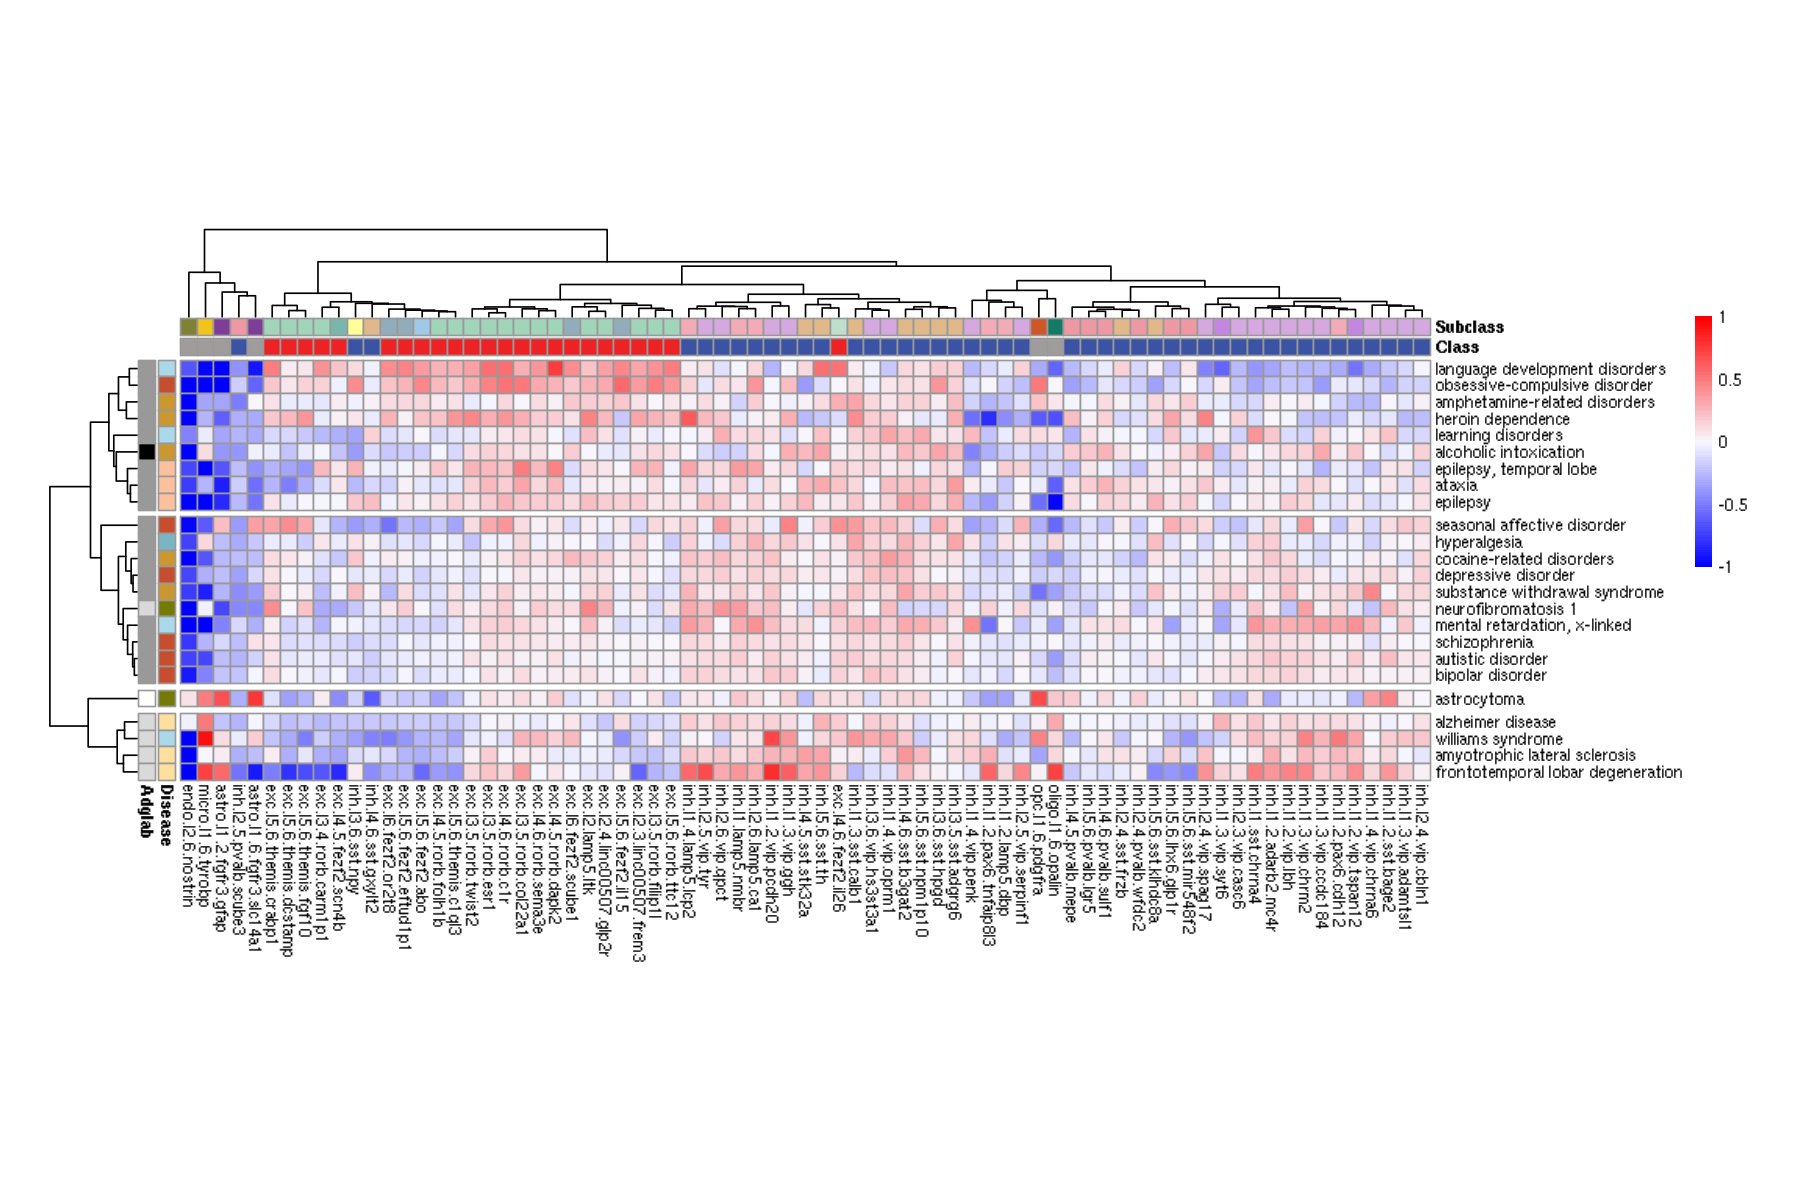

In [94]:
options(repr.plot.width=15, repr.plot.height=10)
breaksList = seq(-1, 1, by = 2/length(hmcols))
a=pheatmap(dmat[ind_CTX,],cluster_cols=T,col=hmcols,gaps_col=c(45,69),
           cluster_rows=T,clustering_method = "ward.D2",
           clustering_distance_rows = as.dist(1-cin_overlap[ind_CTX,ind_CTX]),cutree_rows =4,
           cellwidth=10,cellheight=10,fontsize=10,breaks= breaksList,
           annotation_col=annotation_col,annotation_row=annotation_row,
           annotation_legend=F,annotation_colors=ann_colors)

dev.off()
pdf(paste(opath,"Supplementary_Figure_03_A.pdf",sep=""),width=15,height=10)
a=pheatmap(dmat[ind_CTX,],cluster_cols=T,col=hmcols,gaps_col=c(45,69),cluster_rows=T,clustering_method = "ward.D2",
           clustering_distance_rows = as.dist(1-cin_overlap[ind_CTX,ind_CTX]),cutree_rows =4,
           cellwidth=10,cellheight=10,fontsize=10,breaks= breaksList,
           annotation_col=annotation_col,annotation_row=annotation_row,
           annotation_legend=F,annotation_colors=ann_colors)
dev.off()

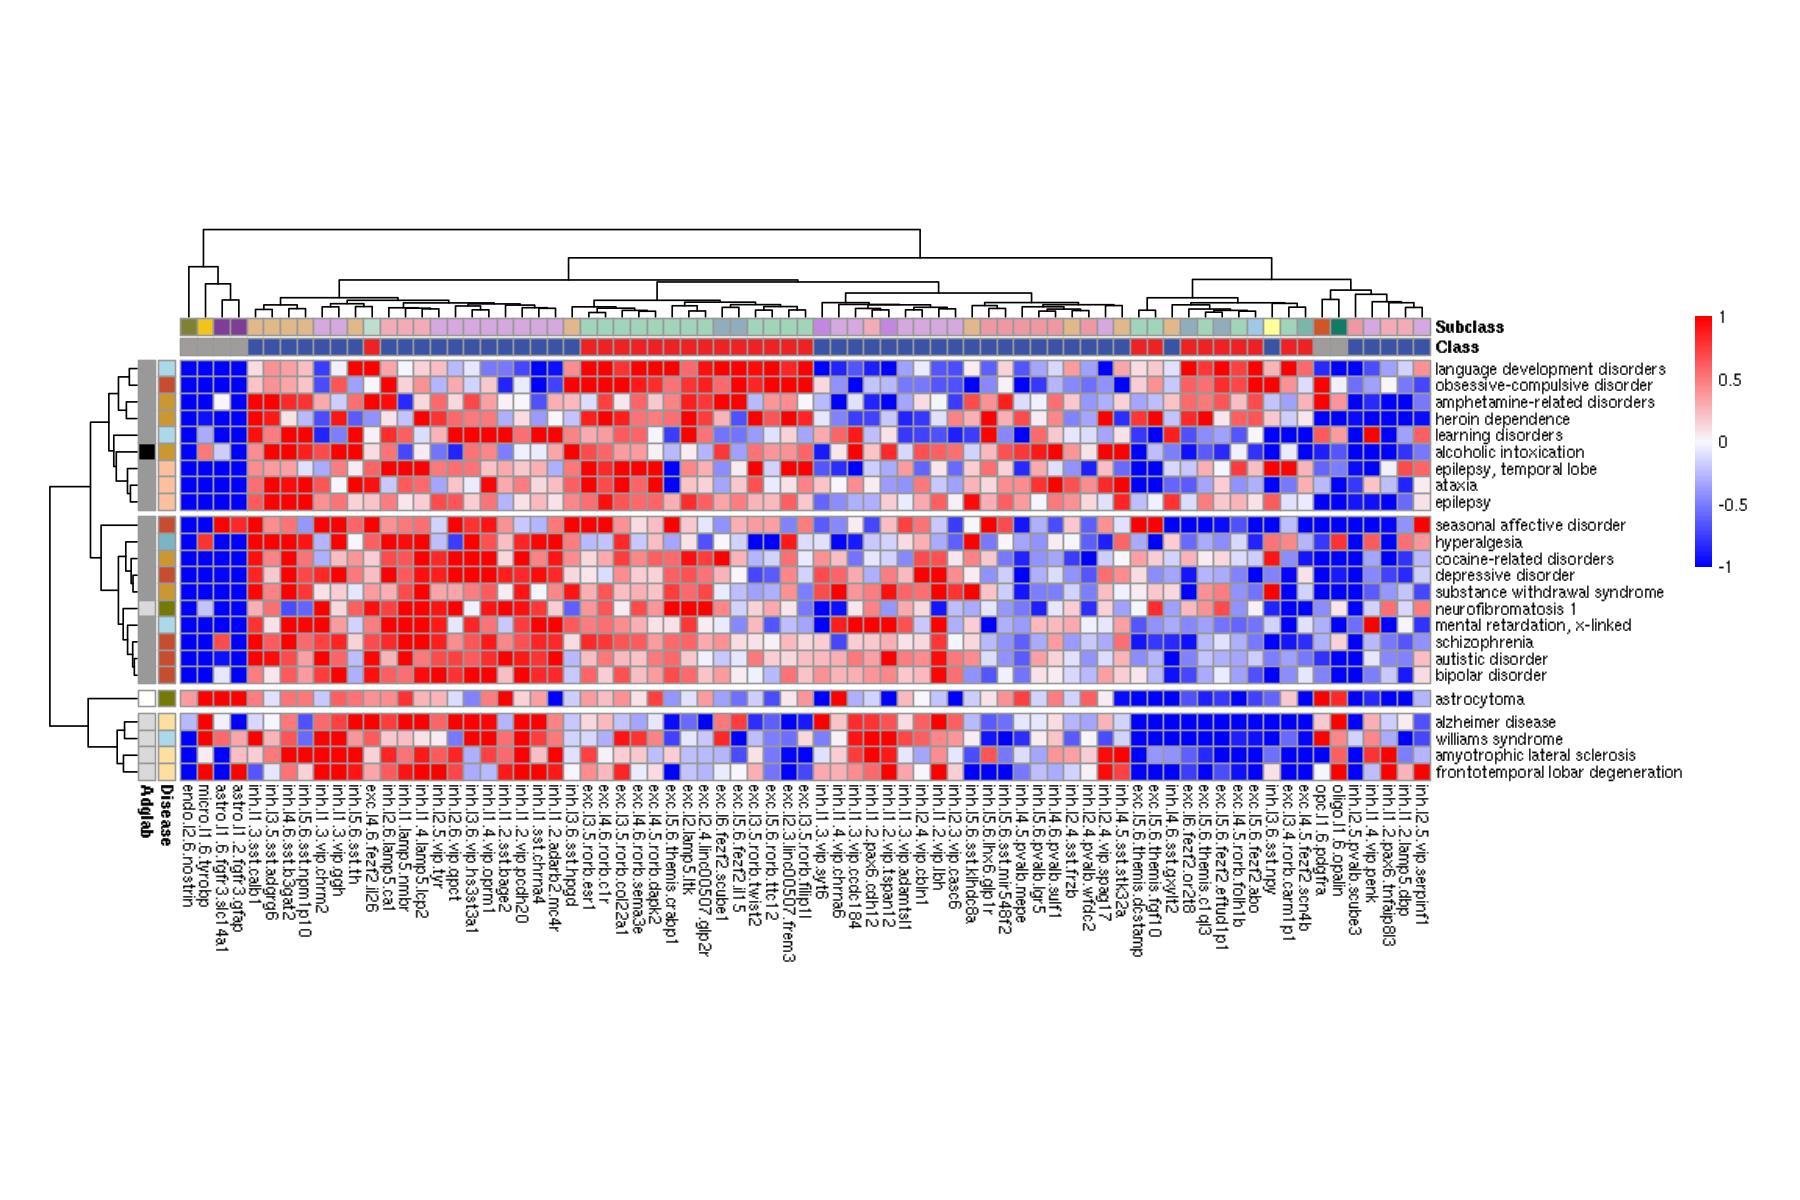

In [95]:
options(repr.plot.width=15, repr.plot.height=10)
thresh = 1
breaksList = seq(-thresh, thresh, by = (2*thresh)/length(hmcols))
a=pheatmap(t(scale(t(dmat[ind_CTX,]))),cluster_cols=T,col=hmcols,gaps_col=c(45,69),
           cluster_rows=T,clustering_method = "ward.D2",
           clustering_distance_rows = as.dist(1-cin_overlap[ind_CTX,ind_CTX]),cutree_rows =4,
           cellwidth=10,cellheight=10,fontsize=10,breaks= breaksList,
           annotation_col=annotation_col,annotation_row=annotation_row,
           annotation_legend=F,annotation_colors=ann_colors)

In [96]:
write.csv(dmat[ind_CTX,][cin_clust$order,],paste(opath,"Figure_3_A_clustering_order.csv",sep=""))
write.csv(dmat[ind_CTX,],paste(opath,"Figure_3_A_alphabetical_order.csv",sep=""))

In [97]:
cell_type_clust_order <- a$tree_col$order

## Clustered Disease genes (no cell clustering)

In [98]:
cgrpvec=vector("numeric",disnum)
cgrpvec[cgrps[[1]]]=1
cgrpvec[cgrps[[2]]]=4
cgrpvec[cgrps[[3]]]=2
cgrpvec[cgrps[[4]]]=3
names(cgrpvec)=disnames[ind_CTX]

annotation_row = data.frame(
  Disease = factor(disnames),
  Adglab = factor(disnames),
  Ctglab = factor(disnames)
)
rownames(annotation_row) = disnames

# Specify colors
ann_colors = list(
  Class = c(rep("#3A53A4",45),rep("#ED2224",24),rep("#A09C9C",6)),
  Subclass = ctcolors[csubclass],
  Disease = colvec[ind_CTX],
  Adglab = adgpal[ind_CTX][hbaclus],
  Ctglab = ctgpal[ind_CTX][cgrpvec]
)

names(ann_colors$Subclass)=csubclass#ccoltype
names(ann_colors$Class)=ccoltype
names(ann_colors$Disease)=disnames[ind_CTX]
names(ann_colors$Adglab)=disnames[ind_CTX]
names(ann_colors$Ctglab)=disnames[ind_CTX]

## Supplementary Figure 17. Comparing cell type clusters (CTG).

In [99]:
#  ANOVA by structure
mfac=vector("numeric",dim(dmat[ind_CTX,])[1])
mfac[cgrps[[1]]]=1;mfac[cgrps[[2]]]=2;mfac[cgrps[[3]]]=3;mfac[cgrps[[4]]]=4;

anval=vector("numeric",dim(dmat[ind_CTX,])[2])
names(anval)=ccoltype
for (j in 1:length(anval)) {
  adf=as.data.frame(cbind(dmat[,j],mfac))
  anval[j]=summary(aov(V1~mfac,adf))[[1]][1,5]
}

null device 
          1

null device 
          1

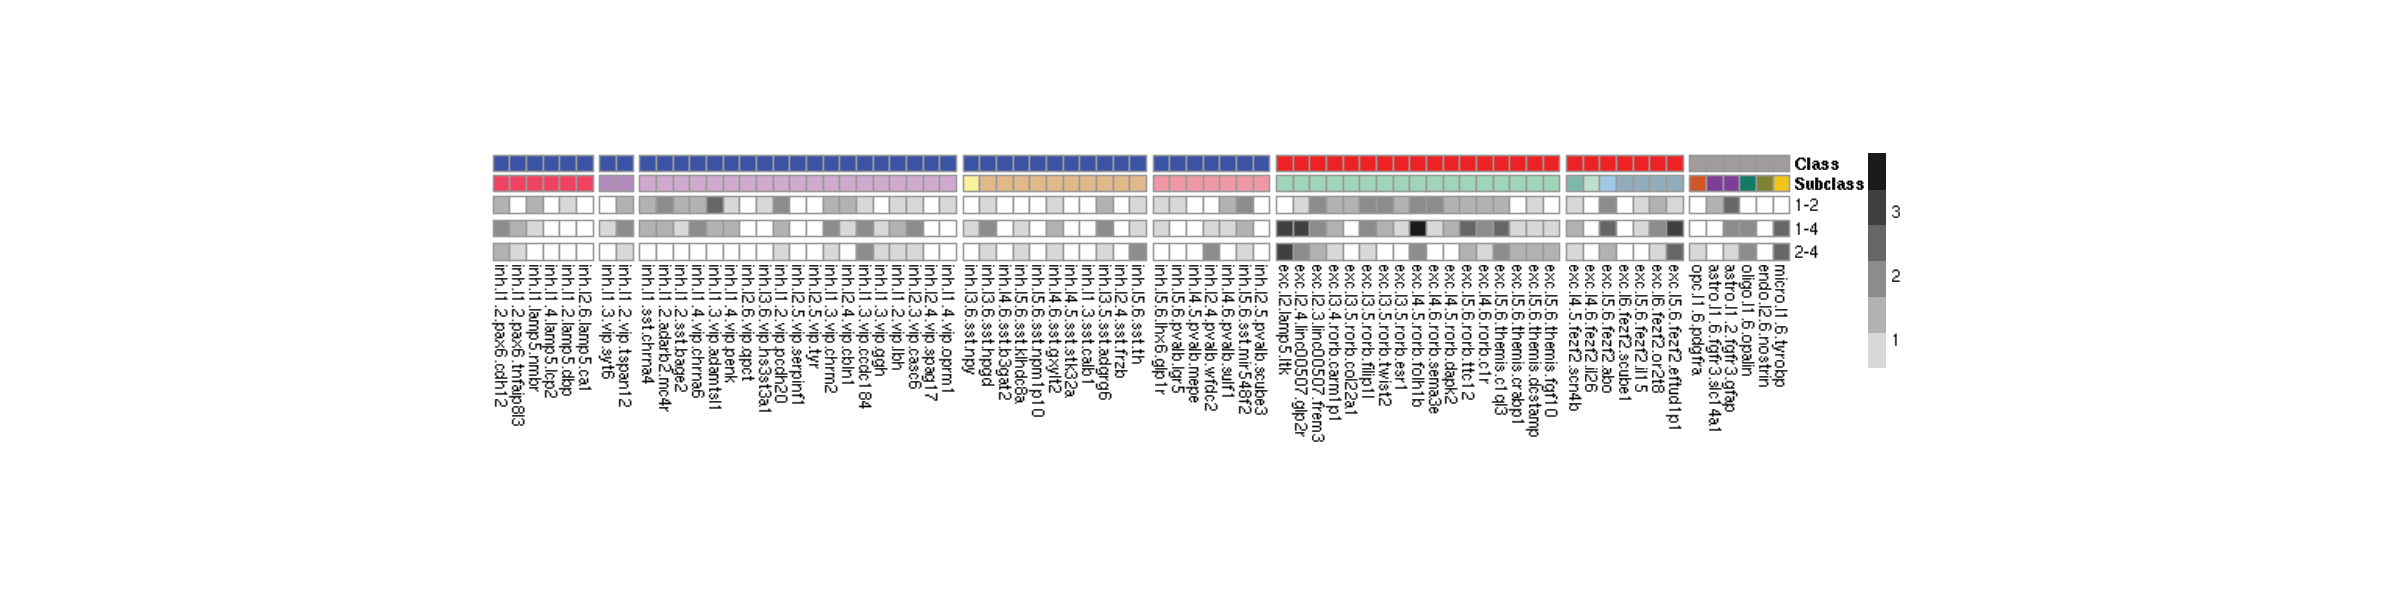

In [100]:
# Figure 3E - Cell type significance
 
rnames=c("1-2","1-4","2-4")
ttypes=matrix(0,3,dim(dmat[ind_CTX,])[2],dimnames=list(rnames,ccoltype))

cord=c(1,2,3)  #  modified order consistent with cell and mesoscale match
oord=a$tree_col$order

icnt=0
for (i in 1:2) {
  for (j in setdiff(c(2,4),i)) {
    icnt=icnt+1 
    
    for (k in 1:dim(dmat[ind_CTX,])[2]) {
      
      ds1=dmat[cgrps[[i]],k]
      ds2=dmat[cgrps[[j]],k]
      ttypes[icnt,k]=t.test(ds1,ds2)$p.value  
    }
  }
}


# Generate annotations for rows and columns
annotation_col = data.frame(
  Subclass = factor(ccoltype),
  Class = factor(ccoltype)
)
rownames(annotation_col) = ccoltype

# Specify colors
ann_colors = list(
  Subclass = ctf[,2],
  Class = c(rep("#3A53A4",45),rep("#ED2224",24),rep("#A09C9C",6))
)

names(ann_colors$Subclass)=ccoltype
names(ann_colors$Class)=ccoltype

options(repr.plot.width=20, repr.plot.height=5)

mpal=colorRampPalette(c("gray100","gray10"))(7) 

pheatmap(-log10(ttypes)[cord,],col=mpal,cluster_rows=F,cluster_cols=F,annotation_col=annotation_col,annotation_legend=F,
         cellwidth=10,cellheight=10,fontsize=10,
         gaps_col=c(6,8,27,38,45,62,69),gaps_row=c(1:2),annotation_colors=ann_colors)

dev.off()
pdf(paste(opath,"Supplementary_Figure_17.pdf",sep=""),width=15,height=3)
pheatmap(-log10(ttypes)[cord,],col=mpal,cluster_rows=F,cluster_cols=F,annotation_col=annotation_col,annotation_legend=F,
         cellwidth=10,cellheight=10,fontsize=10,
         gaps_col=c(6,8,27,38,45,62,69),gaps_row=c(1:2),annotation_colors=ann_colors)
dev.off()

### Supplementary Figure 17- upper panel

null device 
          1

null device 
          1

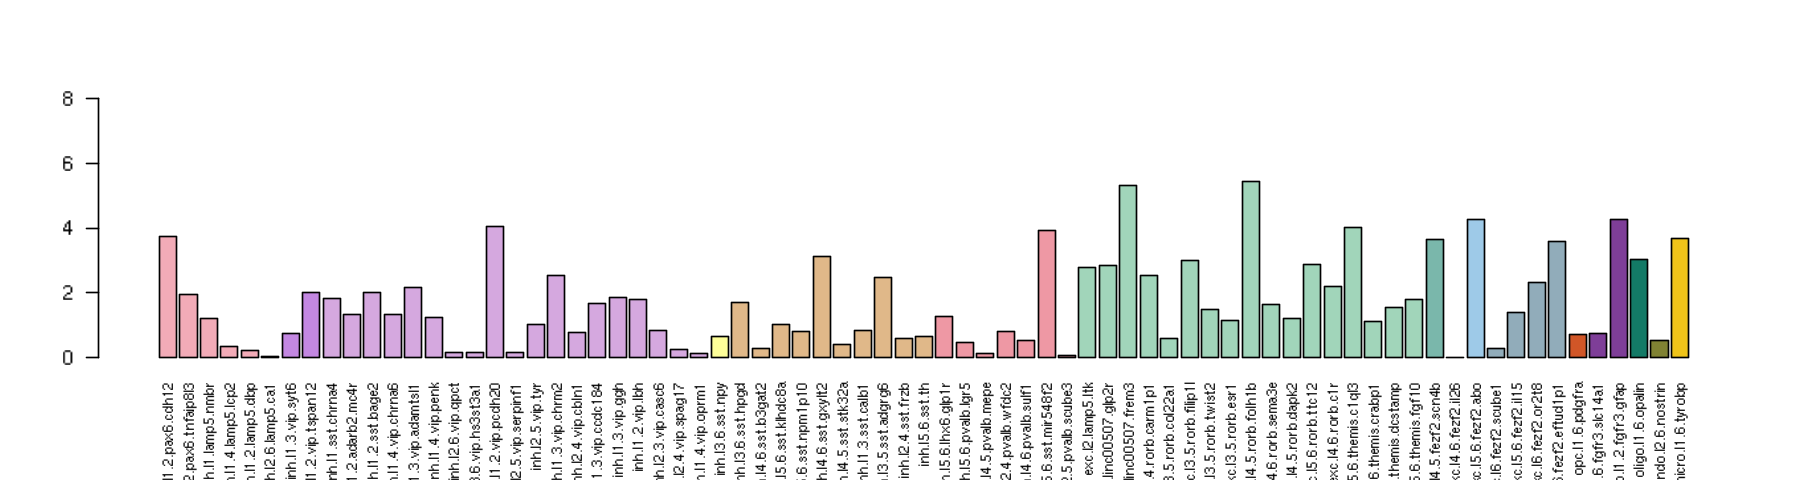

In [101]:
#  ANOVA by cell type
anfac=vector("integer",disnum)
anfac[cgrps[[1]]]=1;anfac[cgrps[[2]]]=2;anfac[cgrps[[3]]]=3;anfac[cgrps[[4]]]=4;
anfac <- anfac[ind_CTX]
anval=vector("numeric",dim(dmat[ind_CTX,])[2])
names(anval)=ccoltype
for (j in 1:length(anval)) {
  adf=as.data.frame(cbind(dmat[ind_CTX,j],anfac))
  anval[j]=summary(aov(V1~anfac,adf))[[1]][1,5]
}
options(repr.plot.width=15, repr.plot.height=4)
par(las = 2)
barplot(-log10(anval),cex.names=.7,col=ctcolors[csubclass],ylim=c(0,8))

# Figure 3F - consensus UMAP
 
cellin=read.csv(paste(ipath,"Disease_Cell_type_correlation_overlap_matrix.csv",sep=""))
hbain=read.csv(paste(ipath,"HBA_Disease_correlation_overlap_matrix.csv",sep=""))

cellmat=as.matrix(cellin[,2:dim(cellin)[2]],40,40)
rownames(cellmat)=as.character(cellin[,1])

hbamat=as.matrix(hbain[,2:dim(hbain)[2]],40,40)
rownames(hbamat)=as.character(hbain[,1])

celldist=1-cellmat
hbadist=1-hbamat

dev.off()
pdf(paste(opath,"Supplementary_Figure_17_A.pdf",sep=""),width=15,height=4)
par(las = 2)
par(mar = c(10,4,2,2))
barplot(-log10(anval),cex.names=.7,col=ctcolors[csubclass],ylim=c(0,8))
dev.off()

### Figure 3-C

as(<dgTMatrix>, "dgCMatrix") is deprecated since Matrix 1.5-0; do as(., "CsparseMatrix") instead



null device 
          1

null device 
          1

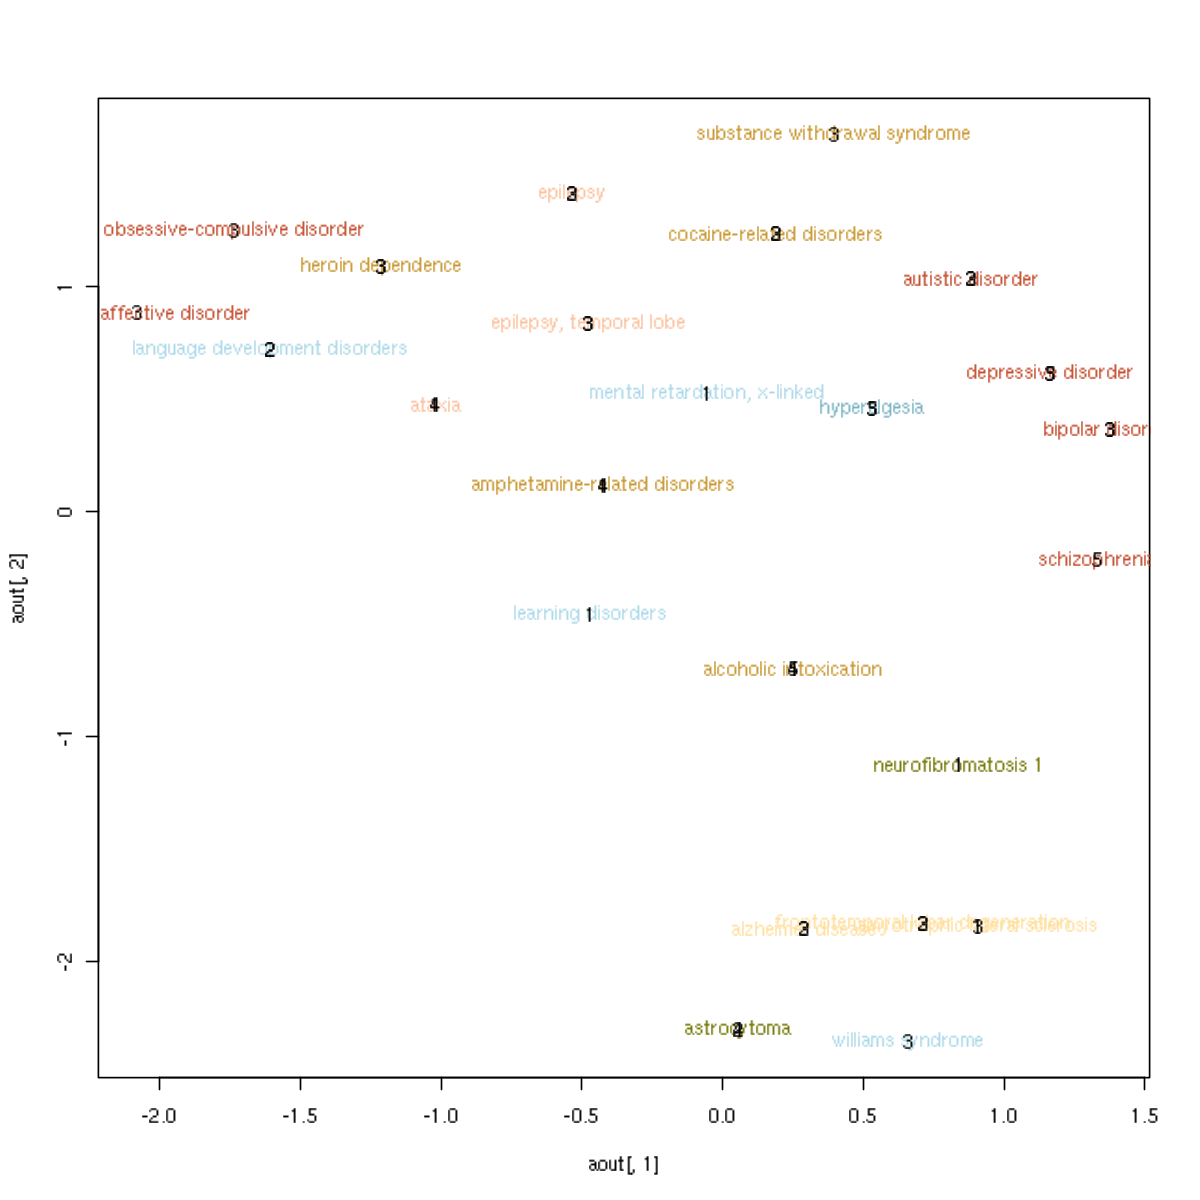

In [102]:
set.seed(100)
# avg distances 
hout=umap(celldist[ind_CTX,ind_CTX])$layout 
uout=umap(hbadist[ind_CTX,ind_CTX])$layout 
avgdist=(celldist[ind_CTX,ind_CTX]+hbadist[ind_CTX,ind_CTX])/2 
aout=umap(avgdist)$layout # UMAP of distances

options(repr.plot.width=10, repr.plot.height=10)
plot(aout[,1],aout[,2],col=mpal[hbaclus[ind_CTX]],type="n")
text(aout[,1],aout[,2],disnames[ind_CTX],col=colp[dclass[ind_CTX]])
text(aout[,1],aout[,2],hbaclus,cex=1)

dev.off()
pdf(paste(opath,"Figure_03_C.pdf",sep=""),width=7,height=7)
plot(aout[,1],aout[,2],col=mpal[hbaclus[ind_CTX]],type="n")
text(aout[,1],aout[,2],disnames[ind_CTX],col=colp[dclass[ind_CTX]])
text(aout[,1],aout[,2],hbaclus,cex=0.75)
dev.off()

## Supplementary Figure 18

### Supplementary Figure 18-A - dendrogram

In [103]:
cellin=read.csv(paste(ipath,"Disease_Cell_type_correlation_overlap_matrix.csv",sep=""))
hbain=read.csv(paste(ipath,"HBA_Disease_correlation_overlap_matrix.csv",sep=""))

cellmat=as.matrix(cellin[,2:dim(cellin)[2]],40,40)
rownames(cellmat)=as.character(cellin[,1])

hbamat=as.matrix(hbain[,2:dim(hbain)[2]],40,40)
rownames(hbamat)=as.character(hbain[,1])

cellmat = cellmat[ind_CTX,ind_CTX]
hbamat = hbamat[ind_CTX,ind_CTX]


# Generate annotations for rows and columns
annotation_col = data.frame(
  Disease = factor(disnames[ind_CTX]),
  Adglab = factor(disnames[ind_CTX])
)
rownames(annotation_col) = disnames[ind_CTX]

colvec=colp[dclass]

adgpal=c("gray100","gray85","gray60","gray30","gray0")
names(adgpal)=paste("ADG",1:5)

# Specify colors
ann_colors = list(
  Disease = colvec,
  Adglab = adgpal[hbaclus]
)

names(ann_colors$Disease)=disnames
names(ann_colors$Adglab)=disnames

In [104]:
options(repr.plot.width=6, repr.plot.height=6)
hbacor=hbamat;cellcor=cellmat;
dev.off()
pdf(paste(opath,"Supplementary_Figure_18_A_dendrogram.pdf",sep=""),width=10,height=10)
a=pheatmap(cellcor,cluster_rows=T,cluster_cols=T,col=hmcols,breaks = breaksList,
           cellwidth=10,cellheight=10,fontsize=10,
           clustering_method = "ward.D2",clustering_distance_rows = as.dist(1-cin_overlap[ind_CTX,ind_CTX]),
           clustering_distance_cols = as.dist(1-cin_overlap[ind_CTX,ind_CTX]),
           annotation_row=annotation_col,annotation_colors = ann_colors,annotation_legend = FALSE)
dev.off()

null device 
          1

null device 
          1

### Supplementary Figure 18-A

In [105]:
ord=a$tree_row$order
cor.test(cellcor[ord,ord][upper.tri(cellcor,0)],hbacor[ord,ord][lower.tri(hbacor)],method = 'spearman')


	Spearman's rank correlation rho

data:  cellcor[ord, ord][upper.tri(cellcor, 0)] and hbacor[ord, ord][lower.tri(hbacor)]
S = 3462530, p-value = 0.8445
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
0.01184915 


[1] 0.6802217

null device 
          1

null device 
          1

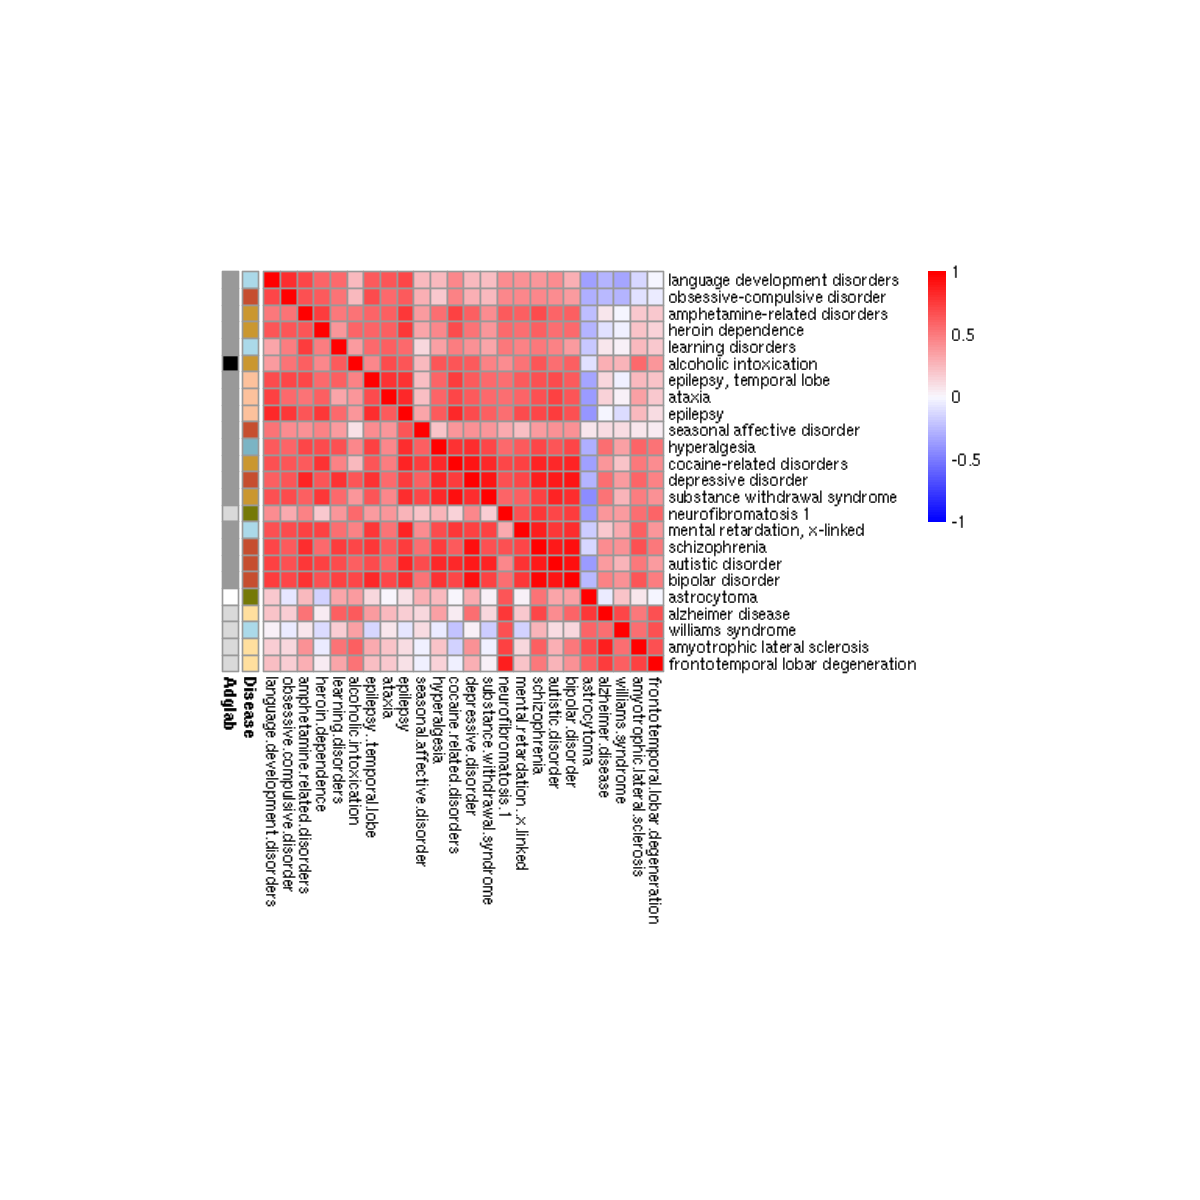

In [106]:
# as.dist(1-cor_noverlap_cor)
outcor=cellcor[ord,ord]*upper.tri(cellcor,-1)+hbacor[ord,ord]*lower.tri(hbacor)
cor(as.vector(cellcor),as.vector(hbacor))
options(repr.plot.width=10, repr.plot.height=10)
a=pheatmap(outcor,cluster_rows=F,cluster_cols=F,col=hmcols,breaks = breaksList,
           cellwidth=10,cellheight=10,fontsize=10,
           annotation_row=annotation_col,annotation_colors = ann_colors,annotation_legend = FALSE)

dev.off()
pdf(paste(opath,"Supplementary_Figure_18_A.pdf",sep=""),width=10,height=10)
a=pheatmap(outcor,cluster_rows=F,cluster_cols=F,col=hmcols,breaks = breaksList,
           cellwidth=10,cellheight=10,fontsize=10,
           annotation_row=annotation_col,annotation_colors = ann_colors,annotation_legend = FALSE)
dev.off()

### Supplementary Figure 18-B

null device 
          1

null device 
          1

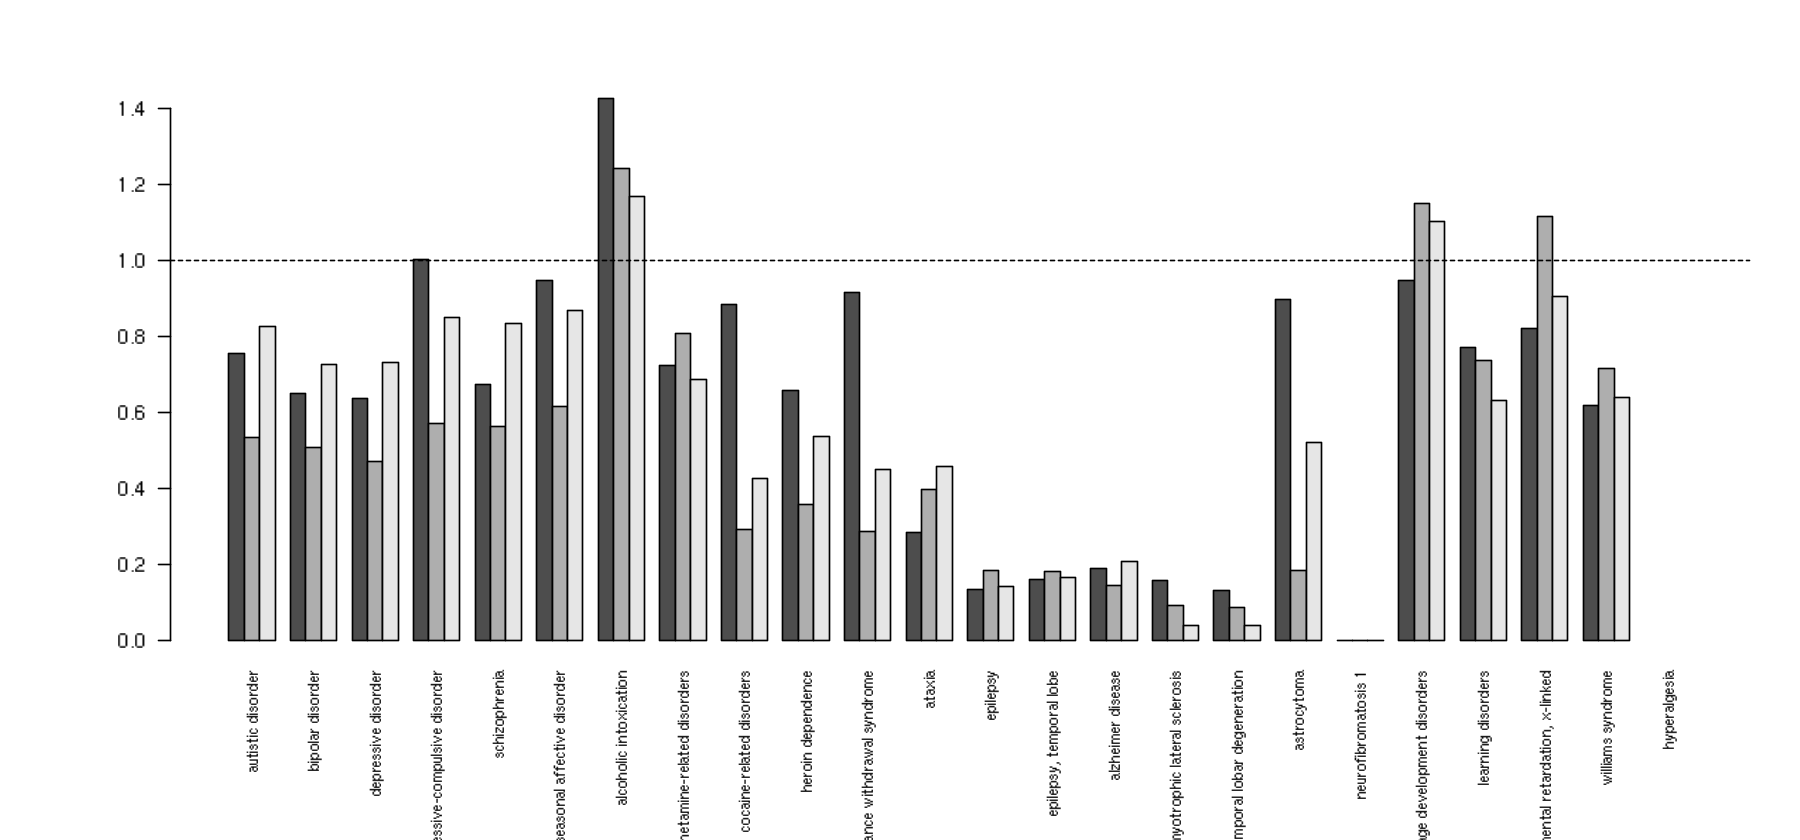

In [107]:
alldisth=matrix(0,disnum_ctx,disnum_ctx,dimnames=list(disnames[ind_CTX],disnames[ind_CTX]))
alldistu=matrix(0,disnum_ctx,disnum_ctx,dimnames=list(disnames[ind_CTX],disnames[ind_CTX]))
alldista=matrix(0,disnum_ctx,disnum_ctx,dimnames=list(disnames[ind_CTX],disnames[ind_CTX]))

hout=umap(celldist[ind_CTX,ind_CTX])$layout 
uout=umap(hbadist[ind_CTX,ind_CTX])$layout 
avgdist=(celldist[ind_CTX,ind_CTX]+hbadist[ind_CTX,ind_CTX])/2 
aout=umap(avgdist)$layout # UMAP of distances


# hout <- hout[ind_CTX,]
# uout <- uout[ind_CTX,]
# aout <- aout[ind_CTX,]

hout <- hout
uout <- uout
aout <- aout

for (i in 1:disnum_ctx) {
  for (j in 1:disnum_ctx) {
    alldisth[i,j]=sqrt((hout[i,1]-hout[j,1])^2+(hout[i,2]-hout[j,2])^2)
    alldistu[i,j]=sqrt((uout[i,1]-uout[j,1])^2+(uout[i,2]-uout[j,2])^2)
    alldista[i,j]=sqrt((aout[i,1]-aout[j,1])^2+(aout[i,2]-aout[j,2])^2)
  }
}

indisth=vector("numeric",disnum_ctx)
names(indisth)=disnames[ind_CTX]
outdisth=vector("numeric",disnum_ctx)
names(outdisth)=disnames[ind_CTX]

# HBA
for (i in 1:disnum_ctx) {
  ips=which(dclass[ind_CTX]==dclass[disnames[ind_CTX][i]])
  dvec=alldisth[i,ips][-1]
  indisth[i]=mean(dvec)
  ops=setdiff(1:disnum_ctx,ips)
  dvec=alldisth[i,ops][-1]
  outdisth[i]=mean(dvec)
}
 
hratio=indisth/outdisth


# Cell type
for (i in 1:disnum_ctx) {
  ips=which(dclass[ind_CTX]==dclass[disnames[ind_CTX][i]])
  dvec=alldistu[i,ips][-1]
  indisth[i]=mean(dvec)
  ops=setdiff(1:disnum_ctx,ips)
  dvec=alldistu[i,ops][-1]
  outdisth[i]=mean(dvec)
}
 
uratio=indisth/outdisth

# Average
for (i in 1:disnum_ctx) {
  ips=which(dclass[ind_CTX]==dclass[disnames[ind_CTX][i]])
  dvec=alldista[i,ips][-1]
  indisth[i]=mean(dvec)
  ops=setdiff(1:disnum_ctx,ips)
  dvec=alldista[i,ops][-1]
  outdisth[i]=mean(dvec)
}

ord=order(dclass[ind_CTX]) 
aratio=indisth/outdisth

fratio=rbind(rbind(hratio,uratio),aratio)

options(repr.plot.width=15, repr.plot.height=7)
par(mar=c(8, 7, 4, 2) + 0.1)
par(las=2)
barplot(fratio[,ord],beside=T,cex.names=0.75)  
abline(h=1.0,lty=2)

dev.off()
pdf(paste(opath,"Supplementary_Figure_18_B.pdf",sep=""),width=15,height=7)
par(mar=c(12, 7, 4, 2) + 0.1)
par(las=2)
barplot(fratio[,ord],beside=T,cex.names=0.75)  
abline(h=1.0,lty=2)
dev.off()

# Figure 5. Disease based cell type expression in mouse and human

In [108]:
tord=c("Lamp5","Sncg","Vip","Sst.Chodl", "Sst","Pvalb","L2.3.IT","L4.IT","L5.ET","L5.IT","L5.6.NP","L6.CT",
       "L6.IT","L6.IT.Car3","L6b","OPC", "Astrocyte","Oligo","Endothelial","Micro.PVM","Inhibitory","Excitatory")


cord=c("gliosarcoma","migraine disorders","astrocytoma","glioma","glioblastoma","dementia","multiple sclerosis","narcolepsy","tobacco use disorder",
        "learning disorders","language development disorders","obsessive-compulsive disorder","heroin dependence","ataxia","epilepsy, temporal lobe",
        "neuralgia","seasonal affective disorder","frontotemporal lobar degeneration","alzheimer disease","williams syndrome","amnesia","alcoholic intoxication",
        "depressive disorder","hyperalgesia","amyotrophic lateral sclerosis","spastic paraplegia, hereditary","huntington disease",
        "marijuana abuse","parkinsonian disorders","dystonia","substance withdrawal syndrome", "amphetamine-related disorders",
        "cocaine-related disorders","epilepsy","neurofibromatosis 1","parkinson disease","mental retardation, x-linked",
        "schizophrenia","autistic disorder","bipolar disorder")


In [109]:
meff=read.csv(paste(ipath,"EWCE_subclass_mouse.csv",sep=""))
heff=read.csv(paste(ipath,"EWCE_subclass_human.csv",sep=""))

meff = meff[ind_CTX,]
heff = heff[ind_CTX,]

# can also cluster by EWCE values directly
matmeff=meff[,-1]
rownames(matmeff)=as.character(meff[,1])

thresh=2.5
matmefft=matmeff
for (i in 1:dim(matmeff)[1]) {
  for (j in 1:dim(matmeff)[2]) {
    if (matmeff[i,j]> thresh) {matmefft[i,j]=thresh}
    if (matmeff[i,j]<  -thresh) {matmefft[i,j]= -thresh}
  }
}

hatmeff=heff[,-1]
rownames(hatmeff)=as.character(heff[,1])

thresh=2.5
hatmefft=hatmeff
for (i in 1:dim(hatmeff)[1]) {
  for (j in 1:dim(hatmeff)[2]) {
    if (hatmeff[i,j]> thresh) {hatmefft[i,j]=thresh}
    if (hatmeff[i,j]<  -thresh) {hatmefft[i,j]= -thresh}
  }
}

### Figure 5-C

In [110]:
hlab=paste(disnames[ind_CTX],"human")
mlab=paste(disnames[ind_CTX],"mouse")

mlab = mlab
hlab = hlab

rownames(matmeff)=mlab
rownames(hatmeff)=hlab


cmat=as.matrix(rbind(matmeff,hatmeff))

for (i in 1:dim(cmat)[1]) {
  cmat[i,]=(cmat[i,]-mean(cmat[i,]))/sd(cmat[i,])
}


# Generate annotations for rows and columns
annotation_col = data.frame(
  Disease = factor(c(mlab,hlab)),
  Adglab = factor(c(mlab,hlab)),
  Ctglab = factor(c(mlab,hlab))
)

rownames(annotation_col) = c(mlab,hlab)

colvec=c(colp[dclass],colp[dclass])

adgpal=c("gray100","gray85","gray60","gray30","gray0")
names(adgpal)=paste("ADG",1:5)
ctgpal=c("gray90","gray75","gray50","gray25")
names(ctgpal)=paste("CTG",1:4)


# Specify colors
ann_colors = list(
  Disease = colvec[c(ind_CTX,40+ind_CTX)],
  Adglab = adgpal[c(hbaclus[ind_CTX],hbaclus[ind_CTX])],
  Ctglab = ctgpal[c(cgrpvec[ind_CTX],cgrpvec[ind_CTX])]
)

names(ann_colors$Disease)=c(mlab,hlab)
names(ann_colors$Adglab)=c(mlab,hlab)
names(ann_colors$Ctglab)=c(mlab,hlab)

null device 
          1

null device 
          1

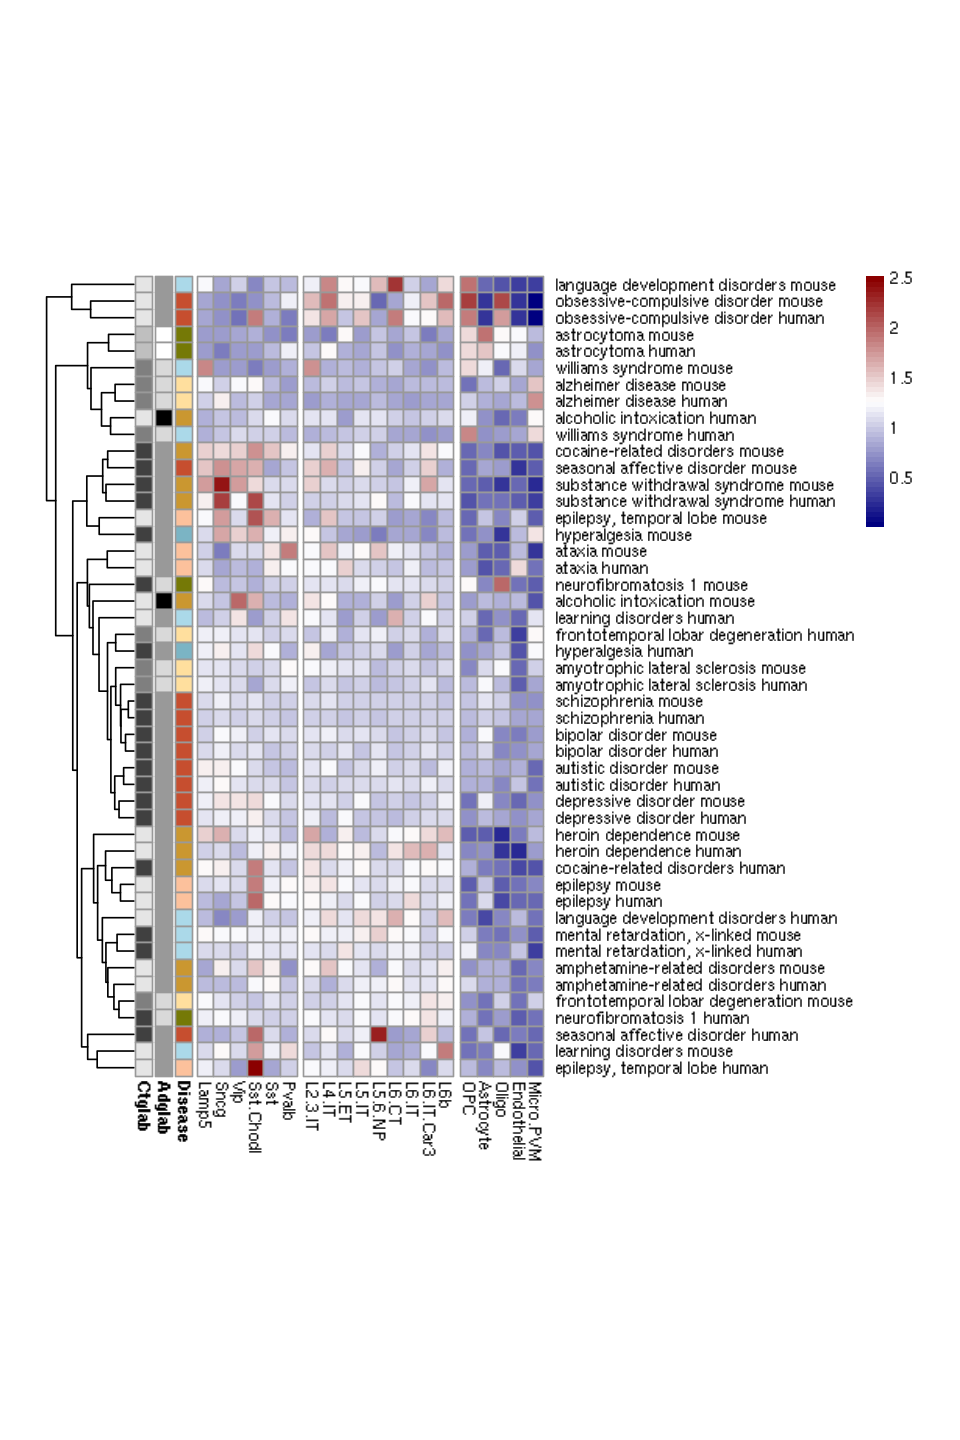

In [111]:
meff=read.csv(paste(ipath,"EWCE_subclass_mouse.csv",sep=""))
heff=read.csv(paste(ipath,"EWCE_subclass_human.csv",sep=""))

meff = meff[ind_CTX,]
heff = heff[ind_CTX,]

# can also cluster by EWCE values directly
matmeff=meff[,-1];rownames(matmeff)=as.character(meff[,1])
hatmeff=heff[,-1];rownames(hatmeff)=as.character(heff[,1])

hlab=paste(disnames[ind_CTX],"human")
mlab=paste(disnames[ind_CTX],"mouse")

mlab = mlab
hlab = hlab

rownames(matmeff)=mlab
rownames(hatmeff)=hlab

cmat = rbind(matmeff,hatmeff)

colr=colorRampPalette(c("navy","white","darkred"))(50)
options(repr.plot.width=8, repr.plot.height=12)

pheatmap(cmat[,tord[-c(21,22)]],
         cluster_cols = FALSE,color=colr,annotation_row=annotation_col,
         cellwidth=10,cellheight=10,fontsize=10,
         annotation_legend=F,annotation_colors=ann_colors,gaps_col=c(6,15,20))

breaksList = seq(-3,3, by = 6/length(hmcols))

dev.off()
pdf(paste(opath,"Figure_05_C_new.pdf",sep=""),width=12,height=12)
pheatmap(cmat[,tord[-c(21,22)]],
         cluster_cols = FALSE,color=colr,annotation_row=annotation_col,
         cellwidth=10,cellheight=10,fontsize=10,
         annotation_legend=F,annotation_colors=ann_colors,gaps_col=c(6,15,20))
dev.off()

In [112]:
Dis_Reg_subclass_human  <- read.csv(paste(ipath,"Cell_human_subclass_expression.csv",sep=""))
d_names_h <- Dis_Reg_subclass_human$X
rownames(Dis_Reg_subclass_human) <- d_names_h
Dis_Reg_subclass_human <- Dis_Reg_subclass_human[is.element(rownames(Dis_Reg_subclass_human),CTX_dis$disease),]
d_names_h <- rownames(Dis_Reg_subclass_human)
d_names_h <- unlist(lapply(d_names_h, function(x) paste(x,'human',sep=" ")))
Dis_Reg_subclass_human <- Dis_Reg_subclass_human[,-1]
rownames(Dis_Reg_subclass_human) <- d_names_h

Dis_Reg_subclass_mouse  <- read.csv(paste(ipath,"Cell_mouse_subclass_expression.csv",sep=""))                           
d_names_m <- rownames(Dis_Reg_subclass_mouse)
Dis_Reg_subclass_mouse <- Dis_Reg_subclass_mouse[ind_CTX,]
d_names_m <- disnames[ind_CTX]                
d_names_m <- unlist(lapply(d_names_m, function(x) paste(x,'mouse',sep=" ")))      
rownames(Dis_Reg_subclass_mouse) <- d_names_m                      

Dis_Reg_matrix_hm  <- rbind(Dis_Reg_subclass_human,Dis_Reg_subclass_mouse)


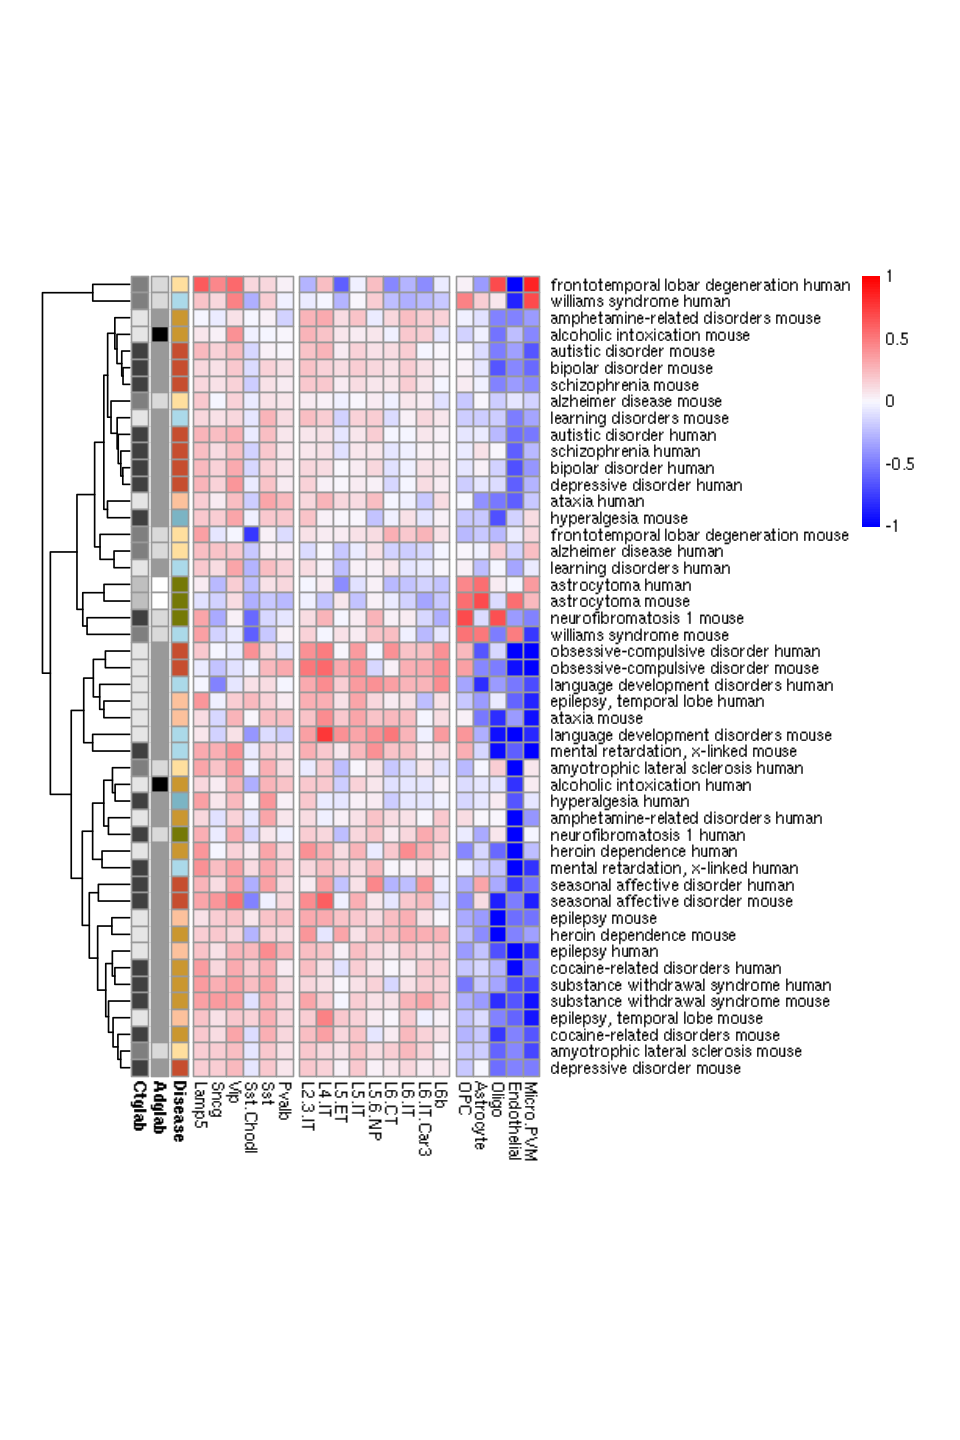

In [113]:
breaksList = seq(-1, 1, by = 2/length(hmcols))


pheatmap(Dis_Reg_matrix_hm[,tord[-c(21,22)]],color=hmcols,cluster_cols=F,breaks=breaksList,
         cluster_rows=T,annotation_row=annotation_col,
         cellwidth=10,cellheight=10,fontsize=10,
         annotation_legend=F,annotation_colors=ann_colors,gaps_col=c(6,15,20))

### Supplementary Figure 20. B

In [114]:
meff=read.csv(paste(ipath,"EWCE_subclass_mouse.csv",sep=""))
heff=read.csv(paste(ipath,"EWCE_subclass_human.csv",sep=""))

msig=read.csv(paste(ipath,"EWCE_subclass_p_mouse.csv",sep=""))
hsig=read.csv(paste(ipath,"EWCE_subclass_p_human.csv",sep=""))
mmat=as.matrix(msig[,-1])
hmat=as.matrix(hsig[,-1])
dnames=as.character(meff[,1])

# enrichment comparison - mouse/human
dsetm=as.vector(as.matrix(meff[,-1]))
dseth=as.vector(as.matrix(heff[,-1]))
rcode=as.vector(row(as.matrix(heff[,-1])))

# absolute value differences 
omat=order(abs(dsetm-dseth),decreasing=T)
smat=sort(abs(dsetm-dseth),decreasing=T) 
rns=as.vector(row(as.matrix(meff[,-1])))

msigc=read.csv(paste(ipath,"EWCE_class_p_mouse.csv",sep=""))
hsigc=read.csv(paste(ipath,"EWCE_class_p_human.csv",sep=""))
mmatc=as.matrix(msigc[,-1])
hmatc=as.matrix(hsigc[,-1]) 

mmatco=cbind(mmat,mmatc[,4],mmatc[,3])
dimnames(mmatco)[2][[1]][21]="Inhibitory"
dimnames(mmatco)[2][[1]][22]="Excitatory"

hmatco=cbind(hmat,hmatc[,4],hmatc[,3])
dimnames(hmatco)[2][[1]][21]="Inhibitory"
dimnames(hmatco)[2][[1]][22]="Excitatory"

In [115]:
effs=0.01 # significance threshold


smatm=matrix(0,dim(mmatco)[1],dim(mmatco)[2],dimnames=list(dnames,colnames(mmatco)))
smath=matrix(0,dim(hmatco)[1],dim(hmatco)[2],dimnames=list(dnames,colnames(hmatco)))


for (i in 1:dim(mmatco)[1]) {
  for(j in 1:dim(mmatco)[2]) {
    if (mmatco[i,j] <  effs) {
      smatm[i,j]=mmatco[i,j]
      #print (c(smatm[i,j],disnames[i],colnames(mmatco)[j]))
    }
    if (hmatco[i,j] <  effs) {
      smath[i,j]=hmatco[i,j]
      # print (c(smatm[i,j],disnames[i],colnames(mmatco)[j]))
    }
    
  }
}

sigcodemat=matrix(0,length(disnames),dim(mmatco)[2],dimnames=list(disnames,colnames(mmatco)))

for (i in 1:dim(hmatco)[1]) {
  for (j in 1:dim(hmatco)[2]){
    if (smatm[i,j]>0) {
      sigcodemat[i,j]=1
     # print (c("mouse",smatm[i,j],disnames[i],colnames(mmatco)[j]))
    }
    if (smath[i,j]>0) {
      sigcodemat[i,j]=2
     # print (c("human",smath[i,j],disnames[i],colnames(hmatco)[j]))
    }
    if ((smath[i,j]>0) && (smatm[i,j]>0)) {
      sigcodemat[i,j]=3
    }
  }
}


# Generate annotations for rows and columns
annotation_col = data.frame(
  Disease = factor(disnames),
  Adglab = factor(disnames),
  Ctglab = factor(disnames)
)
rownames(annotation_col) = disnames

colvec=colp[dclass]

adgpal=c("gray100","gray85","gray60","gray30","gray0")
names(adgpal)=paste("ADG",1:5)
ctgpal=c("gray90","gray75","gray50","gray25")
names(ctgpal)=paste("CTG",1:4)


# Specify colors
ann_colors = list(
  Disease = colvec,
  Adglab = adgpal[hbaclus],
  Ctglab = ctgpal[c(cgrpvec,cgrpvec)]
)

names(ann_colors$Disease)=disnames
names(ann_colors$Adglab)=disnames
names(ann_colors$Ctglab)=disnames

tord=c("Lamp5","Sncg","Vip","Sst.Chodl", "Sst","Pvalb","L2.3.IT","L4.IT","L5.ET","L5.IT","L5.6.NP","L6.CT",
       "L6.IT","L6.IT.Car3","L6b","OPC", "Astrocyte","Oligo","Endothelial","Micro.PVM","Inhibitory","Excitatory")


cord=c("gliosarcoma","migraine disorders","astrocytoma","glioma","glioblastoma","dementia","multiple sclerosis","narcolepsy","tobacco use disorder",
        "learning disorders","language development disorders","obsessive-compulsive disorder","heroin dependence","ataxia","epilepsy, temporal lobe",
        "neuralgia","seasonal affective disorder","frontotemporal lobar degeneration","alzheimer disease","williams syndrome","amnesia","alcoholic intoxication",
        "depressive disorder","hyperalgesia","amyotrophic lateral sclerosis","spastic paraplegia, hereditary","huntington disease",
        "marijuana abuse","parkinsonian disorders","dystonia","substance withdrawal syndrome", "amphetamine-related disorders",
        "cocaine-related disorders","epilepsy","neurofibromatosis 1","parkinson disease","mental retardation, x-linked",
        "schizophrenia","autistic disorder","bipolar disorder")

null device 
          1

null device 
          1

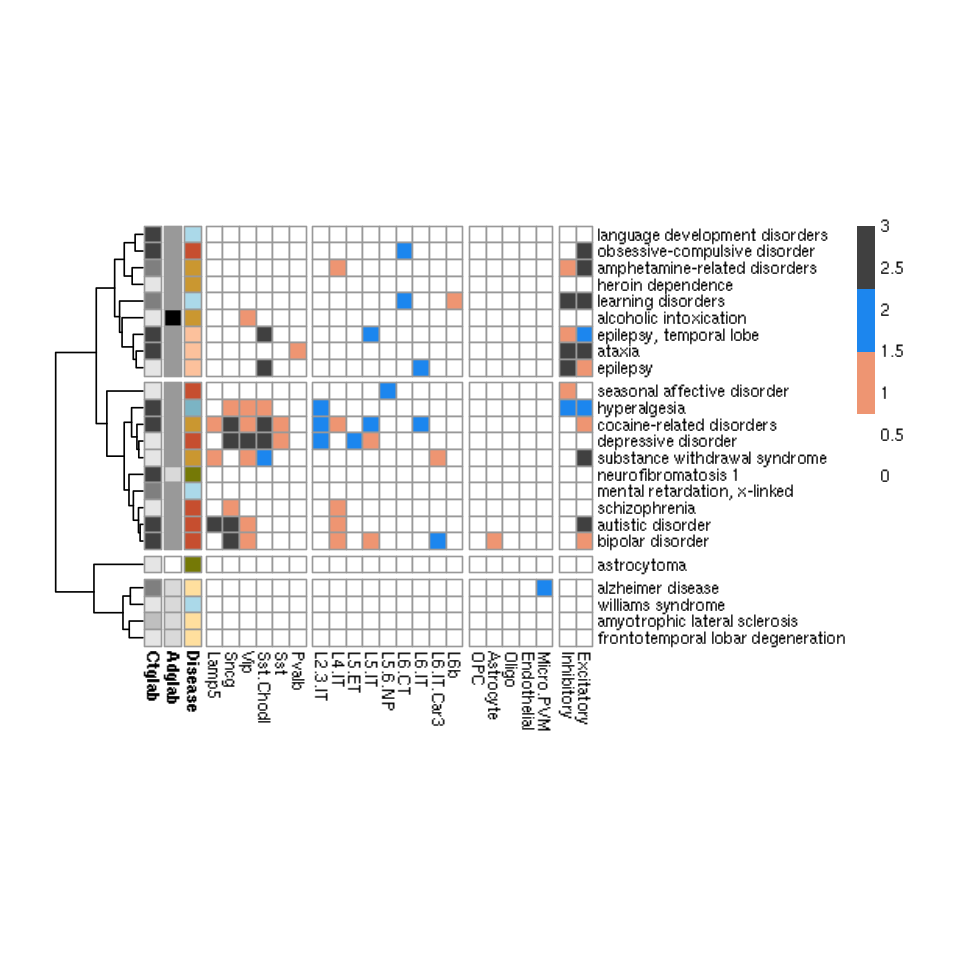

In [116]:
options(repr.plot.width=8, repr.plot.height=8)
mpal=c("white","lightsalmon2","dodgerblue2","gray25")
# pheatmap(sigcodemat[cord,tord],cluster_rows=F,cluster_cols=F,col=mpal,annotation_row=annotation_col,
#          annotation_colors = ann_colors,annotation_legend = FALSE,gaps_row=c(7,17,26),gaps_col=c(6,15,20))
pheatmap(sigcodemat[ind_CTX,tord],clustering_method = "ward.D2",
         clustering_distance_rows = as.dist(1-cin_overlap[ind_CTX,ind_CTX]),cutree_rows =4,
         cluster_cols=F,col=mpal,annotation_row=annotation_col,
         cellwidth=10,cellheight=10,fontsize=10,
         annotation_colors = ann_colors,annotation_legend = FALSE,gaps_col=c(6,15,20))

dev.off()
pdf(paste(opath,"Supplementary_Figure_20_B.pdf",sep=""),width=8,height=8)
mpal=c("white","lightsalmon2","dodgerblue2","gray25")

pheatmap(sigcodemat[ind_CTX,tord],clustering_method = "ward.D2",
         clustering_distance_rows = as.dist(1-cin_overlap[ind_CTX,ind_CTX]),cutree_rows =4,
         cluster_cols=F,col=mpal,annotation_row=annotation_col,
         cellwidth=10,cellheight=10,fontsize=10,
         annotation_colors = ann_colors,annotation_legend = FALSE,gaps_col=c(6,15,20))
dev.off()

In [117]:
write.csv(sigcodemat[ind_CTX,tord],paste(opath,"Figure_04_C.csv",sep=""))
write.csv(mmatco[,tord],paste(opath,"Figure_04_C_mouse_p.csv",sep=""))
write.csv(hmatco[,tord],paste(opath,"Figure_04_C_human_p.csv",sep=""))

In [118]:
msigc_sub=read.csv(paste(ipath,"EWCE_subclass_p_mouse.csv",sep=""))
hsigc_sub=read.csv(paste(ipath,"EWCE_subclass_p_human.csv",sep=""))
msigc_sub <- msigc_sub[ind_CTX,-1]
hsigc_sub <- hsigc_sub[ind_CTX,-1]

msigc=read.csv(paste(ipath,"EWCE_class_p_mouse.csv",sep=""))
hsigc=read.csv(paste(ipath,"EWCE_class_p_human.csv",sep=""))
mmatc=as.matrix(msigc[ind_CTX,-1])
hmatc=as.matrix(hsigc[ind_CTX,-1]) 

thresh <- 0.01
mouse_sub = 1*(t(apply(msigc_sub,1,p.adjust,'fdr')<thresh))
rownames(mouse_sub) <- inord$alphabetical_disease[ind_CTX]
rownames(mmatc) <- inord$alphabetical_disease[ind_CTX]
dimnames(mmatc)[2][[1]][4]="Inhibitory"
dimnames(mmatc)[2][[1]][3]="Excitatory"
mouse_c <- 1*(t(apply(mmatc[inord$cell_cluster_order[ind_CTX],],1,p.adjust,'fdr')<thresh))[,c(4,3)]
mouse_all <- cbind(mouse_sub,mouse_c)
# mouse_all

human_sub = 1*(t(apply(hsigc_sub,1,p.adjust,'fdr')<thresh))
rownames(human_sub) <- inord$alphabetical_disease[ind_CTX]
rownames(hmatc) <- inord$alphabetical_disease[ind_CTX]
dimnames(hmatc)[2][[1]][4]="Inhibitory"
dimnames(hmatc)[2][[1]][3]="Excitatory"
human_c <- 1*(t(apply(hmatc[inord$cell_cluster_order[ind_CTX],],1,p.adjust,'fdr')<thresh))[,c(4,3)]
human_all <- cbind(human_sub,human_c)


write.csv(mouse_all[inord$cell_cluster_order_overlap[ind_CTX],tord],paste(opath,"EWCE_mouse_q_01.csv",sep=""))
write.csv(human_all[inord$cell_cluster_order_overlap[ind_CTX],tord],paste(opath,"EWCE_human_q_01.csv",sep=""))

# pheatmap(mouse_all[inord$cell_cluster_order_overlap,tord],cluster_rows = F,cluster_cols = F)
# pheatmap(human_all[inord$cell_cluster_order,tord[1:20]],cluster_rows = F,cluster_cols = F)
# pheatmap(all[inord$cell_cluster_order_overlap,tord[1:20]],cluster_rows = F,cluster_cols = F)#_overlap

In [119]:
# basic analysis of this matrix
amat=sigcodemat[ind_CTX,tord]#sigcodemat[cord,tord]
inm=sum(amat[,1:6]==1)
inh=sum(amat[,1:6]==2)
inb=sum(amat[,1:6]==3)

enm=sum(amat[,7:15]==1)
enh=sum(amat[,7:15]==2)
enb=sum(amat[,7:15]==3)

nnm=sum(amat[,16:20]==1)
nnh=sum(amat[,16:20]==2)
nnb=sum(amat[,16:20]==3)

# apply(amat==1,2,sum)
# apply(amat==2,2,sum)
# apply(amat==3,2,sum)

# enriched cell types in either species
mcs=apply(smatm>0,2,sum)
hcs=apply(smath>0,2,sum)

# c(inm+inb,enm+enb)
# c(inh+inb,enh+enb)

inhibs=apply(sigcodemat[ind_CTX,tord[1:6]]>0,1,sum)
excits=apply(sigcodemat[ind_CTX,tord[7:15]]>0,1,sum)
 
sumt=apply(sigcodemat[ind_CTX,tord]>0,2,sum)

# options(repr.plot.width=8, repr.plot.height=4)
# par(las=2)
# barplot(sumt,col=c(rep("#3A53A4",6),rep("#ED2224",9),"#D15627","#7E3E98","#137A66","#808233","#F0C419","#3A53A4","#ED2224"))

# dev.off()
# pdf(paste(opath,"Supplementary_Figure_20_B_Top_old.pdf",sep=""),width=8,height=4)
# par(las=2)
# barplot(sumt,col=c(rep("#3A53A4",6),rep("#ED2224",9),"#D15627","#7E3E98","#137A66","#808233","#F0C419","#3A53A4","#ED2224"))
# dev.off()

### Figure 5-D - upper panel

null device 
          1

null device 
          1

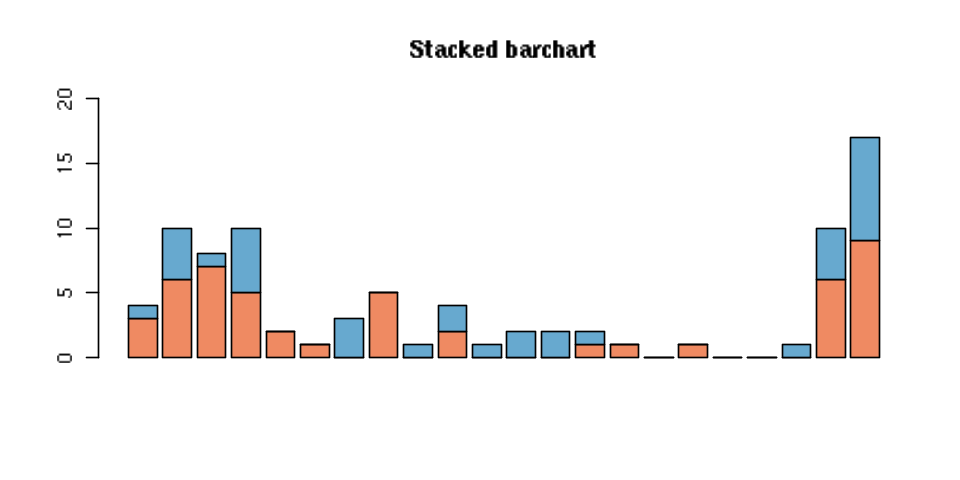

In [120]:
ecwe_c <- rbind(colSums(sigcodemat[ind_CTX,]==1)+colSums(sigcodemat[ind_CTX,]==3),
                colSums(sigcodemat[ind_CTX,]==2)+colSums(sigcodemat[ind_CTX,]==3))

options(repr.plot.width=8, repr.plot.height=4)
barplot(ecwe_c[,tord],
        main = "Stacked barchart",
        col = c("#EF8A62", "#67A9CF"),ylim = c(0,20),axisnames = FALSE,
        beside = FALSE)

dev.off()
pdf(paste(opath,"Supplementary_Figure_20_B_Top.pdf",sep=""),width=8,height=4)
par(las=2)
barplot(ecwe_c[,tord],main = "Stacked barchart",
        col = c("#EF8A62", "#67A9CF"),ylim = c(0,20),axisnames = FALSE,
        beside = FALSE)
dev.off()

### Figure 5-B

In [121]:
meff=read.csv(paste(ipath,"EWCE_subclass_mouse.csv",sep=""))
heff=read.csv(paste(ipath,"EWCE_subclass_human.csv",sep=""))
# enrichment comparison - mouse/human
dsetm=as.vector(as.matrix(meff[ind_CTX,-1]))
dseth=as.vector(as.matrix(heff[ind_CTX,-1]))
rcode=as.vector(row(as.matrix(heff[ind_CTX,-1])))

null device 
          1

null device 
          1

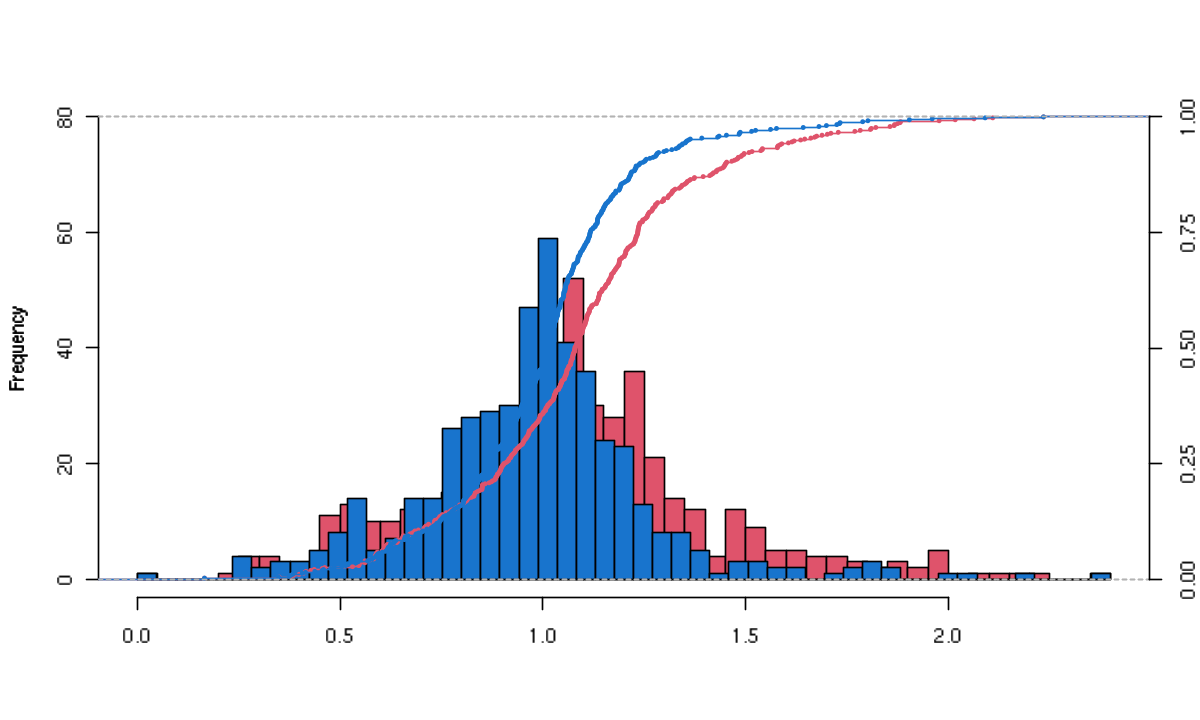

In [122]:
# mouse human EWCE distribution 
options(repr.plot.width=10, repr.plot.height=6)

hist(dsetm,nclass=50,ylim=c(0,80),main="",xlab="",col=2)
par(new=T)
hist(dseth,nclass=50,ylim=c(0,80),col="dodgerblue3",axes=F,main="",xlab="")
par(new=T)
plot(ecdf(dsetm),lty=1,cex=0.25,col=2,main="",xlab="",ylab="",axes=F)
par(new=T)
plot(ecdf(dseth),lty=1,cex=0.25,col="dodgerblue3",main="",xlab="",ylab="",axes=F)
axis(4,at=seq(0,1,0.25))

dev.off()
pdf(paste(opath,"Figure_05_B.pdf",sep=""),width=10,height=6)
hist(dsetm,nclass=50,ylim=c(0,80),main="",xlab="",col=2)
par(new=T)
hist(dseth,nclass=50,ylim=c(0,80),col="dodgerblue3",axes=F,main="",xlab="")
par(new=T)
plot(ecdf(dsetm),lty=1,cex=0.25,col=2,main="",xlab="",ylab="",axes=F)
par(new=T)
plot(ecdf(dseth),lty=1,cex=0.25,col="dodgerblue3",main="",xlab="",ylab="",axes=F)
axis(4,at=seq(0,1,0.25))
dev.off()

In [123]:
ks.test(dsetm,dseth)


	Two-sample Kolmogorov-Smirnov test

data:  dsetm and dseth
D = 0.091667, p-value = 0.03543
alternative hypothesis: two-sided


# Figure 4. Cell type profile of autism, bipolar, and schizophrenia in human MTG

In [124]:
indir=paste(ipath,"Three_psychiatric_disorders/",sep="")
indat_bipolar=read.csv(paste(indir,'/bipolar_disorder.csv',sep=""))
rownames(indat_bipolar) <- indat_bipolar[,1];indat_bipolar <- indat_bipolar[,-1]
indat_autism=read.csv(paste(indir,'/autistic_disorder.csv',sep=""))
rownames(indat_autism) <- indat_autism[,1];indat_autism <- indat_autism[,-1]
indat_schizophrenia=read.csv(paste(indir,'/schizophrenia.csv',sep=""))
rownames(indat_schizophrenia) <- indat_schizophrenia[,1];indat_schizophrenia <- indat_schizophrenia[,-1]

In [125]:
u_gene_autism <- setdiff(rownames(indat_autism),unlist(list(rownames(indat_bipolar), rownames(indat_schizophrenia))))
u_gene_bipolar <- setdiff(rownames(indat_bipolar),unlist(list(rownames(indat_schizophrenia), rownames(indat_autism))))
u_gene_schizophrenia <- setdiff(rownames(indat_schizophrenia),unlist(list(rownames(indat_bipolar), rownames(indat_autism))))

In [126]:
cosine_autism <- 1*(cosine(as.matrix(t(scale(t(indat_autism[u_gene_autism,])))))>.5)
cosine_bipolar <- 1*(cosine(as.matrix(t(scale(t(indat_bipolar[u_gene_bipolar,])))))>.5)
cosine_schizophrenia <- 1*(cosine(as.matrix(t(scale(t(indat_schizophrenia[u_gene_schizophrenia,])))))>.5)
cosine_all <- cosine_autism + 2*cosine_bipolar + 4*cosine_schizophrenia

In [127]:
# d3_colors <- c('white','red','green','yellow','blue','magenta','cyan','black')
d3_colors <- c('white','cyan','slateblue1','blue','goldenrod1','green','red','black')
ccoltype_inh <- ccoltype[1:45]
ccoltype_exc <- ccoltype[46:69]
ccoltype_nn <- ccoltype[70:75]

### Figure 4-A

null device 
          1

null device 
          1

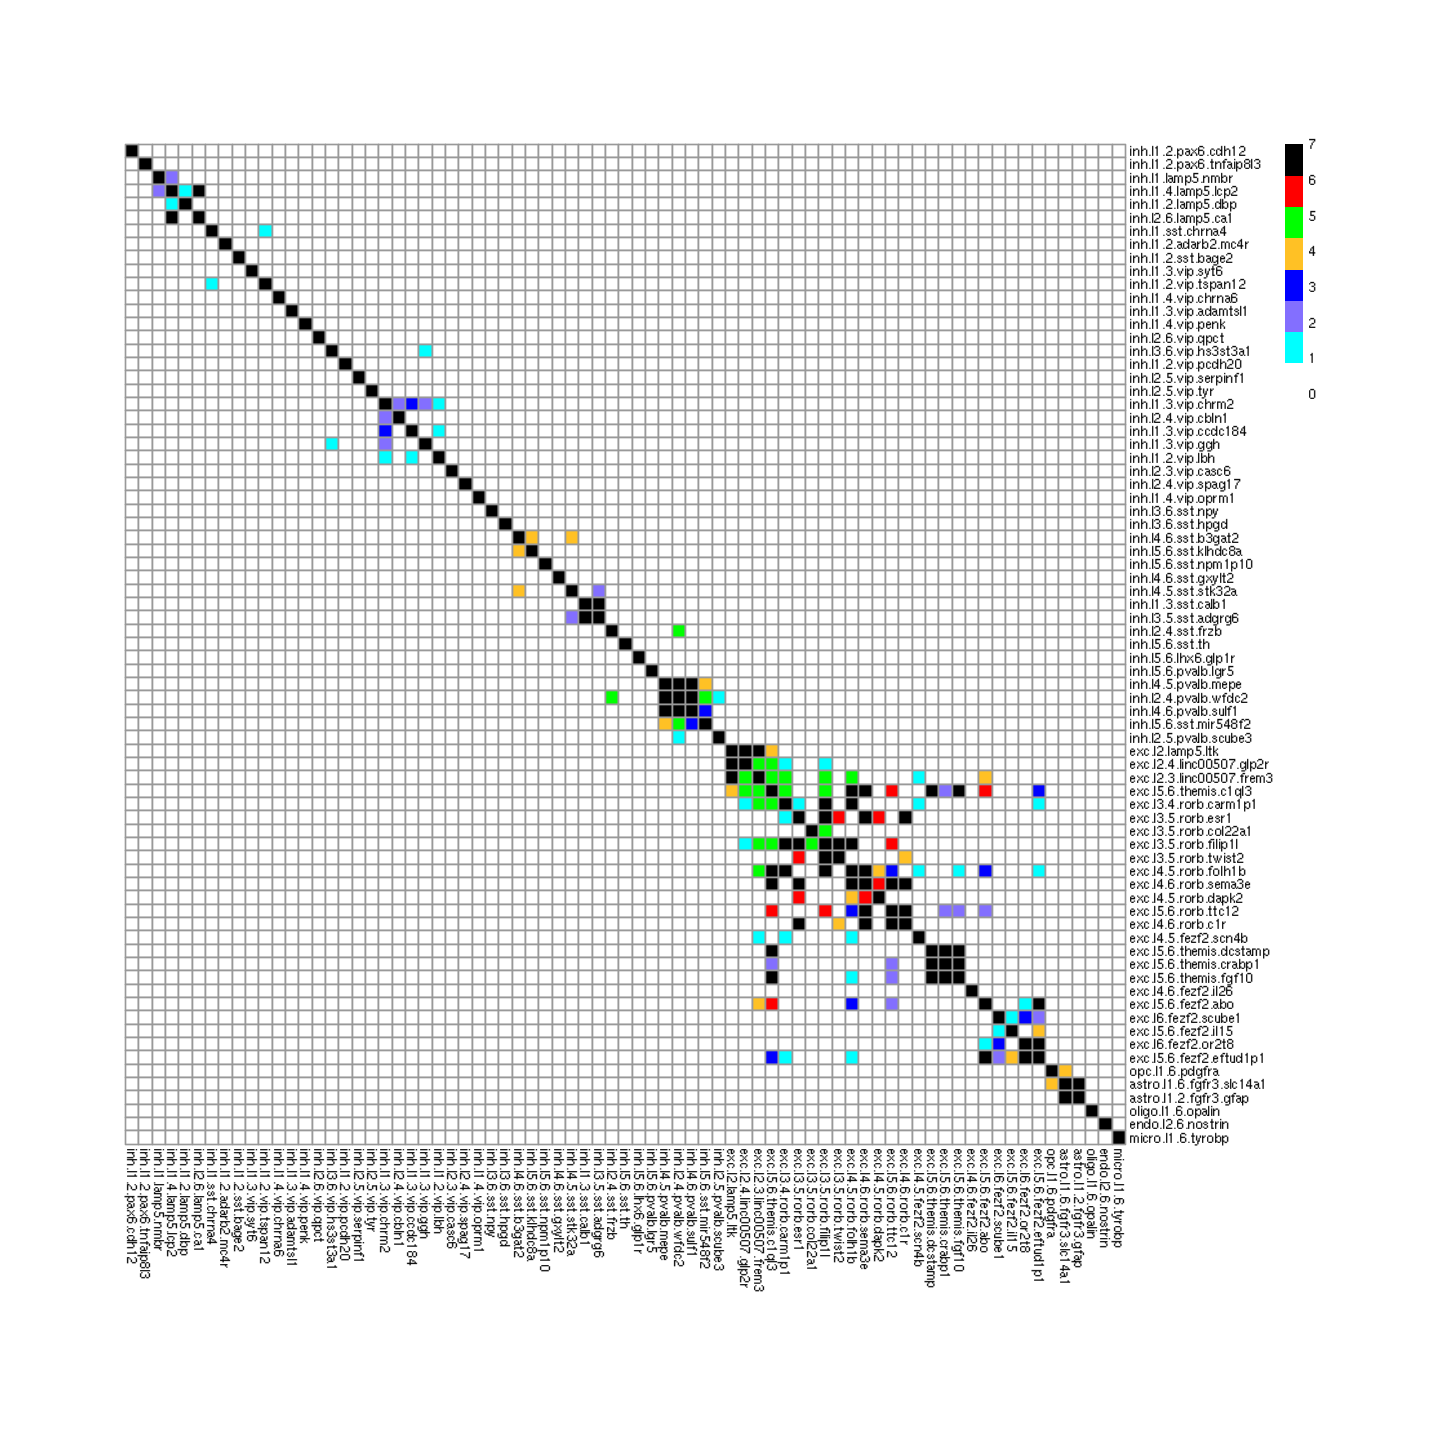

In [128]:
breaksList = seq(0,7, by = 7/8)

options(repr.plot.width=12, repr.plot.height=12)
pheatmap(cosine_all[colnames(indat_bipolar),colnames(indat_bipolar)],
         col=d3_colors,cluster_rows = F,cluster_cols = F,
         cellwidth=8,cellheight=8,fontsize=8,breaks= breaksList)
dev.off()
pdf(paste(opath,"Figure_4_A.pdf",sep=""),width=15,height=15)
pheatmap(cosine_all[colnames(indat_bipolar),colnames(indat_bipolar)],
         col=d3_colors,cluster_rows = F,cluster_cols = F,
         cellwidth=10,cellheight=10,fontsize=10,breaks= breaksList)
dev.off()

### Figure 4-B

null device 
          1

null device 
          1

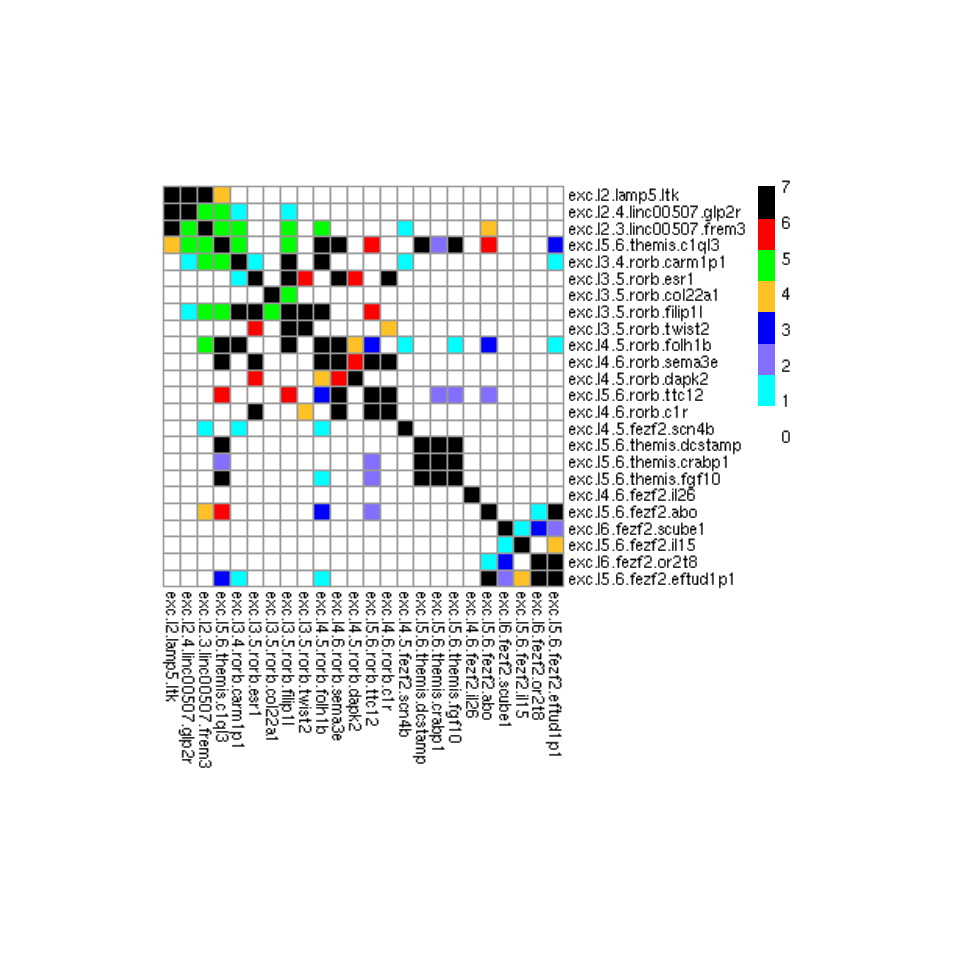

In [129]:
options(repr.plot.width=8, repr.plot.height=8)
pheatmap(cosine_all[colnames(indat_bipolar)[46:69],colnames(indat_bipolar)[46:69]],
         col=d3_colors,cluster_rows = F,cluster_cols = F,annotation_colors=ann_colors,
         cellwidth=10,cellheight=10,fontsize=10,breaks= breaksList)

dev.off()
pdf(paste(opath,"Figure_4_B.pdf",sep=""),width=10,height=10)
pheatmap(cosine_all[colnames(indat_bipolar)[46:69],colnames(indat_bipolar)[46:69]],
         col=d3_colors,cluster_rows = F,cluster_cols = F,annotation_colors=ann_colors,
         cellwidth=10,cellheight=10,fontsize=10,breaks= breaksList)
dev.off()

### Supplementary Figure 19. Expression profile of unique genes in autism, bipolar disorder, and schizophrenia (Figures flipped horizontally in the supplementary document)

In [130]:
u_gene_autism_high <- c('MYO1D','IMMP2L','MBD3','WNT2','MACROD2','SEMA5A','SNTG2',
                  'PRLR','PLAUR','ITGA4','IL15',
                  'TSC1','CHD8','MECP2','PTCHD1','NTF4','LAMB1','CALCA','HTR1D')
u_gene_bipolar_high <- c('PER3','PTGDS','CUX2','BCHE','VGF','CHRNA2','TSPO','AGT','CRY1','ADRA2C','TLL2','STAB1',
                  'NOS3','ROR1','SPR','BDKRB2','NOD2','SFRP1','VDR','FGF20')
u_gene_schizophrenia_high <- c('BTBD9','ARC','CHAT','GRM2','APBA2','HOMER1','DCDC2','SLC6A5','NRN1','ADORA2A','RGS9','PAH','SLC30A3',
                   'RTN4R','SEMA3A','RANBP9','FAS','SLIT3','TPT1','RTKN2','CAV1','PDE4D','APOA4','LPL','MICB')

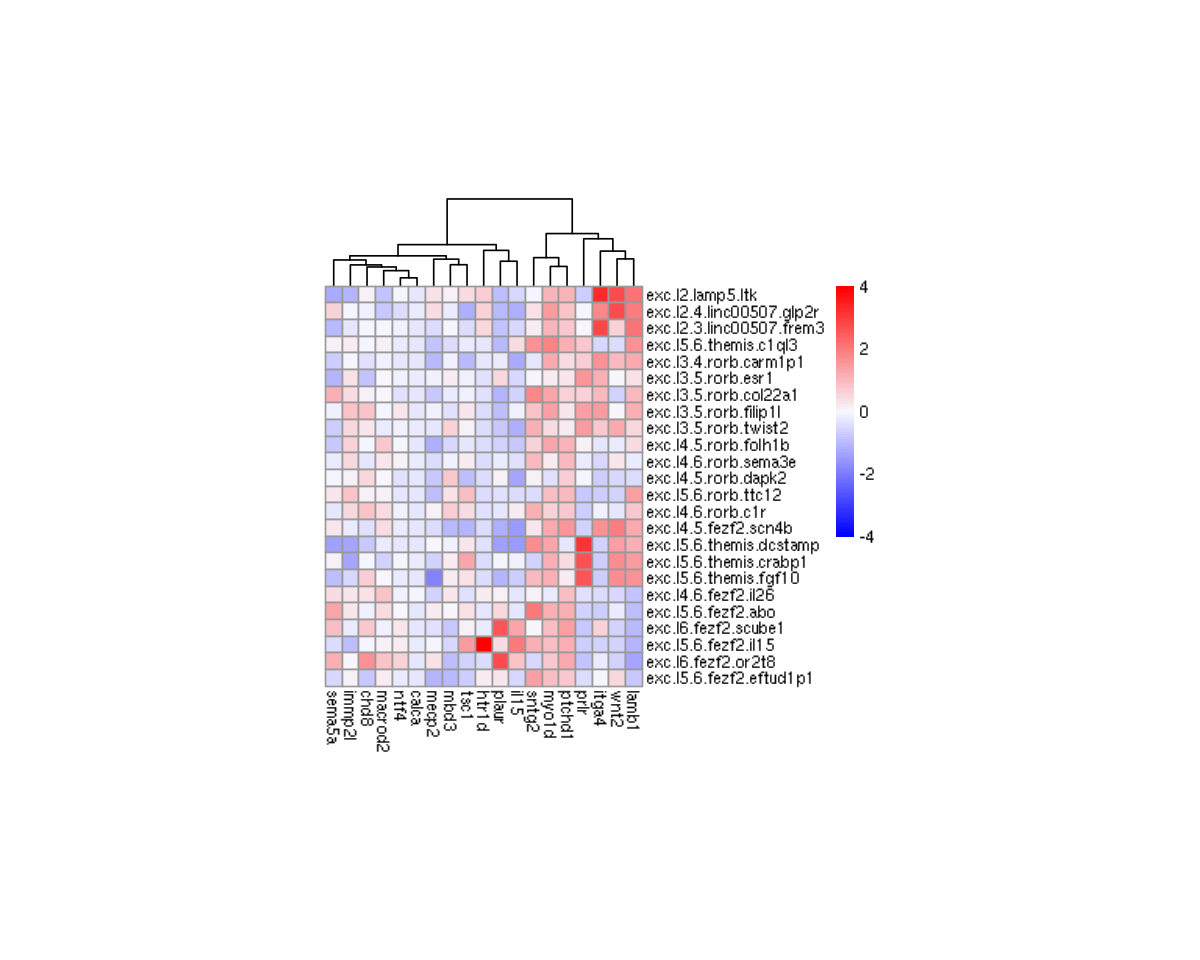

In [131]:
options(repr.plot.width=10, repr.plot.height=8)

breaksList = seq(-4, 4, by = 8/length(hmcols))

pheatmap(scale(t(indat_autism))[colnames(indat_autism)[46:69],tolower(u_gene_autism_high)],
         cluster_cols=T,cluster_rows=F,clustering_method = "ward.D2",
         color=hmcols,breaks=breaksList,
         cellwidth=10,cellheight=10,fontsize=10,
         annotation_names_col=F, annotation_legend=F,
         annotation_names_row = F,annotation_colors=ann_colors_cluster)

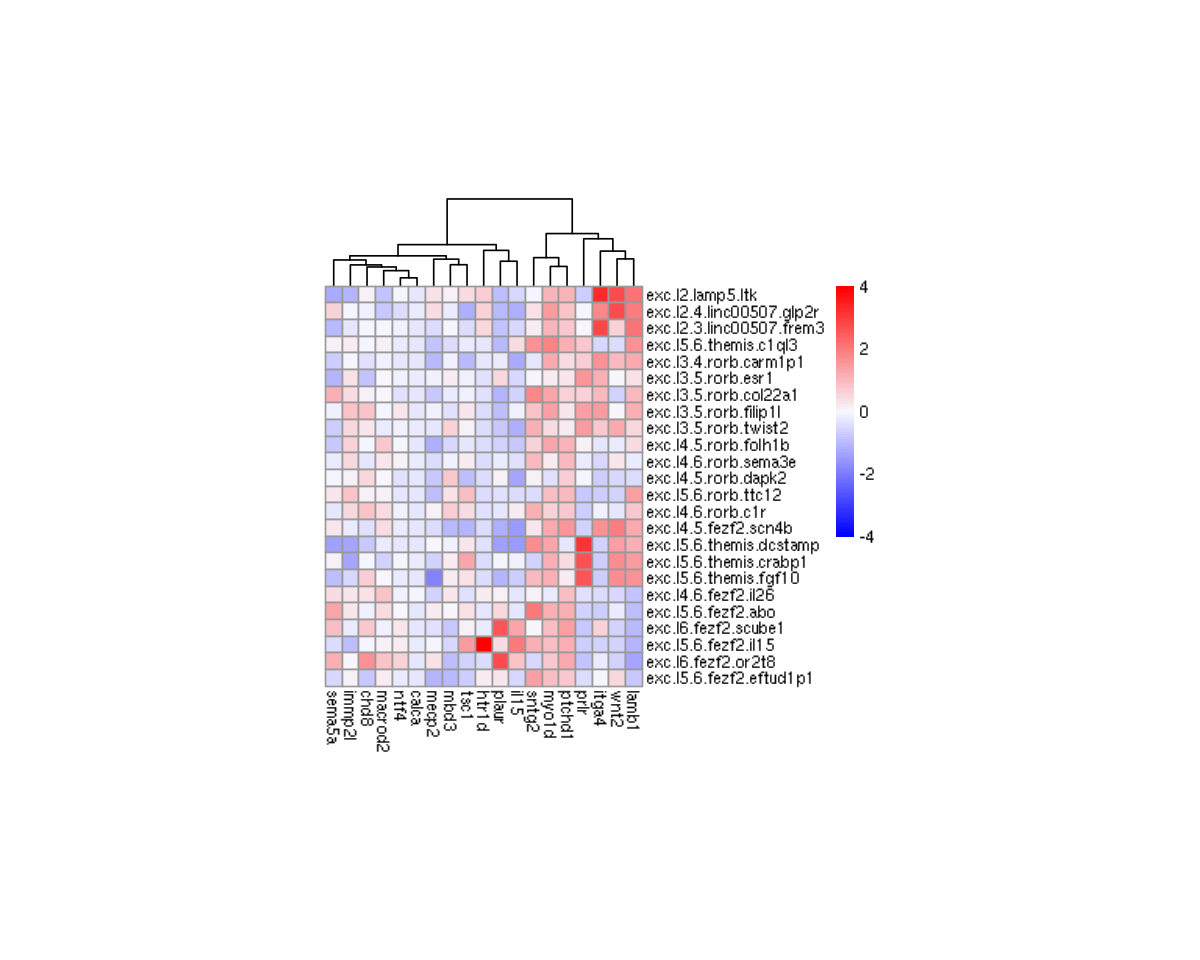

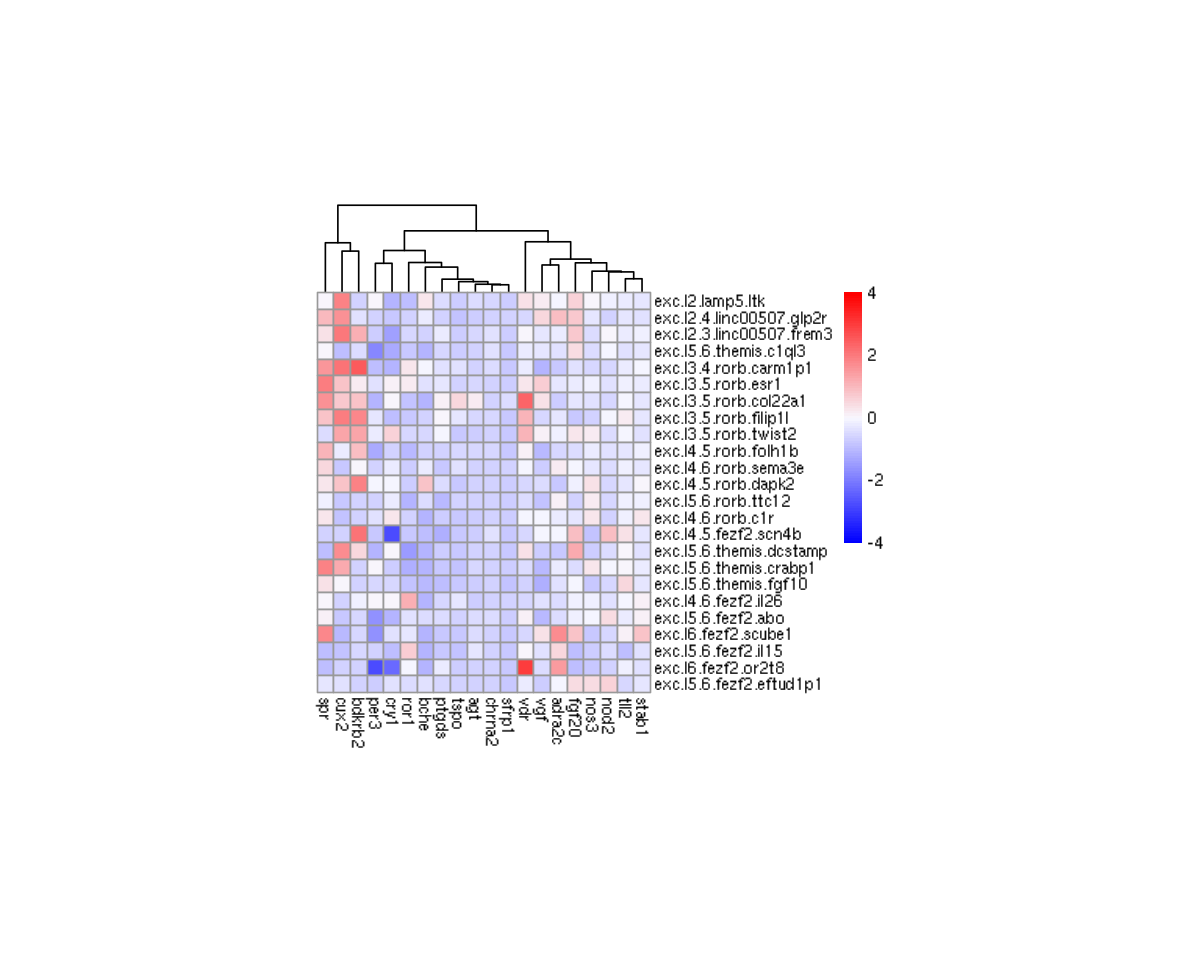

null device 
          1

null device 
          1

null device 
          1

null device 
          1

In [132]:
options(repr.plot.width=10, repr.plot.height=8)

breaksList = seq(-4, 4, by = 8/length(hmcols))

pheatmap(scale(t(indat_autism))[colnames(indat_autism)[46:69],tolower(u_gene_autism_high)],
         cluster_cols=T,cluster_rows=F,clustering_method = "ward.D2",
         color=hmcols,breaks=breaksList,
         cellwidth=10,cellheight=10,fontsize=10,
         annotation_names_col=F, annotation_legend=F,
         annotation_names_row = F,annotation_colors=ann_colors_cluster)

pheatmap(scale(t(indat_bipolar))[colnames(indat_bipolar)[46:69],tolower(u_gene_bipolar_high)],
         cluster_cols=T,cluster_rows=F,clustering_method = "ward.D2",
         color=hmcols,breaks=breaksList,
         cellwidth=10,cellheight=10,fontsize=10,
         annotation_names_col=F, annotation_legend=F,
         annotation_names_row = F,annotation_colors=ann_colors_cluster)

pheatmap(scale(t(indat_schizophrenia))[colnames(indat_schizophrenia)[46:69],tolower(u_gene_schizophrenia_high)],
         cluster_cols=T,cluster_rows=F,clustering_method = "ward.D2",
         color=hmcols,breaks=breaksList,
         cellwidth=10,cellheight=10,fontsize=10,
         annotation_names_col=F, annotation_legend=F,
         annotation_names_row = F,annotation_colors=ann_colors_cluster)


dev.off()
pdf(paste(opath,"Supplementary_Figure_19_Autism.pdf",sep=""),width=15,height=15)
pheatmap(scale(t(indat_autism))[colnames(indat_autism)[46:69],tolower(u_gene_autism_high)],
         cluster_cols=T,cluster_rows=F,clustering_method = "ward.D2",
         color=hmcols,breaks=breaksList,
         cellwidth=10,cellheight=10,fontsize=10,
         annotation_names_col=F, annotation_legend=F,
         annotation_names_row = F,annotation_colors=ann_colors_cluster)
dev.off()
pdf(paste(opath,"Supplementary_Figure_19_Bipolar.pdf",sep=""),width=15,height=15)

pheatmap(scale(t(indat_bipolar))[colnames(indat_bipolar)[46:69],tolower(u_gene_bipolar_high)],
         cluster_cols=T,cluster_rows=F,clustering_method = "ward.D2",
         color=hmcols,breaks=breaksList,
         cellwidth=10,cellheight=10,fontsize=10,
         annotation_names_col=F, annotation_legend=F,
         annotation_names_row = F,annotation_colors=ann_colors_cluster)
dev.off()
pdf(paste(opath,"Supplementary_Figure_19_Schizophrenia.pdf",sep=""),width=15,height=15)
pheatmap(scale(t(indat_schizophrenia))[colnames(indat_schizophrenia)[46:69],tolower(u_gene_schizophrenia_high)],
         cluster_cols=T,cluster_rows=F,clustering_method = "ward.D2",
         color=hmcols,breaks=breaksList,
         cellwidth=10,cellheight=10,fontsize=10,
         annotation_names_col=F, annotation_legend=F,
         annotation_names_row = F,annotation_colors=ann_colors_cluster)
dev.off()


## Supplementary Figure 20.   Human and mouse EWCE distributions

In [133]:
meff=read.csv(paste(ipath,"EWCE_subclass_mouse.csv",sep=""))
heff=read.csv(paste(ipath,"EWCE_subclass_human.csv",sep=""))

msig=read.csv(paste(ipath,"EWCE_subclass_p_mouse.csv",sep=""))
hsig=read.csv(paste(ipath,"EWCE_subclass_p_human.csv",sep=""))
mmat=as.matrix(msig[ind_CTX,-1])
hmat=as.matrix(hsig[ind_CTX,-1])
dnames=as.character(meff[ind_CTX,1])

# enrichment comparison - mouse/human
dsetm=as.vector(as.matrix(meff[ind_CTX,-1]))
dseth=as.vector(as.matrix(heff[ind_CTX,-1]))
rcode=as.vector(row(as.matrix(heff[ind_CTX,-1])))

# absolute value differences 
omat=order(abs(dsetm-dseth),decreasing=T)
smat=sort(abs(dsetm-dseth),decreasing=T) 
rns=as.vector(row(as.matrix(meff[ind_CTX,-1])))


In [134]:
# Figure 4B
cgrpvec=vector("numeric",disnum)
cgrpvec[cgrps[[1]]]=1
cgrpvec[cgrps[[2]]]=4
cgrpvec[cgrps[[3]]]=2
cgrpvec[cgrps[[4]]]=3
cgrpvec <- cgrpvec[ind_CTX]
names(cgrpvec)=disnames[ind_CTX]

gbddist=vector("numeric",length(colp))
names(gbddist)=names(colp)
adgdist=vector("numeric",4)
names(adgdist)=paste("ADG",1:4)

# codes for ADG and GBD
gbdvec=rep(dclass[ind_CTX],20)
adgvec=rep(hbaclus[ind_CTX],20)
ctvec=as.numeric(rep(cgrpvec,20))

### Supplementary Figure 20 - A

null device 
          1

null device 
          1


	Pearson's product-moment correlation

data:  dsetm and dseth
t = 17.918, df = 478, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.5771026 0.6845298
sample estimates:
      cor 
0.6338634 


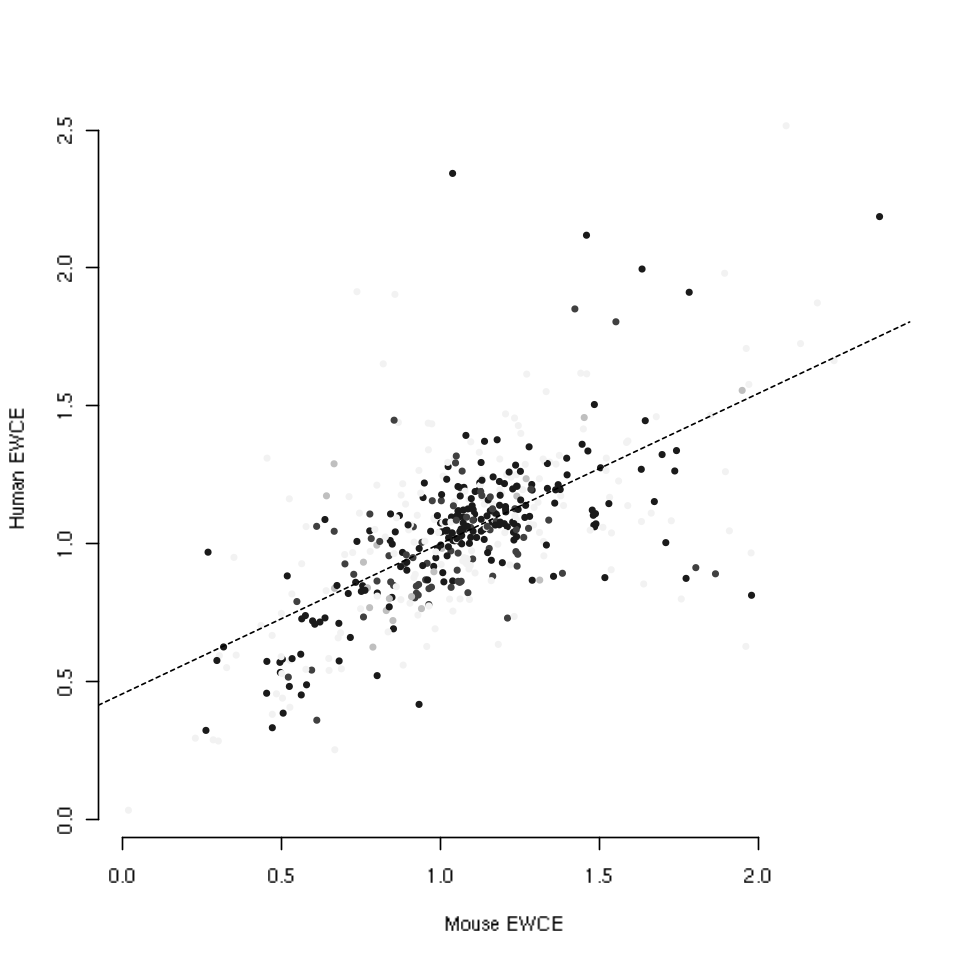

In [135]:
# color by Cell Type group
options(repr.plot.width=8, repr.plot.height=8)
adgpal=rev(c("gray10","gray25","gray75","gray95"))
names(adgpal)=paste("ADG",1:4)
adgvec=rep(hbaclus,20)
plot(dsetm,dseth,pch=20,cex=0.75,axes=F,xlab="Mouse EWCE",ylab="Human EWCE",col=adgpal[ctvec])
axis(1)
axis(2)
mmod=lm(dseth~dsetm)$coefficients
abline(mmod[1],mmod[2],col=1,lty=2)

dev.off()
pdf(paste(opath,"Supplementary_Figure_18_C_main.pdf",sep=""),width=8,height=8)
adgpal=rev(c("gray10","gray25","gray75","gray95"))
names(adgpal)=paste("ADG",1:4)
adgvec=rep(hbaclus,20)
plot(dsetm,dseth,pch=20,cex=0.75,axes=F,xlab="Mouse EWCE",ylab="Human EWCE",col=adgpal[ctvec])
axis(1)
axis(2)
mmod=lm(dseth~dsetm)$coefficients
abline(mmod[1],mmod[2],col=1,lty=2)
dev.off()

cor.test(dsetm,dseth)

In [136]:
# compute distance to regression line by ADG and GBD
distvec=vector("numeric",length(dsetm))
for (i in 1:length(dsetm)) {
  distvec[i]=(dseth[i] - (mmod[1]+dsetm[i]*mmod[2]))^2
} 

In [137]:
for (i in 1:length(colp)) {
  ips=which(gbdvec==i)
  gbddist[i]=mean(distvec[ips])
}

for (i in 1:4) {
  ips=which(adgvec==i)
  adgdist[i]=mean(distvec[ips])
}

ordsq=order(distvec,decreasing=T)

# distvec[ordsq[1:100]] 
distmat=cbind(distvec[ordsq],adgvec[ordsq],gbdvec[ordsq],ctvec[ordsq])

### Supplementary Figure 20 - A : pie charts

    CTG 1     CTG 2     CTG 3     CTG 4 
0.3638908 0.2519244 0.2204339 0.1637509 

      Psychiatric         Substance          Movement Neurodegenerative 
       0.13767209        0.18022528        0.12515645        0.05006258 
     Brain Tumors     Developmental     Brain Related 
       0.11264080        0.24405507        0.15018773 

null device 
          1

    CTG 1     CTG 2     CTG 3     CTG 4 
0.3638908 0.2519244 0.2204339 0.1637509 

null device 
          1

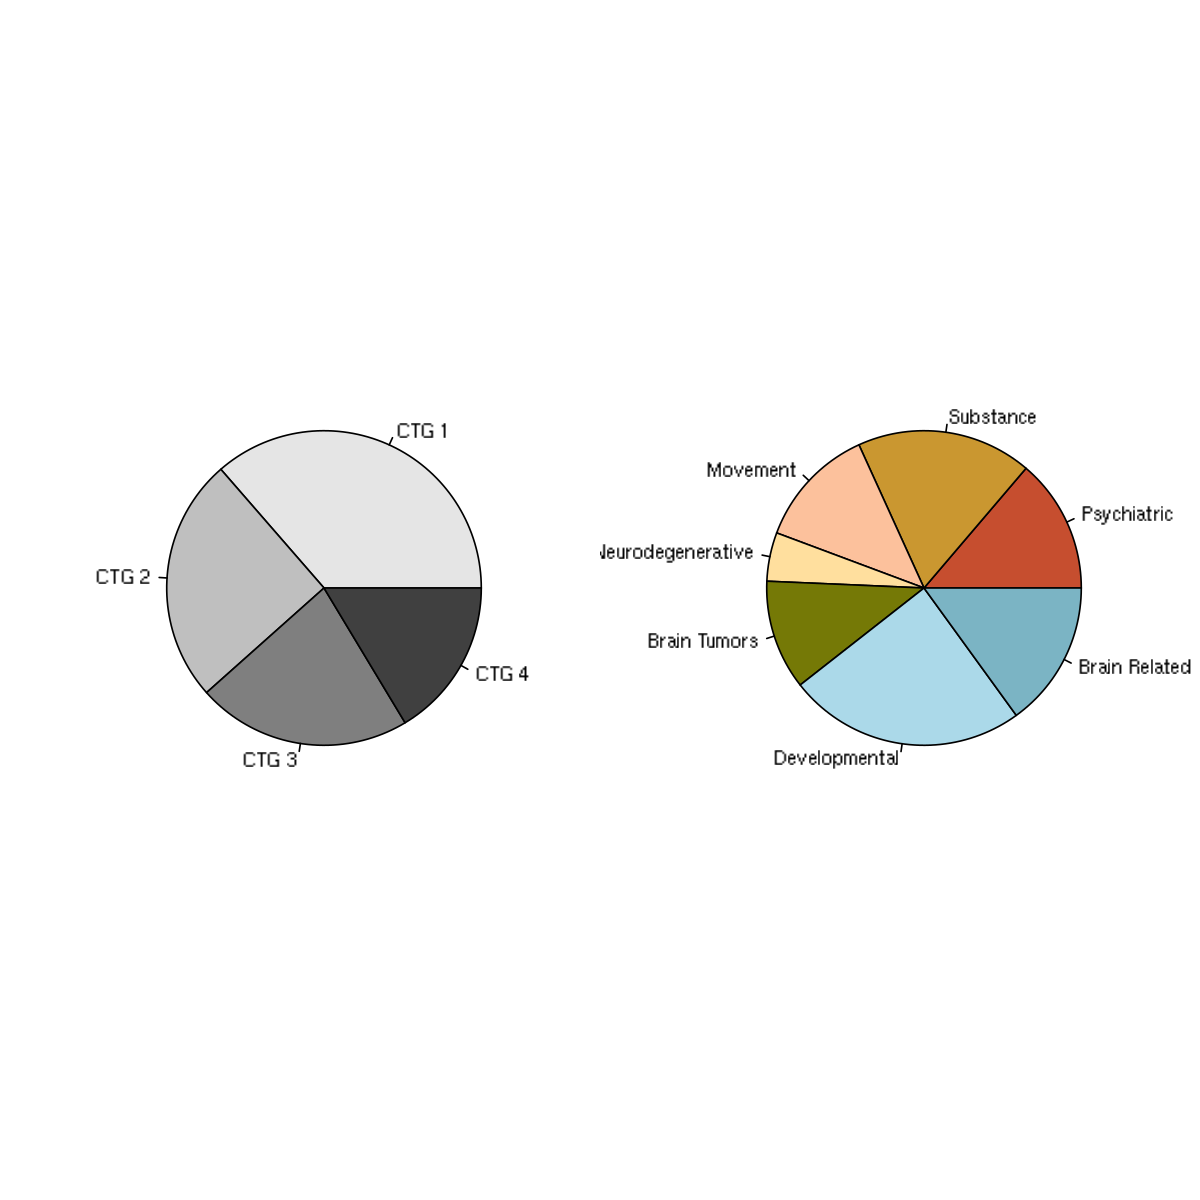

In [138]:
# Cell type
options(repr.plot.width=10, repr.plot.height=10)
par(mfrow = c(1,2))
tcut=round(0.10*(20*disnum_ctx))
pertot=table(distmat[1:(20*disnum_ctx),4]) 
percn=table(distmat[1:tcut,4])/pertot
cnt=table(distmat[1:tcut,4])
names(percn)=paste("CTG",1:4)
names(cnt)=paste("CTG",1:4)
percnorm=percn/sum(percn)

adgpal=c("gray90","gray75","gray50","gray25")
pie(percnorm,col=adgpal)
percnorm
# GBD
tcut=round(0.1*(20*disnum_ctx))
pertot=table(distmat[1:(20*disnum_ctx),3]) 
percn=table(distmat[1:tcut,3])/pertot
cnt=table(distmat[1:tcut,3])
names(percn)=names(colp)
names(cnt)=names(colp)
percnorm=percn/sum(percn)

pie(percnorm,col=colp)
percnorm
dev.off()
pdf(paste(opath,"Supplementary_Figure_18_C_pie.pdf",sep=""),width=10,height=10)
par(mfrow = c(1,2))
tcut=round(0.10*(20*disnum_ctx))
pertot=table(distmat[1:(20*disnum_ctx),4]) 
percn=table(distmat[1:tcut,4])/pertot
cnt=table(distmat[1:tcut,4])
names(percn)=paste("CTG",1:4)
names(cnt)=paste("CTG",1:4)
percnorm=percn/sum(percn)

adgpal=c("gray90","gray75","gray50","gray25")
pie(percnorm,col=adgpal)
percnorm
# GBD
tcut=round(0.1*(20*disnum_ctx))
pertot=table(distmat[1:(20*disnum_ctx),3]) 
percn=table(distmat[1:tcut,3])/pertot
cnt=table(distmat[1:tcut,3])
names(percn)=names(colp)
names(cnt)=names(colp)
percnorm=percn/sum(percn)

pie(percnorm,col=colp)
dev.off()